In [489]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [490]:
conn = sqlite3.connect('web-performance.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements

msm_id            timestamp  \
0      d31444a1-777c-45ae-bb04-f67fbcf67716  2022-06-08_15_01_00   
1      ec2d9a45-57d7-46ec-a505-26427fb1aa48  2022-06-08_15_01_54   
2      a43c51c9-7361-47e7-8b05-95c7d2105c7f  2022-06-08_15_02_48   
3      4d5392b4-2eda-438c-b2d3-233007fecf79  2022-06-08_15_03_42   
4      00dc53ef-e9fa-45e6-af88-2804ef7f2a57  2022-06-08_15_04_36   
...                                     ...                  ...   
10026  4da90a05-0fc2-4fb4-9f23-83699b7b1e95  2022-06-15_17_05_49   
10027  5ed358c1-ba41-41a0-897a-d151c5997a9f  2022-06-15_17_06_48   
10028  75be65ce-2b90-4365-bbf2-991e0aa1ce23  2022-06-15_17_07_43   
10029  00f16d74-e705-4981-8da5-f7d145f79f3e  2022-06-15_17_08_38   
10030  9d32078c-488c-4d35-b0c7-0ec5da333952  2022-06-15_17_09_35   

      experiment_type error            website  
0                 dsl          www.example.org  
1               cable          www.example.org  
2               fiber          www.example.org  
3                  4g          www.example.org  
4           4g-medium          www.example.org  
...               ...   ...                ...  
10026             dsl        www.instagram.com  
10027           cable        www.instagram.com  
10028           fiber        www.instagram.com  
10029              4g        www.instagram.com  
10030       4g-medium        www.instagram.com  

[10031 rows x 5 columns]

In [491]:
measurements.error.value_counts()

    10031
Name: error, dtype: int64

In [492]:
df_web_perf = pd.read_sql_query("SELECT * FROM web_performance_metrics", conn)
df_dns_perf = pd.read_sql_query("SELECT * FROM dns_metrics", conn)
df_lookups = pd.read_sql_query("SELECT * FROM lookups", conn)
conn.close()

In [493]:
df_web_perf = pd.merge(df_web_perf, measurements, on='msm_id')

In [494]:
df_web_perf.groupby(['website','experiment_type', 'is_warmup']).agg(plt=('loadEventStart', 'median'),fcp=('firstContentfulPaint', 'median'))

plt     fcp
website           experiment_type is_warmup                 
www.example.org   4g              0           106.70  116.40
                                  1           266.70  272.20
                  4g-medium       0           121.50  131.65
                                  1           294.80  300.45
                  cable           0            40.20   50.90
                                  1           132.65  138.30
                  dsl             0            72.20   82.50
                                  1           186.60  192.40
                  fiber           0            29.20   39.05
                                  1           103.90  116.00
www.instagram.com 4g              0           326.90  148.20
                                  1          1694.35  280.20
                  4g-medium       0           359.10  161.60
                                  1          2396.00  310.00
                  cable           0           189.40   81.00
                                  1           742.85  146.60
                  dsl             0           315.40  103.20
                                  1          4554.80  200.60
                  fiber           0           170.80   70.10
                                  1           837.70  117.60
www.wikipedia.org 4g              0           134.40  122.50
                                  1           595.10  466.70
                  4g-medium       0           148.80  137.30
                                  1           623.30  480.60
                  cable           0            67.00   55.70
                                  1           353.50  331.00
                  dsl             0            99.00   87.80
                                  1           419.40  290.90
                  fiber           0            57.10   44.80
                                  1           319.20  258.70

In [495]:
df_dns_perf_metrics = df_dns_perf.copy()

In [496]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)

df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]

df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])

df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']

df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [497]:
df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].groupby(['transport_protocol', 'is_warmup']).agg(lookup_dur=('duration','median'))

lookup_dur
transport_protocol is_warmup            
DoH                0          148.578749
DoQ                0          124.317973
DoUDP              0           44.128077

In [498]:
df_exchange_times = df_dns_perf_metrics[df_dns_perf_metrics.metric_type=='exchange'].copy()
df_exchange_times['elapsed'] = df_exchange_times['duration']

In [499]:
df_dns_and_h3 = pd.merge(df_web_perf, df_exchange_times[['msm_id', 'elapsed', 'transport_protocol']], on='msm_id')


In [500]:
df_dns_and_h3['full_plt'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['loadEventStart']
df_dns_and_h3['full_fp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstPaint']
df_dns_and_h3['full_fcp'] = df_dns_and_h3['elapsed'] + df_dns_and_h3['firstContentfulPaint']

In [501]:
df_dns_and_h3['h3_description'] = 'H3 1-RTT'
df_dns_and_h3['h3_description'] = np.where(df_dns_and_h3['is_warmup'] == 0, 'H3 0-RTT', df_dns_and_h3['h3_description'])

In [502]:
df_dns_and_h3.h3_description.value_counts() #thrice the actual value because of join

H3 1-RTT    30093
H3 0-RTT    30093
Name: h3_description, dtype: int64

In [503]:
df_dns_and_h3.transport_protocol.value_counts() #twice the actual value because of join

DoQ      20062
DoH      20062
DoUDP    20062
Name: transport_protocol, dtype: int64

In [504]:
df_dns_and_h3.website.value_counts()

www.instagram.com    21420
www.example.org      19416
www.wikipedia.org    19350
Name: website, dtype: int64

In [505]:
df_dns_and_h3.experiment_type.value_counts()

dsl          12042
cable        12042
fiber        12042
4g           12030
4g-medium    12030
Name: experiment_type, dtype: int64

In [506]:
df_dns_and_h3['experiment_description'] = df_dns_and_h3.transport_protocol + ' + ' + df_dns_and_h3.h3_description

In [507]:
df_dns_and_h3['experiment_description'].value_counts()

DoQ + H3 1-RTT      10031
DoH + H3 1-RTT      10031
DoUDP + H3 1-RTT    10031
DoQ + H3 0-RTT      10031
DoH + H3 0-RTT      10031
DoUDP + H3 0-RTT    10031
Name: experiment_description, dtype: int64

count    10031.000000
mean      1068.879247
std       1194.565083
min        130.541638
10%        195.872151
20%        325.814798
25%        375.328450
30%        423.583987
40%        516.165121
50%        556.042947
60%        804.656387
70%        864.729661
75%        880.573178
80%       1883.426566
90%       2623.731196
100%      4714.307740
max       4714.307740
Name: full_plt, dtype: float64
count    10031.000000
mean       288.929950
std        151.395202
min         65.106910
10%         99.333756
20%        130.026361
25%        182.585900
30%        197.347336
40%        220.331166
50%        259.728339
60%        325.271105
70%        363.179378
75%        378.214870
80%        435.264748
90%        524.085847
100%       606.727058
max        606.727058
Name: full_plt, dtype: float64
count    10031.000000
mean      1119.559386
std       1200.190903
min        145.883457
10%        219.346159
20%        347.177221
25%        390.485675
30%        447.110831
40%        555

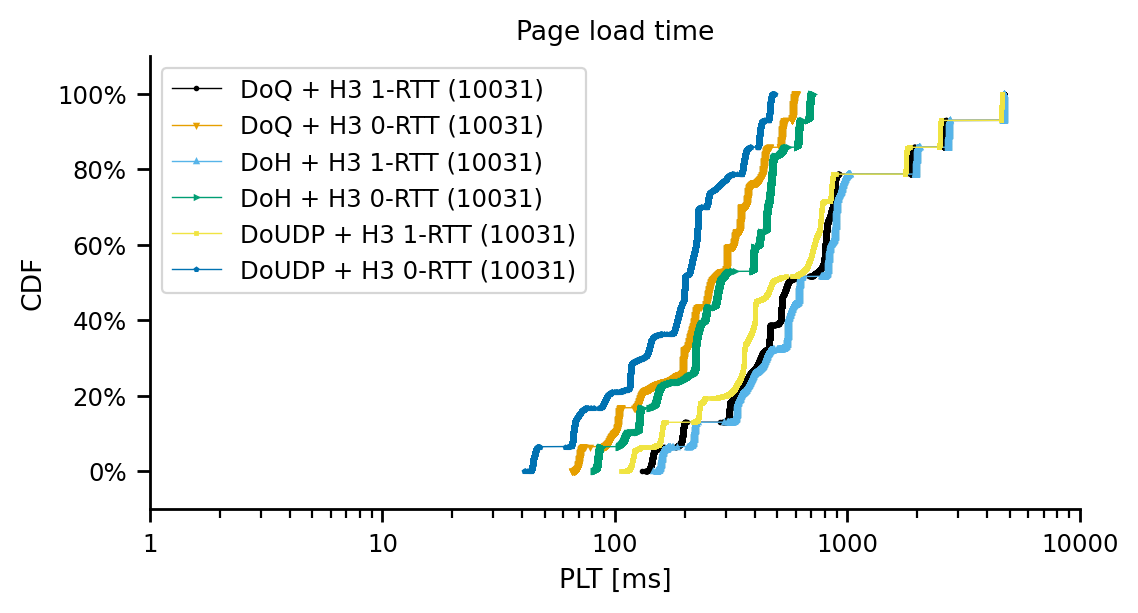

In [508]:
df_plt = df_dns_and_h3
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

lnwidth = 0.5
mrksize = 1
log=True
for experiment in line_order:
        df_tmp = df_plt[(df_plt.experiment_description == experiment)]
        if len(df_tmp['full_plt']) == 0:
            continue
        print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['full_plt'])
        dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Page load time')

ax.set_xlabel('PLT [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(1,10000)


ax.legend()

#if log:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
#else:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
plt.show()

count    3236.000000
mean      326.601628
std       145.686014
min       130.541638
10%       144.855950
20%       170.151301
25%       193.751009
30%       195.604311
40%       201.845615
50%       311.078195
60%       325.560366
70%       462.680767
75%       463.910382
80%       472.202682
90%       520.217700
100%      531.854327
max       531.854327
Name: full_plt, dtype: float64
count    3236.000000
mean      204.015905
std       108.021575
min        65.106910
10%        70.375584
20%        77.902761
25%       102.673595
30%       103.447318
40%       106.427144
50%       196.947981
60%       199.951632
70%       303.012799
75%       303.578757
80%       306.041771
90%       347.239551
100%      350.429995
max       350.429995
Name: full_plt, dtype: float64
count    3236.000000
mean      377.199902
std       181.435571
min       145.883457
10%       158.705434
20%       184.151268
25%       217.516375
30%       219.137655
40%       224.006390
50%       335.112196
60%       349.

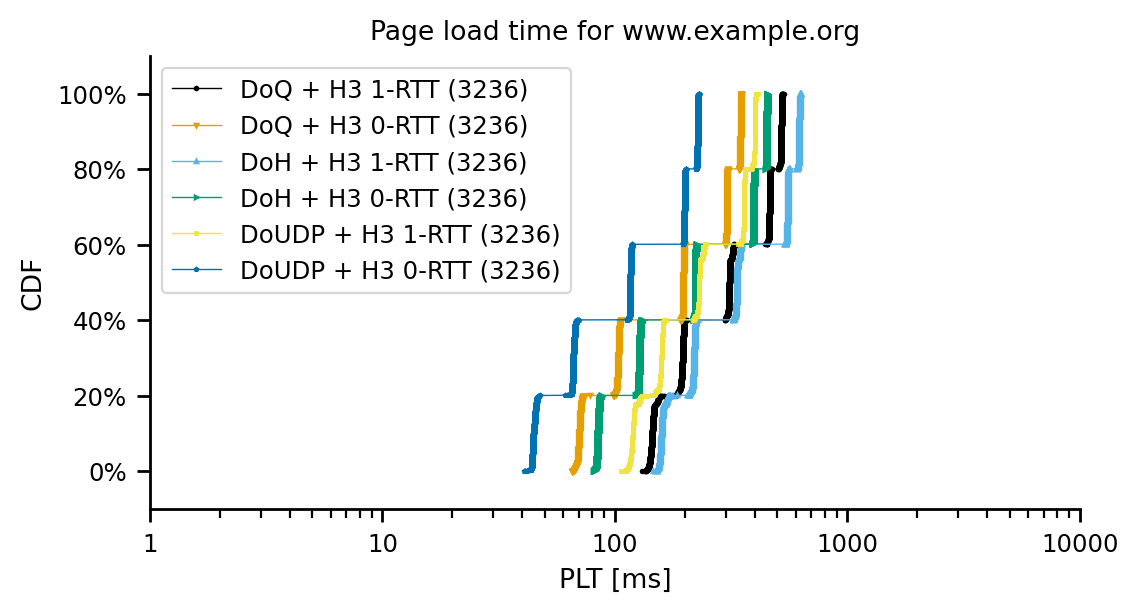

count    3225.000000
mean      588.321393
std       196.621240
min       283.875762
10%       358.108552
20%       381.943328
25%       402.880454
30%       416.576086
40%       474.735684
50%       543.880371
60%       646.518030
70%       786.730908
75%       800.468519
80%       812.921415
90%       849.090397
100%      922.278684
max       922.278684
Name: full_plt, dtype: float64
count    3225.000000
mean      247.657796
std       110.425941
min        86.597017
10%        98.429063
20%       128.798901
25%       132.997705
30%       147.454396
40%       212.299920
50%       223.393658
60%       308.387597
70%       330.327356
75%       368.707191
80%       371.672110
90%       381.105636
100%      454.401893
max       454.401893
Name: full_plt, dtype: float64
count    3225.000000
mean      639.036652
std       232.615672
min       294.770966
10%       373.580142
20%       397.153838
25%       426.397920
30%       440.147260
40%       498.128938
50%       567.882973
60%       697.

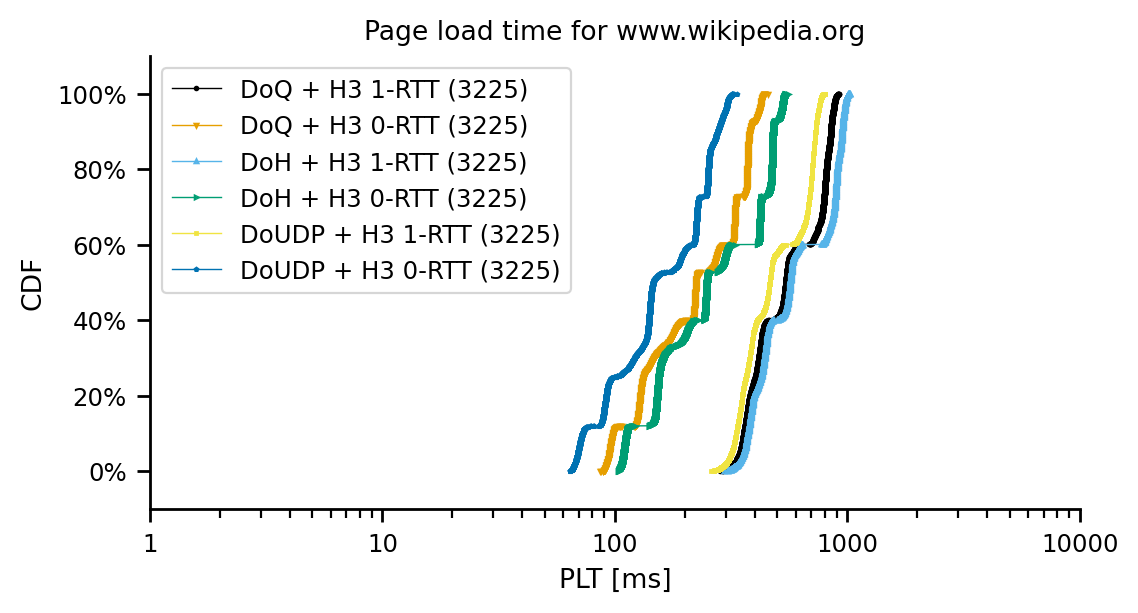

count    3570.000000
mean     2175.828674
std      1422.036328
min       777.021518
10%       805.689929
20%       856.560520
25%       873.925855
30%       878.513263
40%      1483.720898
50%      1890.452428
60%      2213.418255
70%      2621.566481
75%      2627.771700
80%      3054.257175
90%      4679.305722
100%     4714.307740
max      4714.307740
Name: full_plt, dtype: float64
count    3570.000000
mean      403.183324
std       147.267076
min       201.653230
10%       211.701590
20%       240.681387
25%       249.309715
30%       252.481598
40%       368.736588
50%       439.963339
60%       484.414362
70%       522.838242
75%       526.903693
80%       549.713361
90%       584.590949
100%      606.727058
max       606.727058
Name: full_plt, dtype: float64
count    3570.000000
mean     2226.551293
std      1426.645955
min       802.112044
10%       829.305272
20%       873.902033
25%       887.955666
30%       892.500478
40%      1543.176629
50%      1981.566976
60%      2309.

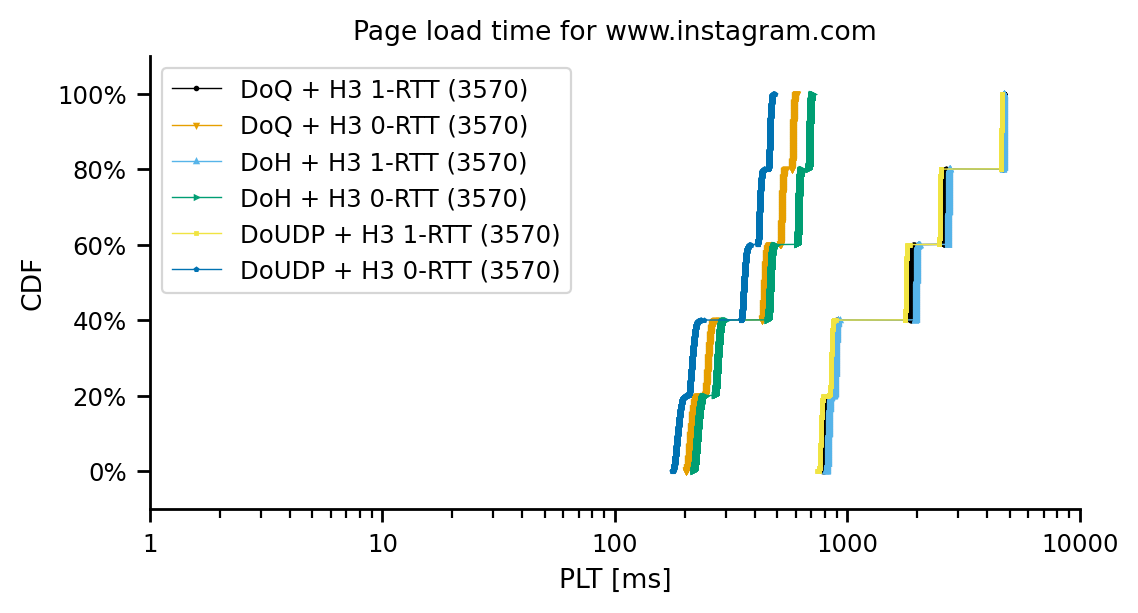

In [509]:
df_plt = df_dns_and_h3
for website in df_plt['website'].unique():
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

    lnwidth = 0.5
    mrksize = 1
    log=True
    for experiment in line_order:
            df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
            if len(df_tmp['full_plt']) == 0:
                continue
            print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

            dfplt = make_cdf(df_tmp['full_plt'])
            dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')


    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('Page load time for '+website)

    ax.set_xlabel('PLT [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(1,10000)


    ax.legend()

    #if log:
    #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
    #else:
    #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
    plt.show()

dsl
count    648.000000
mean     312.079310
std        5.530790
min      297.248899
10%      307.013349
20%      308.930565
25%      309.345456
30%      309.769782
40%      310.354677
50%      311.092105
60%      311.746012
70%      312.440604
75%      313.051582
80%      314.639711
90%      321.534247
100%     326.253237
max      326.253237
Name: full_plt, dtype: float64
count    648.000000
mean     196.943816
std        1.071085
min      191.384091
10%      195.833405
20%      196.110486
25%      196.206689
30%      196.318960
40%      196.624271
50%      196.956919
60%      197.230437
70%      197.429085
75%      197.575675
80%      197.738942
90%      198.334220
100%     200.243854
max      200.243854
Name: full_plt, dtype: float64
count    648.000000
mean     336.153346
std        5.510247
min      321.542713
10%      330.892688
20%      333.103013
25%      333.471536
30%      333.779951
40%      334.446398
50%      335.118054
60%      335.752456
70%      336.485681
75%      337.0

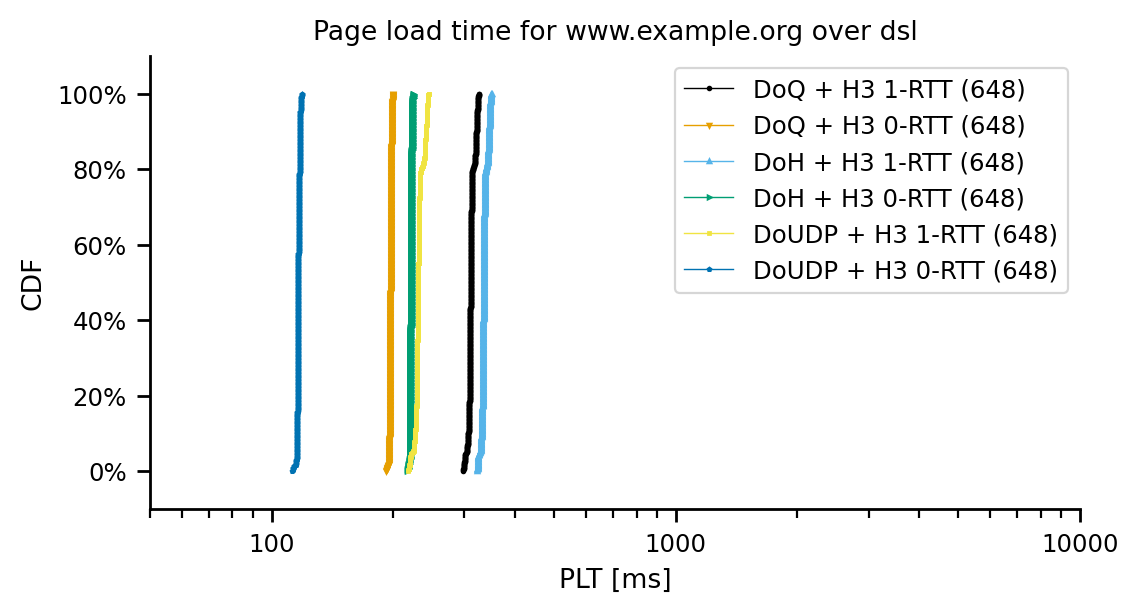

count    645.000000
mean     545.051531
std       25.422371
min      474.771217
10%      515.154467
20%      527.136152
25%      531.014639
30%      534.156436
40%      539.447466
50%      543.880371
60%      548.165182
70%      553.558336
75%      555.702860
80%      560.319386
90%      583.572865
100%     622.779649
max      622.779649
Name: full_plt, dtype: float64
count    645.000000
mean     240.487500
std       25.432113
min      216.338667
10%      219.383964
20%      220.457764
25%      220.878684
30%      221.330553
40%      222.475772
50%      223.393658
60%      226.296570
70%      264.350444
75%      269.310295
80%      272.119174
90%      278.542927
100%     304.379689
max      304.379689
Name: full_plt, dtype: float64
count    645.000000
mean     569.134241
std       25.361802
min      497.988179
10%      539.410123
20%      551.209211
25%      555.208718
30%      557.989638
40%      563.562648
50%      567.882973
60%      572.467354
70%      577.505801
75%      579.61740

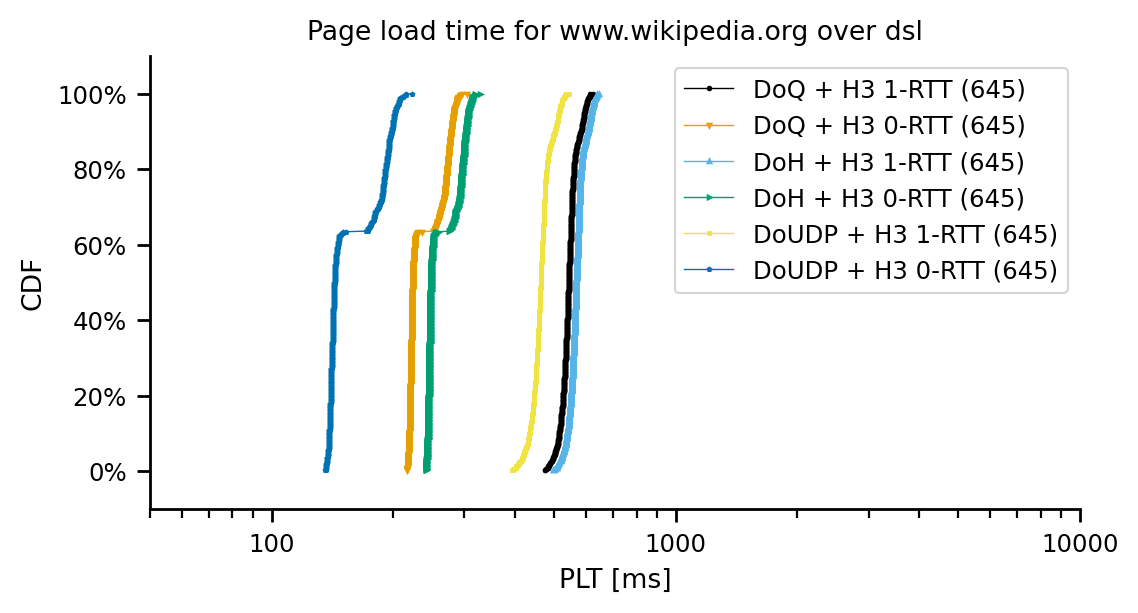

count     714.000000
mean     4680.219351
std         7.743393
min      4662.721141
10%      4671.007787
20%      4673.618107
25%      4674.584482
30%      4675.411716
40%      4676.936094
50%      4679.321426
60%      4681.816118
70%      4683.821869
75%      4685.155973
80%      4686.496393
90%      4690.202157
100%     4714.307740
max      4714.307740
Name: full_plt, dtype: float64
count    714.000000
mean     440.741339
std        6.384549
min      428.189611
10%      433.579816
20%      435.079849
25%      435.710752
30%      436.554915
40%      438.204019
50%      439.963339
60%      441.492601
70%      443.478456
75%      444.463389
80%      445.717403
90%      449.306753
100%     465.496043
max      465.496043
Name: full_plt, dtype: float64
count     714.000000
mean     4704.399464
std         7.761482
min      4686.799056
10%      4695.384649
20%      4697.769524
25%      4698.681729
30%      4699.521828
40%      4701.125316
50%      4703.532895
60%      4706.155850
70%      4

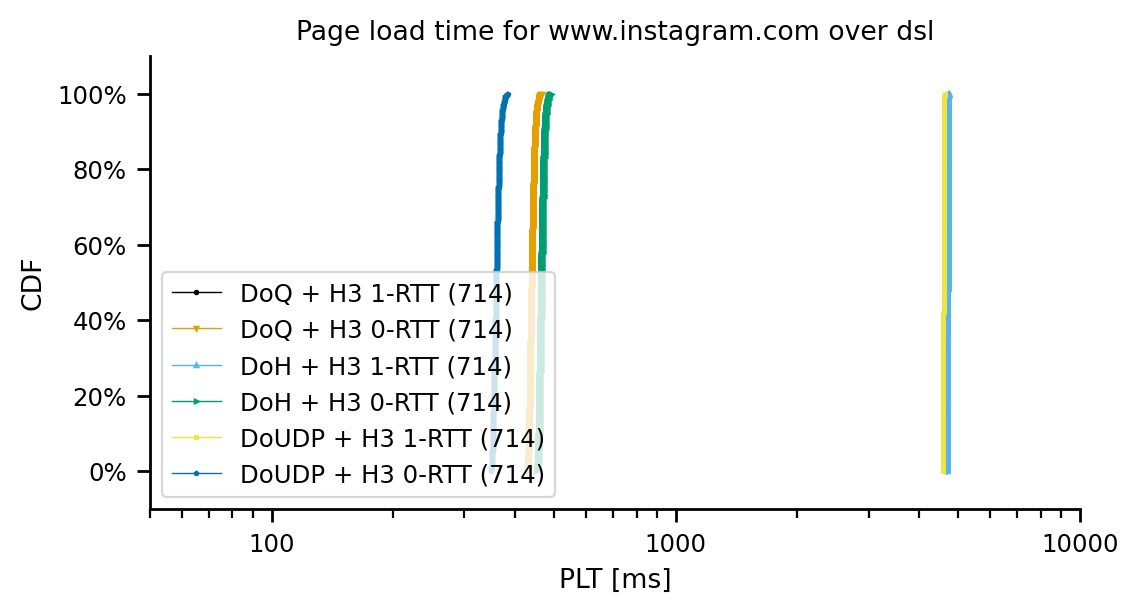

cable
count    648.000000
mean     194.941760
std        3.195102
min      181.320756
10%      191.140439
20%      193.135279
25%      193.766120
30%      194.257230
40%      195.043547
50%      195.619238
60%      196.103677
70%      196.751867
75%      196.995151
80%      197.312349
90%      198.028478
100%     203.253754
max      203.253754
Name: full_plt, dtype: float64
count    648.000000
mean     103.394692
std        1.172357
min       97.993928
10%      102.229197
20%      102.571622
25%      102.676421
30%      102.830134
40%      103.137403
50%      103.449978
60%      103.737576
70%      104.009039
75%      104.110986
80%      104.290257
90%      104.731364
100%     106.501252
max      106.501252
Name: full_plt, dtype: float64
count    648.000000
mean     218.461796
std        3.132191
min      205.148920
10%      214.819446
20%      216.838407
25%      217.535290
30%      217.793798
40%      218.524104
50%      219.145928
60%      219.652312
70%      220.238277
75%      220

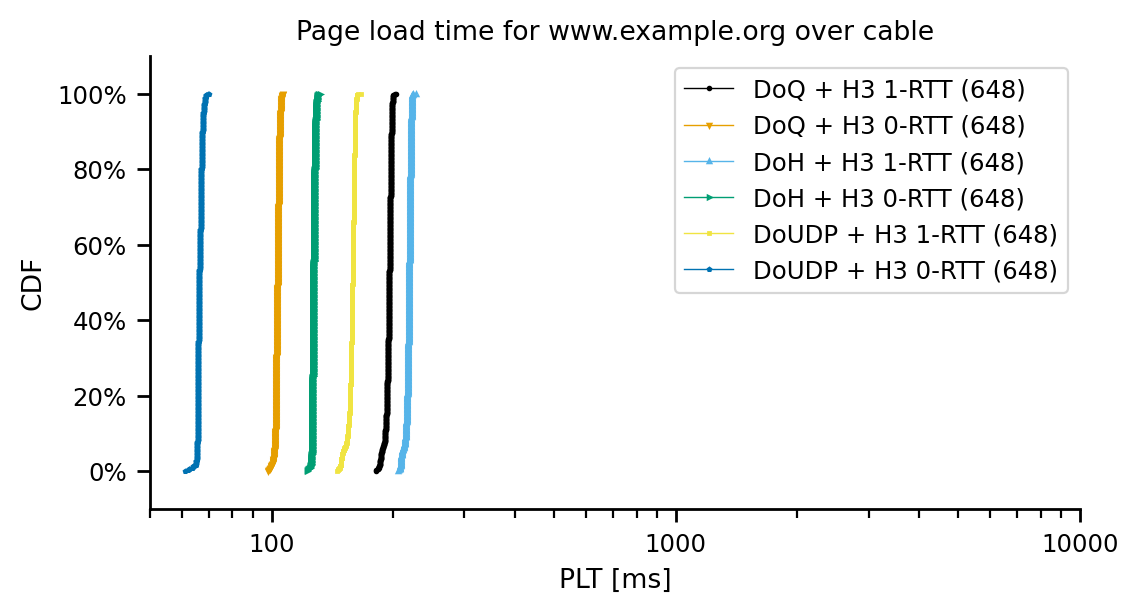

count    645.000000
mean     413.228524
std       21.407886
min      335.840576
10%      387.261141
20%      397.735214
25%      402.880454
30%      406.681549
40%      411.631993
50%      416.565093
60%      421.143761
70%      425.703586
75%      427.348738
80%      429.529712
90%      436.394693
100%     474.682385
max      474.682385
Name: full_plt, dtype: float64
count    645.000000
mean     146.212400
std       25.101116
min      121.248648
10%      125.610251
20%      126.699245
25%      127.345551
30%      127.983175
40%      128.893839
50%      130.153164
60%      132.527125
70%      169.533425
75%      174.477256
80%      177.787983
90%      183.876104
100%     206.241799
max      206.241799
Name: full_plt, dtype: float64
count    645.000000
mean     436.745834
std       21.385900
min      359.286418
10%      410.742572
20%      421.522741
25%      426.397920
30%      430.168758
40%      435.142620
50%      440.140639
60%      444.542226
70%      448.977202
75%      450.48971

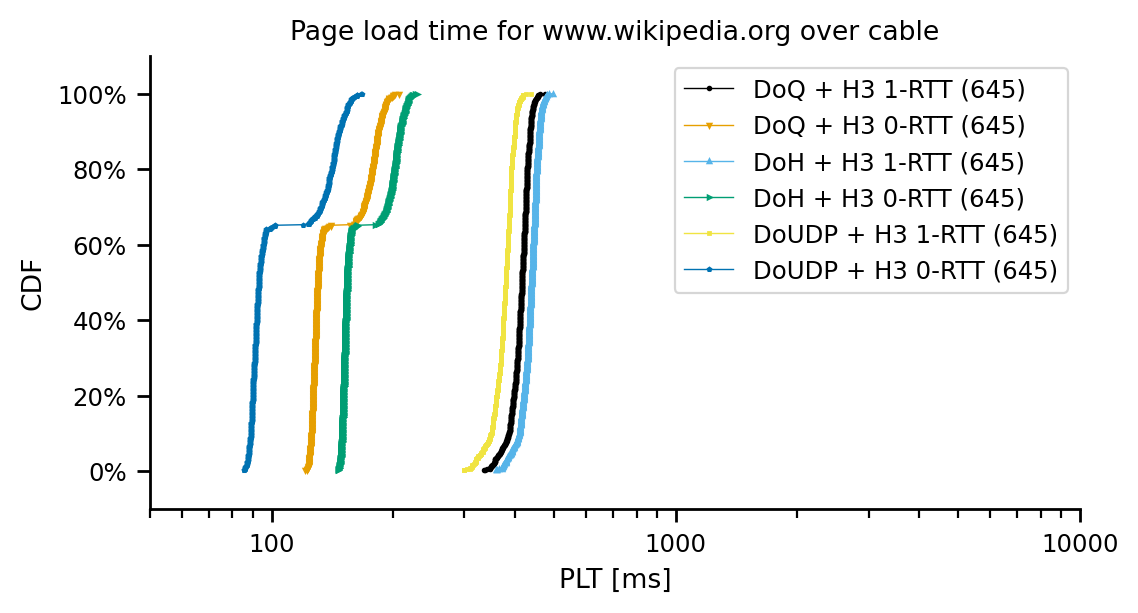

count    714.000000
mean     806.750114
std        8.067662
min      777.021518
10%      797.696060
20%      800.244832
25%      801.270377
30%      802.230654
40%      804.043915
50%      805.669091
60%      808.052141
70%      810.211113
75%      811.432613
80%      813.265015
90%      816.833343
100%     859.369072
max      859.369072
Name: full_plt, dtype: float64
count    714.000000
mean     253.178265
std        5.098385
min      243.403592
10%      247.201830
20%      248.640517
25%      249.309715
30%      250.013746
40%      251.198792
50%      252.481271
60%      253.714828
70%      255.679680
75%      256.371970
80%      257.310974
90%      259.960333
100%     279.557053
max      279.557053
Name: full_plt, dtype: float64
count    714.000000
mean     830.286411
std        8.043977
min      802.112044
10%      821.031537
20%      823.695874
25%      824.763945
30%      825.772090
40%      827.508681
50%      829.303374
60%      831.781736
70%      833.633721
75%      835.06097

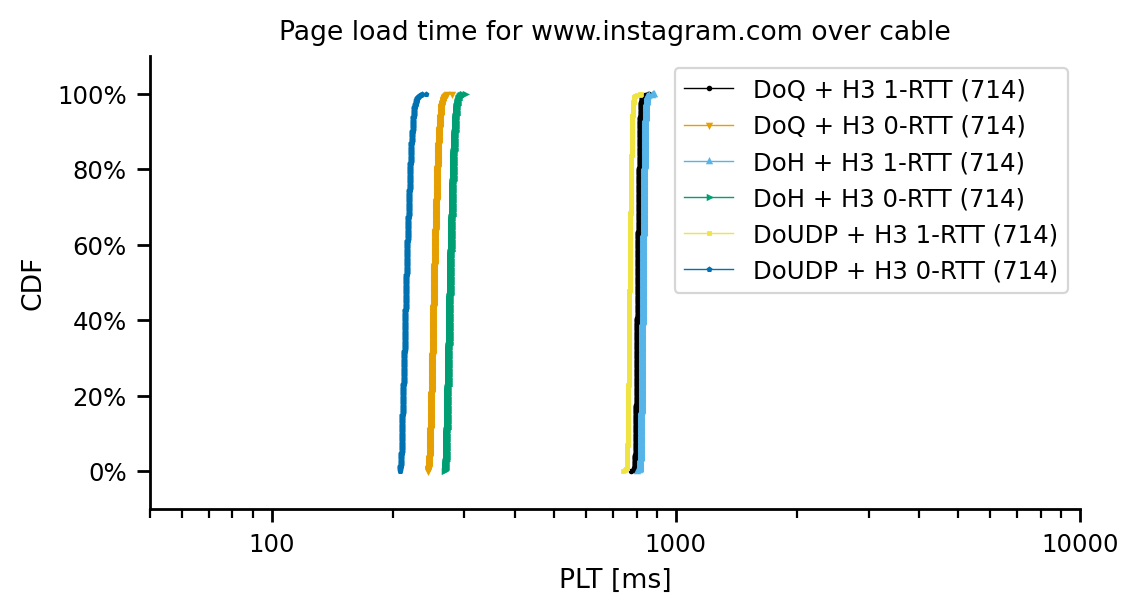

fiber
count    648.000000
mean     145.250395
std        4.124195
min      130.541638
10%      140.869038
20%      142.411960
25%      143.032219
30%      143.520983
40%      144.307465
50%      144.855950
60%      145.431485
70%      146.170803
75%      146.684667
80%      147.159427
90%      151.528475
100%     170.151301
max      170.151301
Name: full_plt, dtype: float64
count    648.000000
mean      70.317216
std        1.318364
min       65.106910
10%       68.952222
20%       69.466873
25%       69.631061
30%       69.735788
40%       70.097178
50%       70.375584
60%       70.675471
70%       70.948443
75%       71.081969
80%       71.277133
90%       71.846423
100%      77.902761
max       77.902761
Name: full_plt, dtype: float64
count    648.000000
mean     159.153297
std        4.022506
min      145.883457
10%      155.201803
20%      156.387073
25%      156.995625
30%      157.436843
40%      158.100076
50%      158.705434
60%      159.255169
70%      159.929139
75%      160

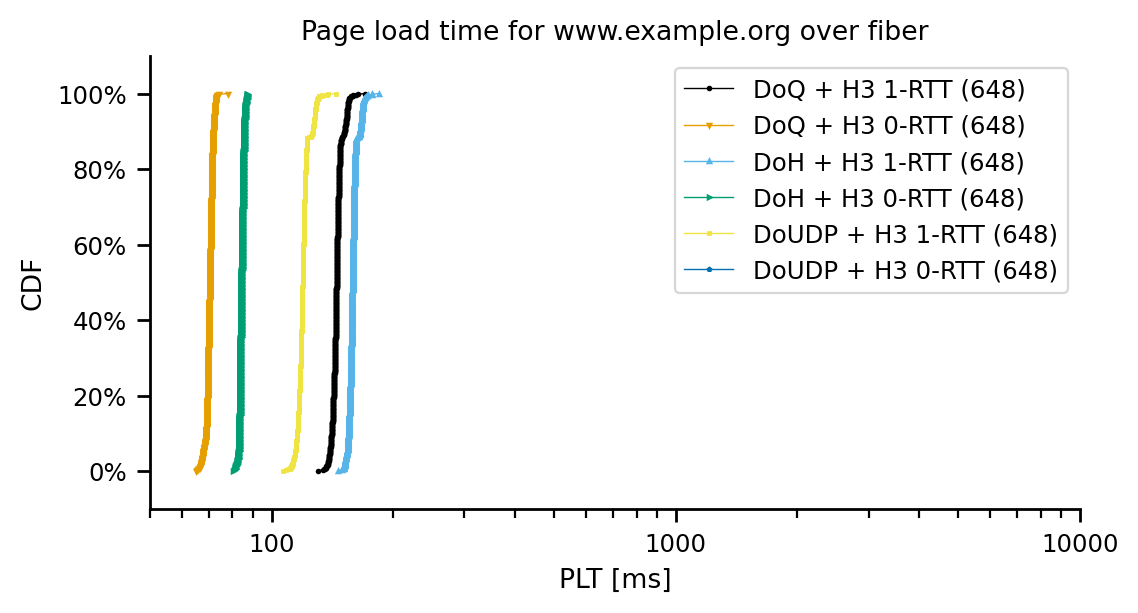

count    645.000000
mean     356.824692
std       21.341514
min      283.875762
10%      326.146281
20%      340.573485
25%      345.793666
30%      349.538706
40%      355.423680
50%      360.079702
60%      365.967953
70%      370.185332
75%      372.953258
80%      374.740101
90%      380.107535
100%     397.453895
max      397.453895
Name: full_plt, dtype: float64
count    645.000000
mean     115.347482
std       25.059151
min       86.597017
10%       92.461230
20%       94.290315
25%       94.833465
30%       95.488297
40%       96.737909
50%       98.429023
60%      125.596035
70%      137.944057
75%      141.799950
80%      144.572665
90%      151.230089
100%     171.838528
max      171.838528
Name: full_plt, dtype: float64
count    645.000000
mean     370.778792
std       21.355407
min      294.770966
10%      339.928551
20%      355.008116
25%      359.700126
30%      363.889483
40%      369.438153
50%      374.249514
60%      379.575028
70%      384.282117
75%      386.86545

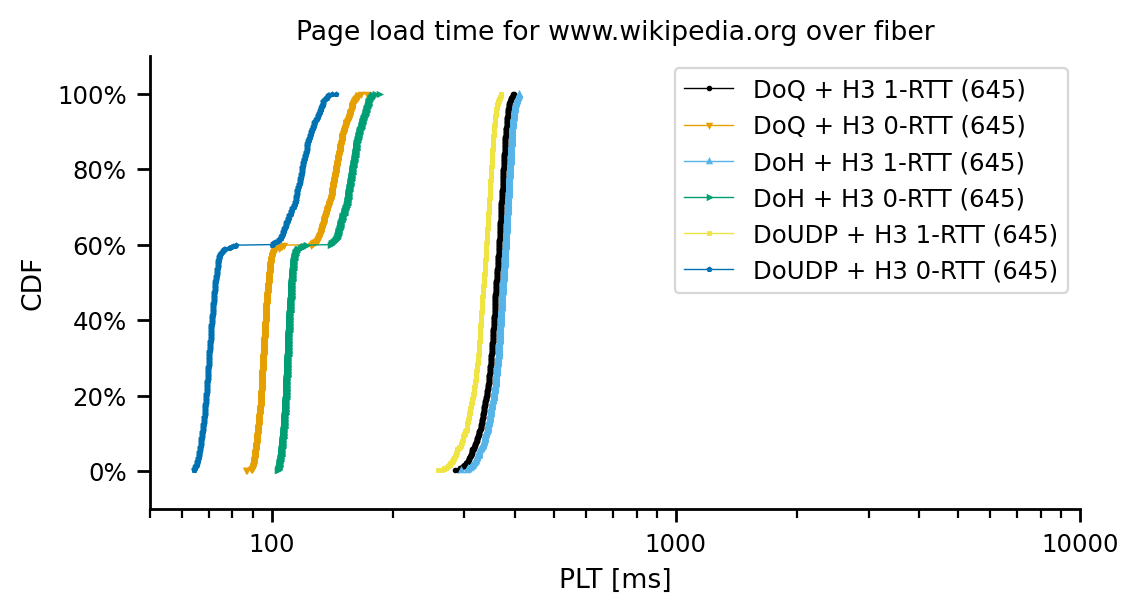

count    714.000000
mean     879.096118
std        7.663662
min      855.160015
10%      870.083346
20%      872.802287
25%      873.925855
30%      874.676718
40%      876.560898
50%      878.509045
60%      880.581758
70%      882.836104
75%      883.994664
80%      885.597167
90%      889.784568
100%     914.758978
max      914.758978
Name: full_plt, dtype: float64
count    714.000000
mean     212.291917
std        5.147625
min      201.653230
10%      206.262723
20%      207.716392
25%      208.427143
30%      208.989981
40%      210.332286
50%      211.689092
60%      213.501932
70%      214.787456
75%      215.576791
80%      216.698326
90%      219.310238
100%     229.792569
max      229.792569
Name: full_plt, dtype: float64
count    714.000000
mean     893.090818
std        7.481139
min      869.575672
10%      884.160072
20%      886.916310
25%      887.955666
30%      888.824008
40%      890.791394
50%      892.496410
60%      894.426140
70%      896.616336
75%      897.66414

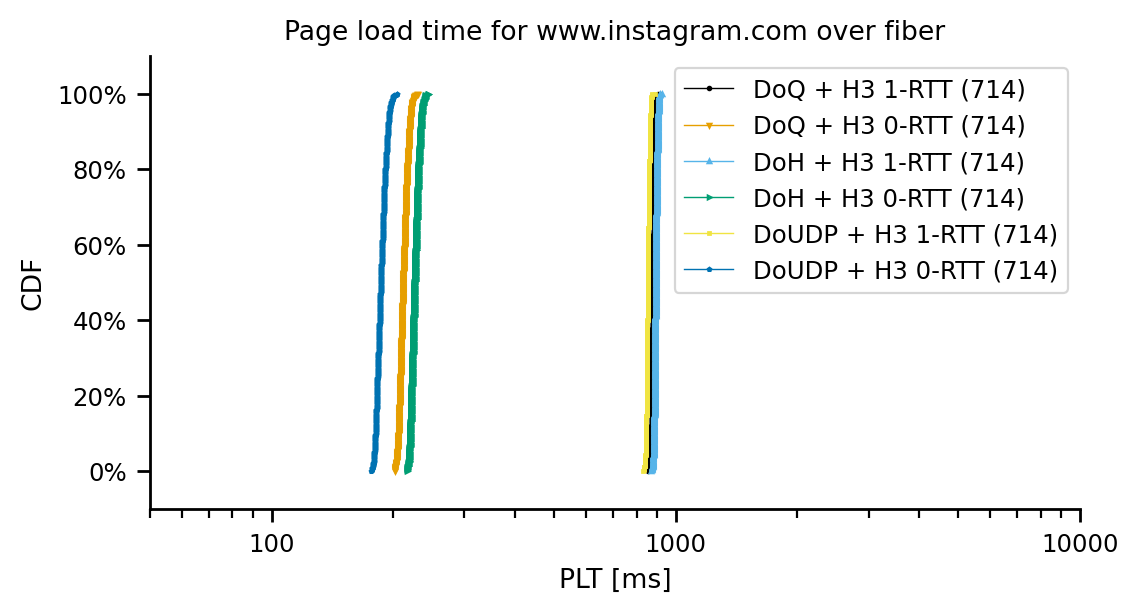

4g
count    646.000000
mean     462.179954
std        3.044258
min      442.345245
10%      459.220089
20%      460.664576
25%      461.214489
30%      461.568778
40%      462.173805
50%      462.691614
60%      463.122793
70%      463.663853
75%      463.918524
80%      464.353438
90%      464.954112
100%     475.913031
max      475.913031
Name: full_plt, dtype: float64
count    646.000000
mean     303.012771
std        1.076220
min      298.184987
10%      301.902723
20%      302.155246
25%      302.285580
30%      302.426286
40%      302.731698
50%      303.018765
60%      303.289159
70%      303.490845
75%      303.581561
80%      303.800661
90%      304.356049
100%     306.191711
max      306.191711
Name: full_plt, dtype: float64
count    646.000000
mean     552.980839
std        3.029644
min      532.959794
10%      550.073172
20%      551.513907
25%      552.006040
30%      552.365052
40%      553.089113
50%      553.647252
60%      554.048937
70%      554.448009
75%      554.65

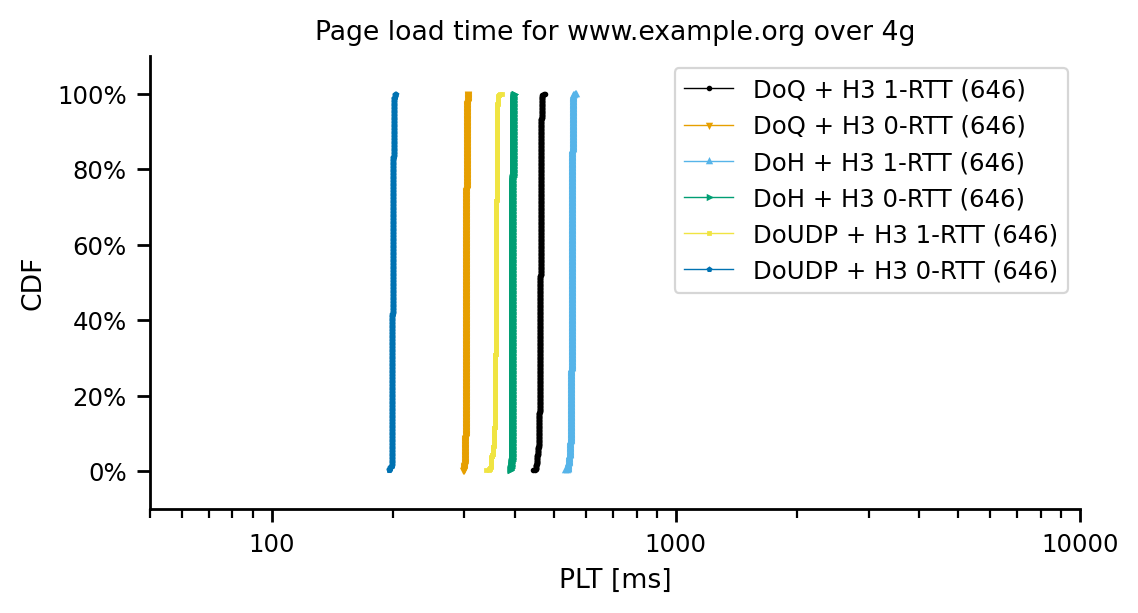

count    645.000000
mean     779.804997
std       35.249521
min      682.125601
10%      721.840118
20%      747.530818
25%      755.303408
30%      766.996785
40%      780.315603
50%      790.425857
60%      797.847280
70%      804.108508
75%      806.639611
80%      809.762229
90%      816.872136
100%     849.265302
max      849.265302
Name: full_plt, dtype: float64
count    645.000000
mean     346.112904
std       24.803290
min      314.399460
10%      325.210470
20%      326.489419
25%      327.073662
30%      327.658061
40%      328.623835
50%      330.330822
60%      333.017166
70%      368.408709
75%      373.459283
80%      376.166664
90%      383.644164
100%     407.037490
max      407.037490
Name: full_plt, dtype: float64
count    645.000000
mean     870.813878
std       35.288681
min      772.871368
10%      812.511091
20%      838.395959
25%      846.437996
30%      857.456358
40%      871.258810
50%      881.899290
60%      888.810980
70%      895.182962
75%      897.66339

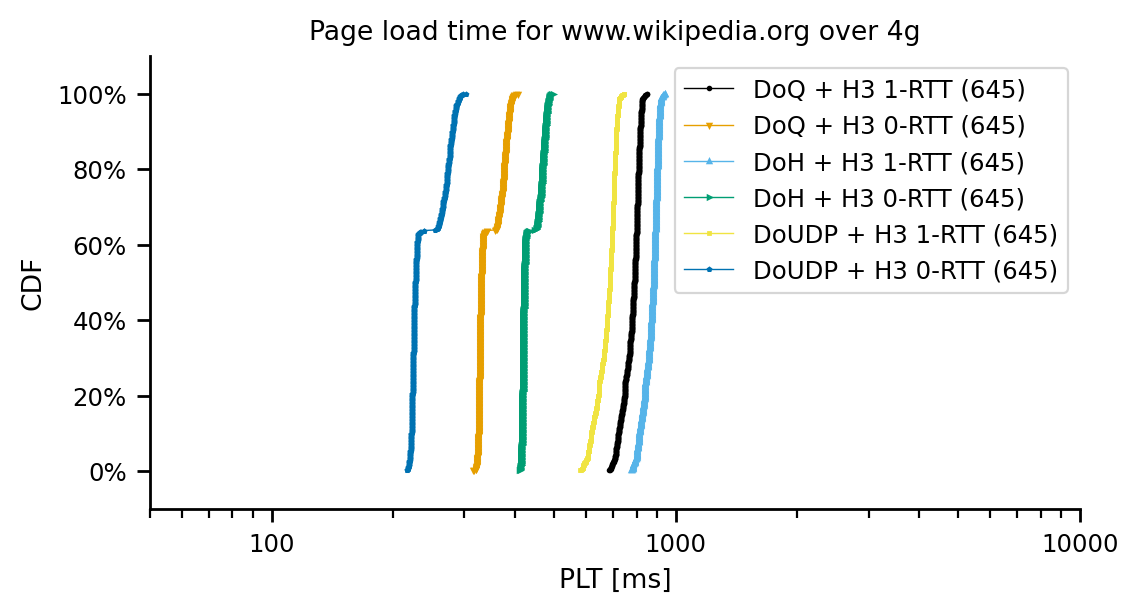

count     714.000000
mean     1891.258809
std         9.601833
min      1863.028844
10%      1880.098903
20%      1883.730245
25%      1885.340064
30%      1886.392535
40%      1888.601217
50%      1890.452428
60%      1892.547007
70%      1895.525300
75%      1896.750900
80%      1898.065053
90%      1901.972966
100%     1955.819145
max      1955.819145
Name: full_plt, dtype: float64
count    714.000000
mean     523.970853
std        5.004144
min      512.791841
10%      518.557733
20%      519.676582
25%      520.241589
30%      520.753575
40%      521.866180
50%      522.842022
60%      524.102912
70%      526.103807
75%      526.903693
80%      528.216825
90%      531.143312
100%     543.286594
max      543.286594
Name: full_plt, dtype: float64
count     714.000000
mean     1982.174818
std         9.663406
min      1954.657838
10%      1970.972533
20%      1974.675879
25%      1976.085701
30%      1977.334704
40%      1979.330473
50%      1981.566976
60%      1983.574603
70%      1

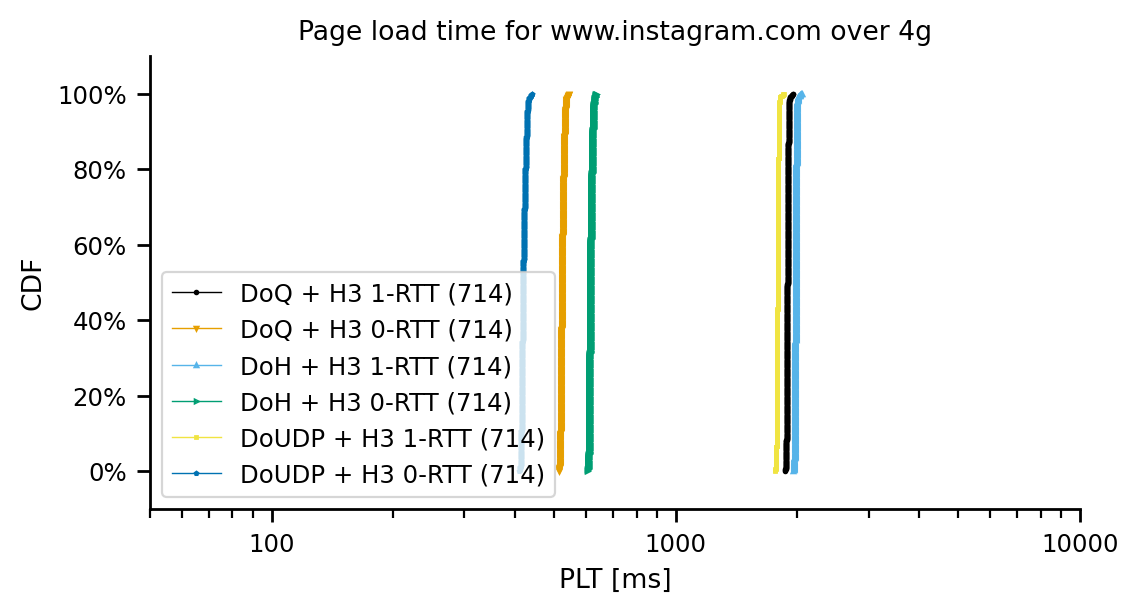

4g-medium
count    646.000000
mean     519.570758
std        3.319584
min      503.219141
10%      516.233110
20%      518.173612
25%      518.781000
30%      519.098840
40%      519.824940
50%      520.223504
60%      520.665299
70%      521.103561
75%      521.370763
80%      521.724388
90%      522.469438
100%     531.854327
max      531.854327
Name: full_plt, dtype: float64
count    646.000000
mean     347.158374
std        1.107556
min      341.582664
10%      346.058281
20%      346.275211
25%      346.400604
30%      346.525636
40%      346.848313
50%      347.249536
60%      347.452751
70%      347.684796
75%      347.819883
80%      347.994400
90%      348.576067
100%     350.429995
max      350.429995
Name: full_plt, dtype: float64
count    646.000000
mean     620.543824
std        3.313450
min      604.201542
10%      616.890286
20%      619.105509
25%      619.711331
30%      620.165939
40%      620.742776
50%      621.283633
60%      621.705865
70%      622.197584
75%     

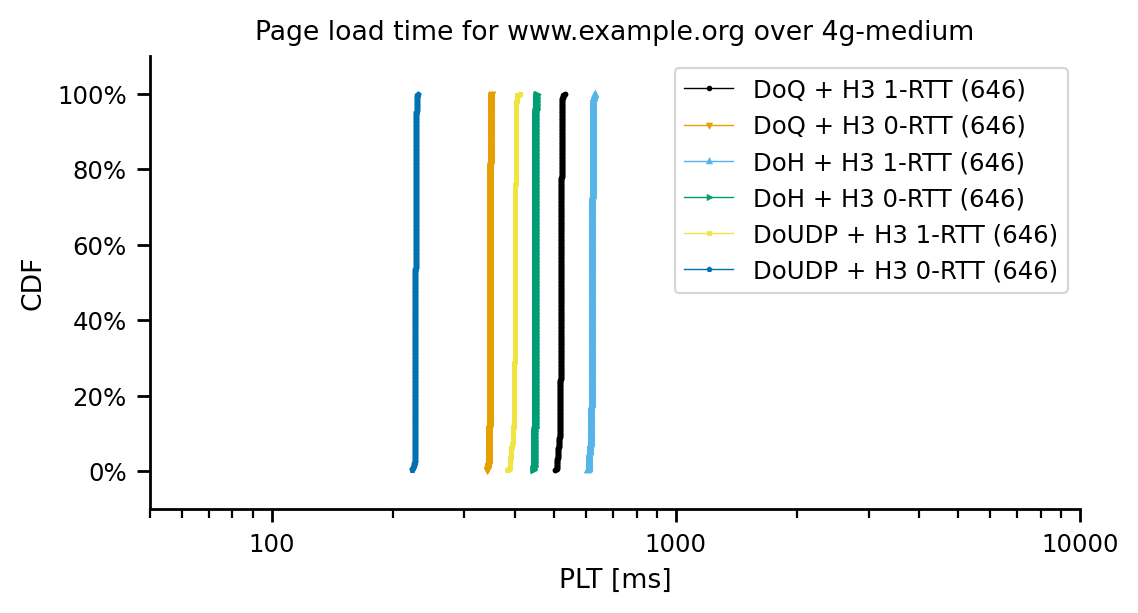

count    645.000000
mean     846.697220
std       29.970339
min      773.119001
10%      799.841511
20%      821.985743
25%      830.840326
30%      834.745374
40%      843.348572
50%      848.956899
60%      854.287407
70%      861.527052
75%      867.025757
80%      872.851077
90%      883.806188
100%     922.278684
max      922.278684
Name: full_plt, dtype: float64
count    645.000000
mean     390.128693
std       24.400397
min      363.367230
10%      369.636798
20%      370.930847
25%      371.464029
30%      371.948143
40%      373.104108
50%      374.289088
60%      377.154229
70%      411.288569
75%      416.951157
80%      421.472608
90%      426.854754
100%     454.401893
max      454.401893
Name: full_plt, dtype: float64
count     645.000000
mean      947.710514
std        29.995703
min       874.479306
10%       901.093913
20%       922.851689
25%       931.350263
30%       935.408994
40%       944.440181
50%       949.894497
60%       955.370747
70%       962.854445
75%   

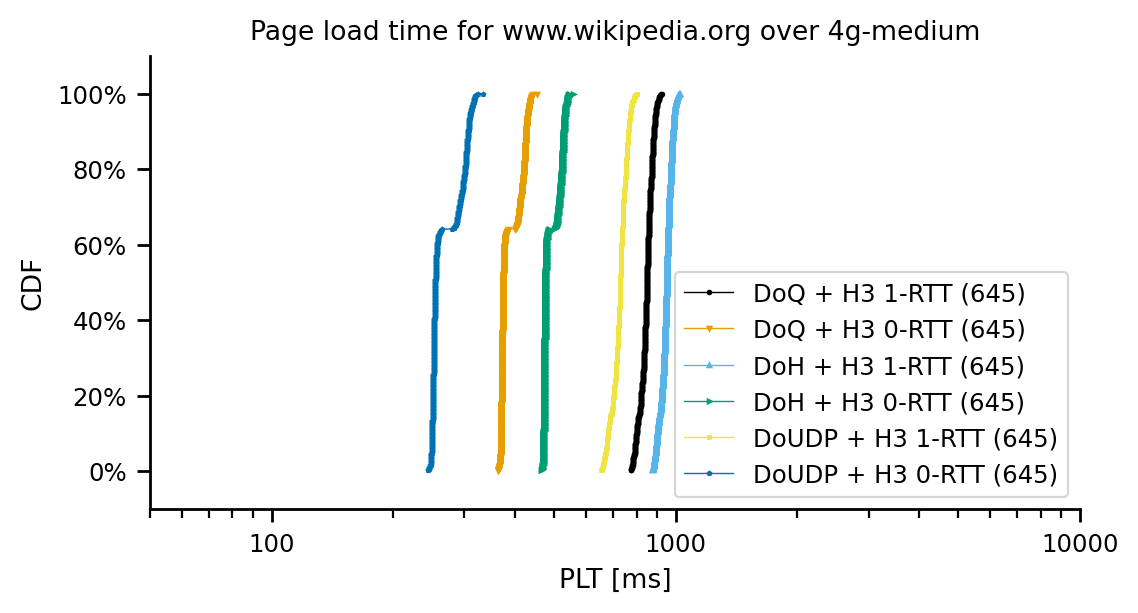

count     714.000000
mean     2621.818981
std         8.801558
min      2599.816920
10%      2610.535205
20%      2613.861890
25%      2615.243152
30%      2616.704590
40%      2619.504568
50%      2621.572062
60%      2623.934285
70%      2626.430914
75%      2627.771700
80%      2629.177458
90%      2633.461717
100%     2652.141183
max      2652.141183
Name: full_plt, dtype: float64
count    714.000000
mean     585.734247
std        4.834045
min      575.420431
10%      580.440604
20%      581.710539
25%      582.215687
30%      582.734913
40%      583.727410
50%      584.593745
60%      585.907533
70%      587.512992
75%      588.826155
80%      589.987547
90%      592.439800
100%     606.727058
max      606.727058
Name: full_plt, dtype: float64
count     714.000000
mean     2722.804953
std         8.799913
min      2700.645313
10%      2711.383055
20%      2715.002797
25%      2716.103494
30%      2717.816723
40%      2720.676029
50%      2722.452581
60%      2724.905262
70%      2

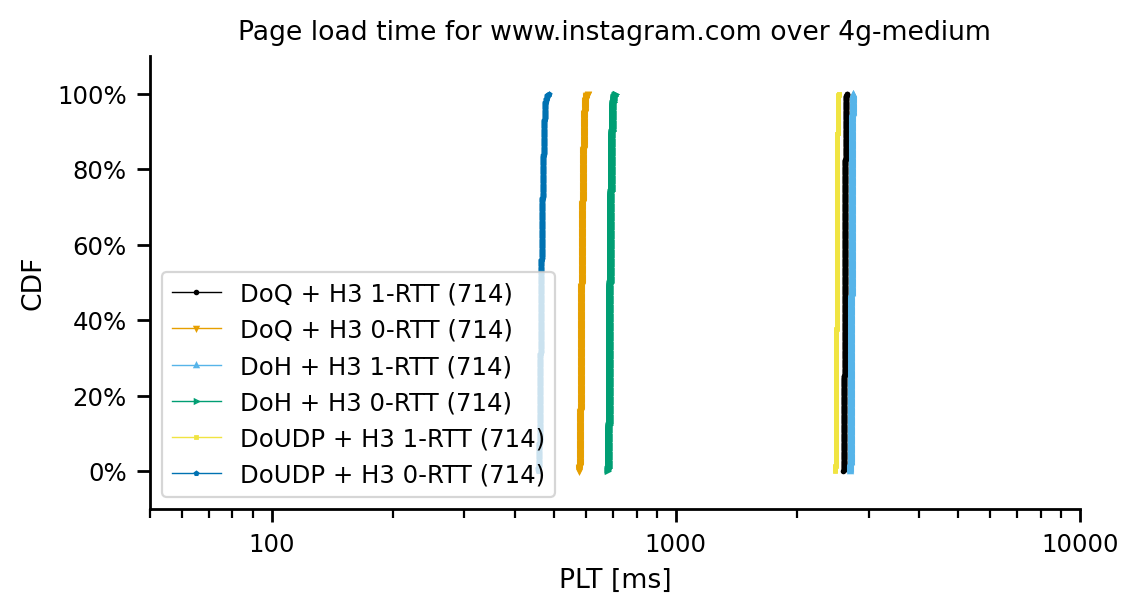

In [510]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

fiber


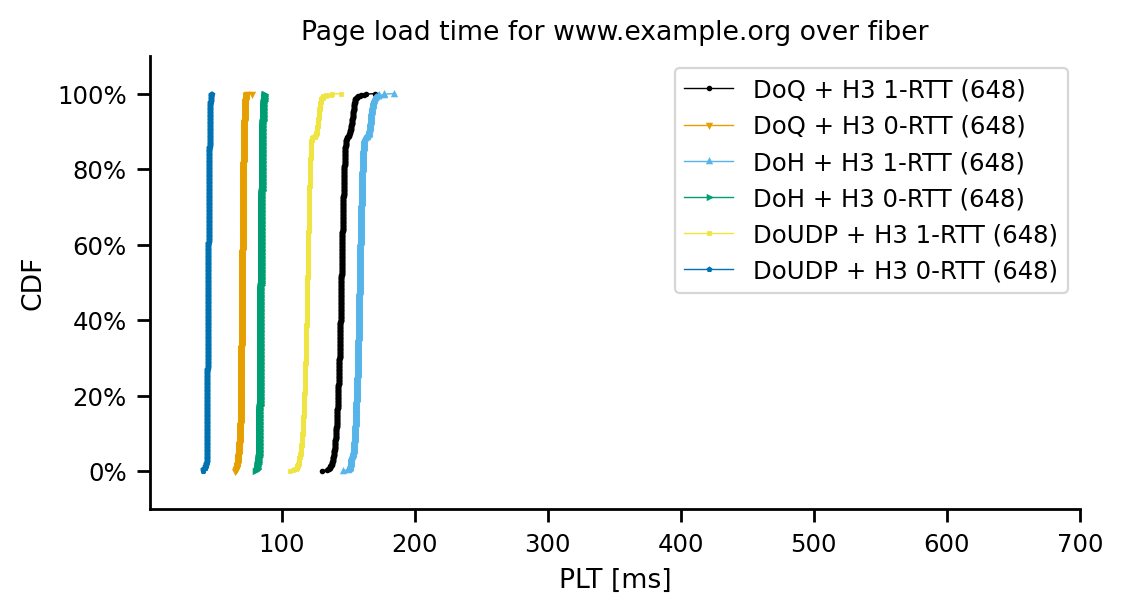

cable


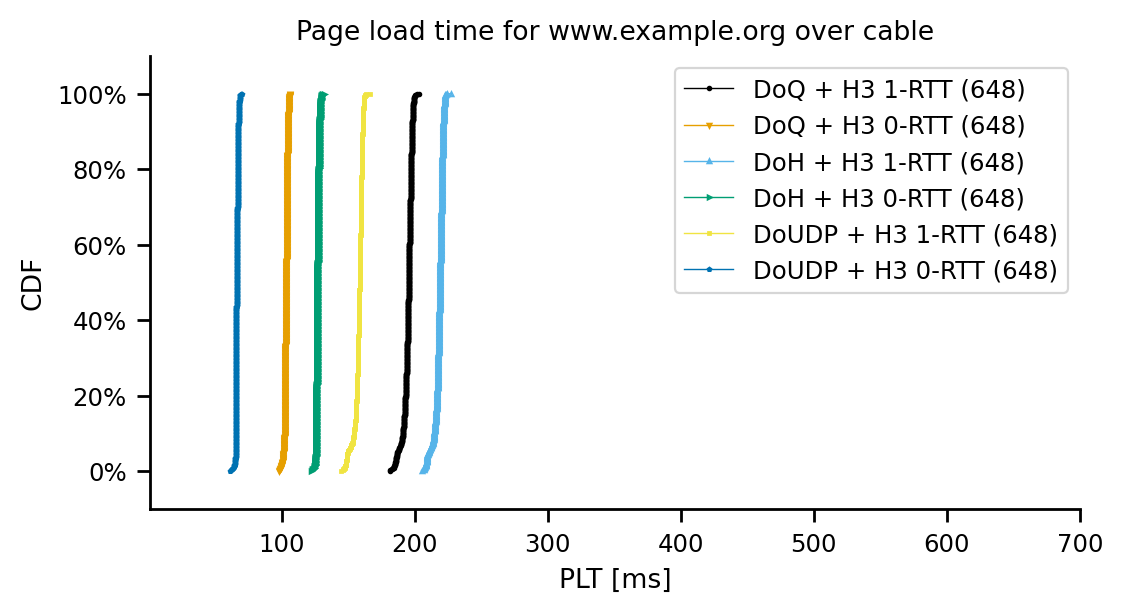

dsl


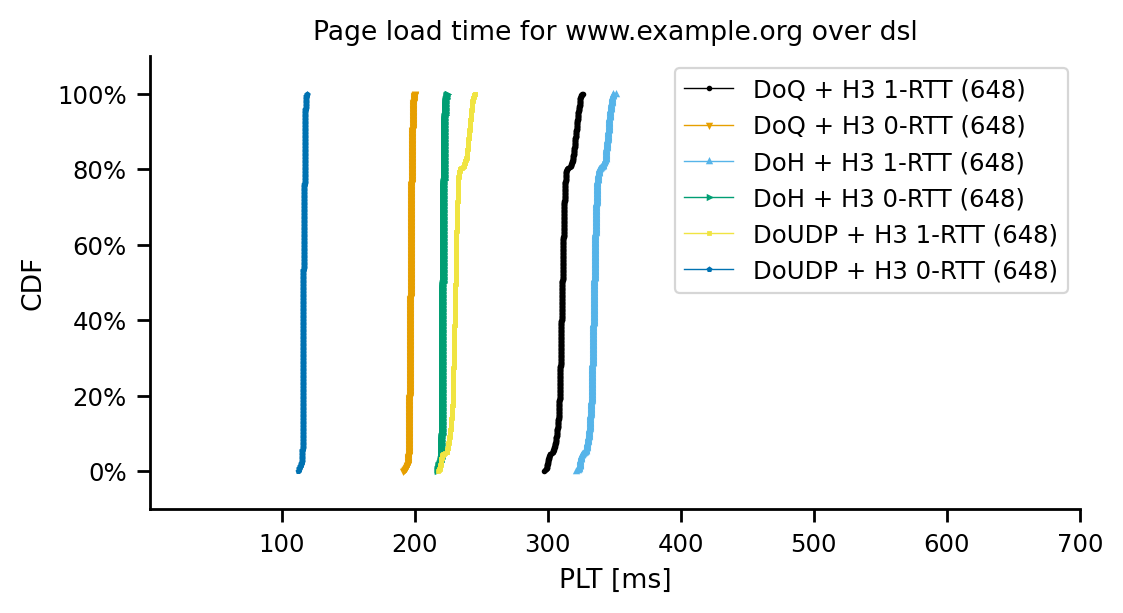

4g


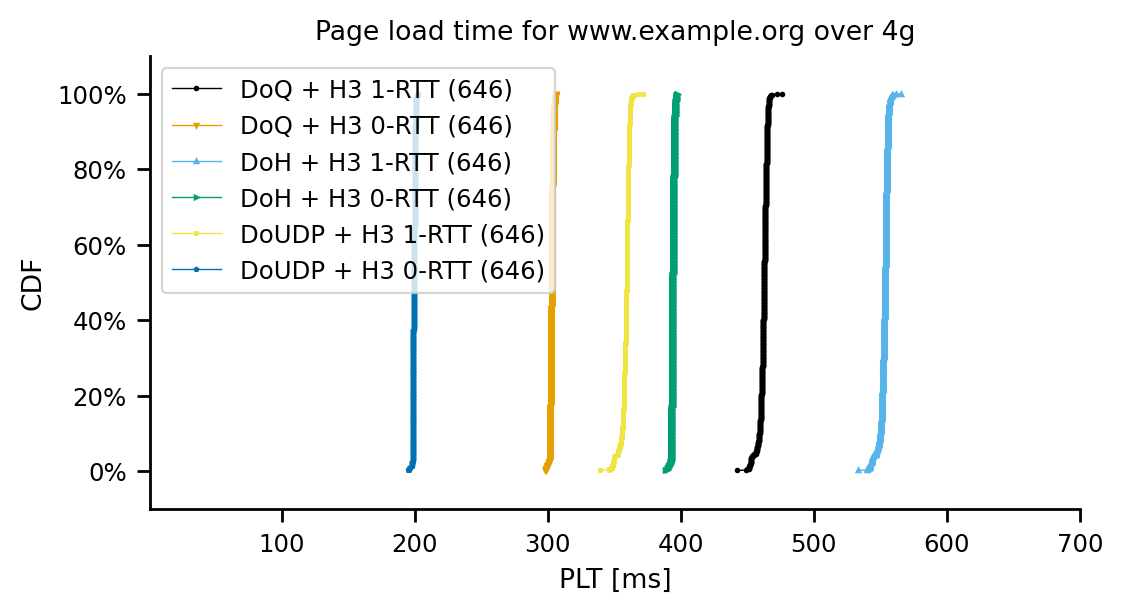

4g-medium


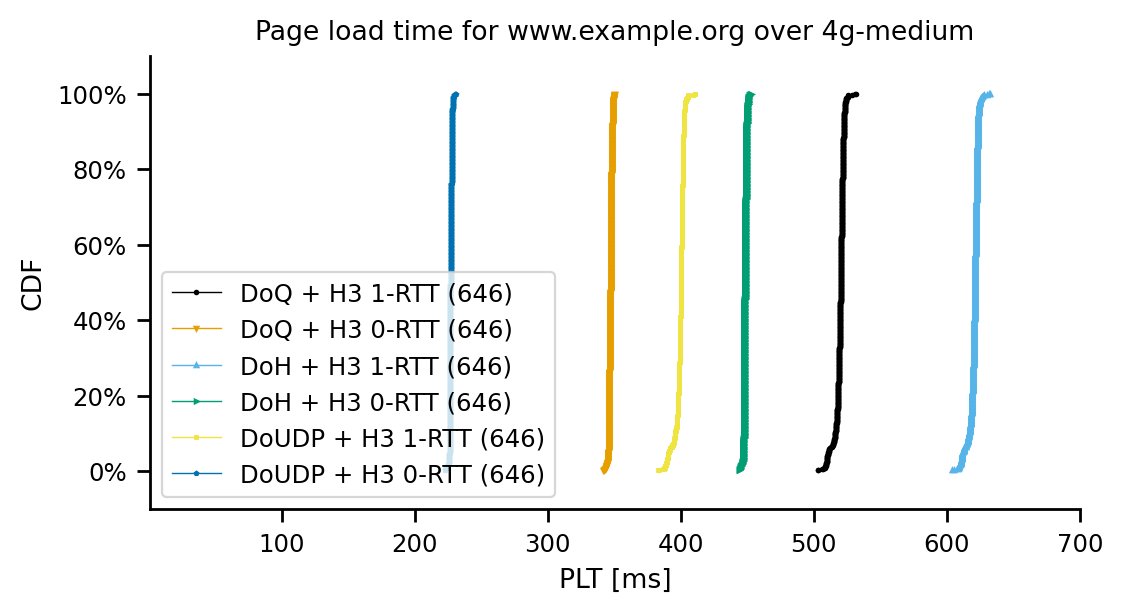

In [511]:
for access_technology in ['fiber', 'cable', 'dsl', '4g', '4g-medium']:
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in ['www.example.org']:
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=False
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                #print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(1,700)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

fiber


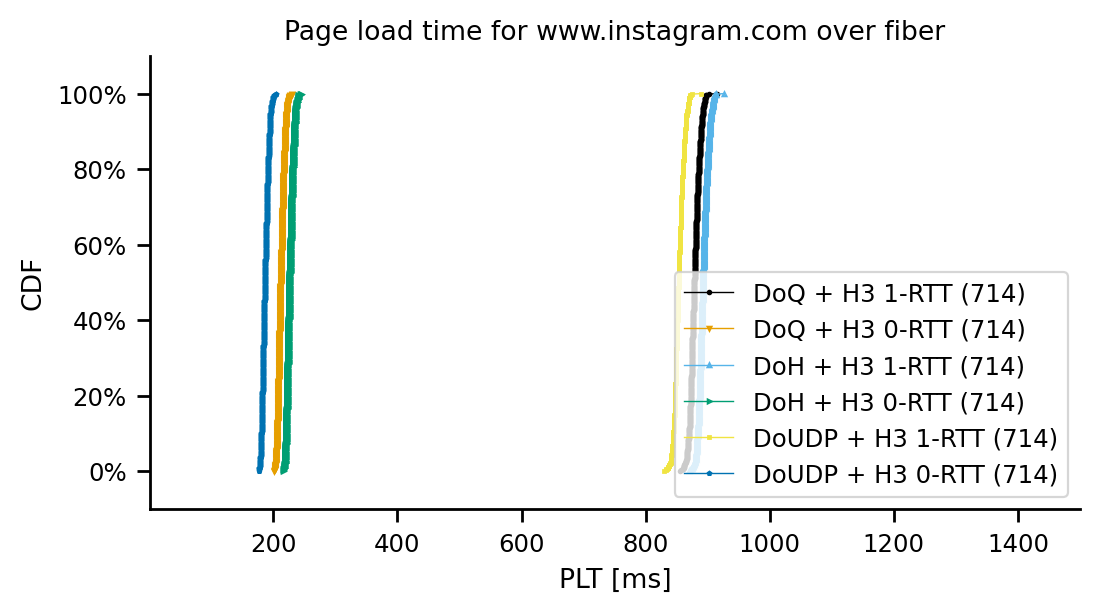

cable


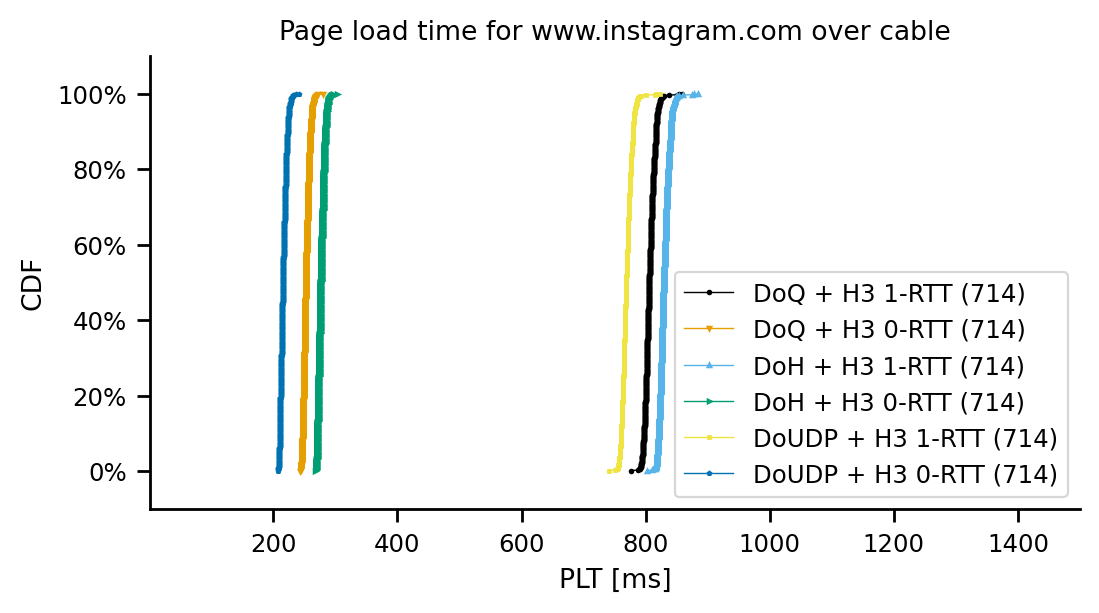

dsl


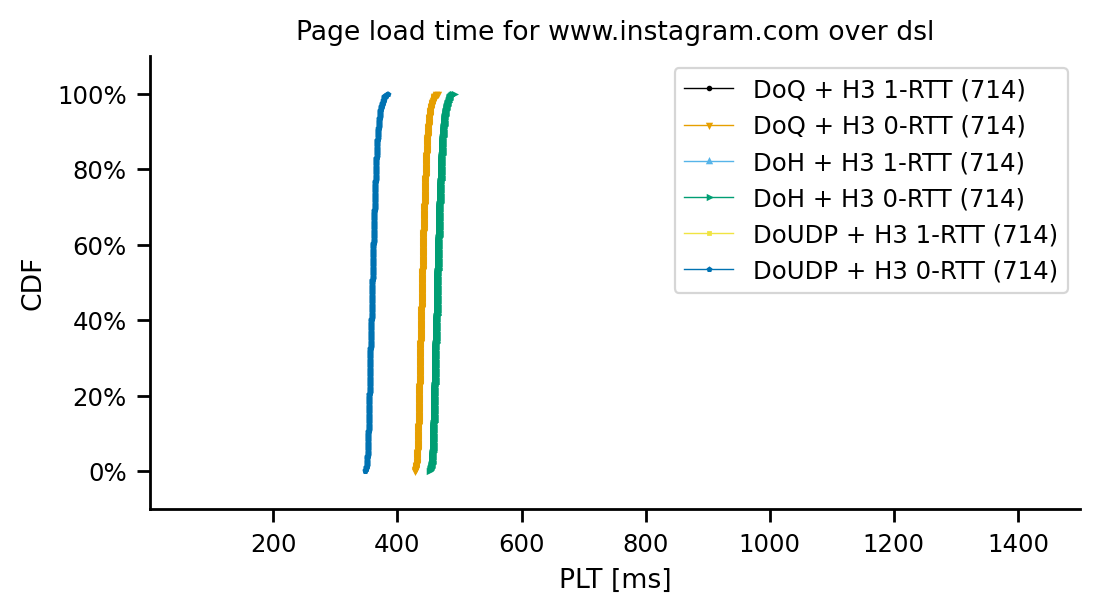

4g


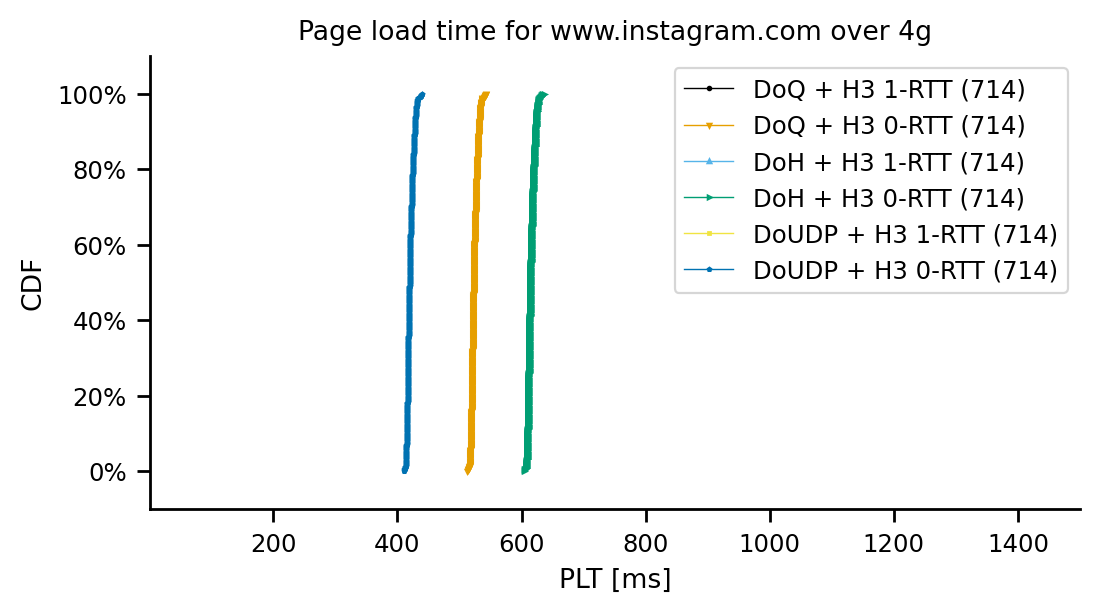

4g-medium


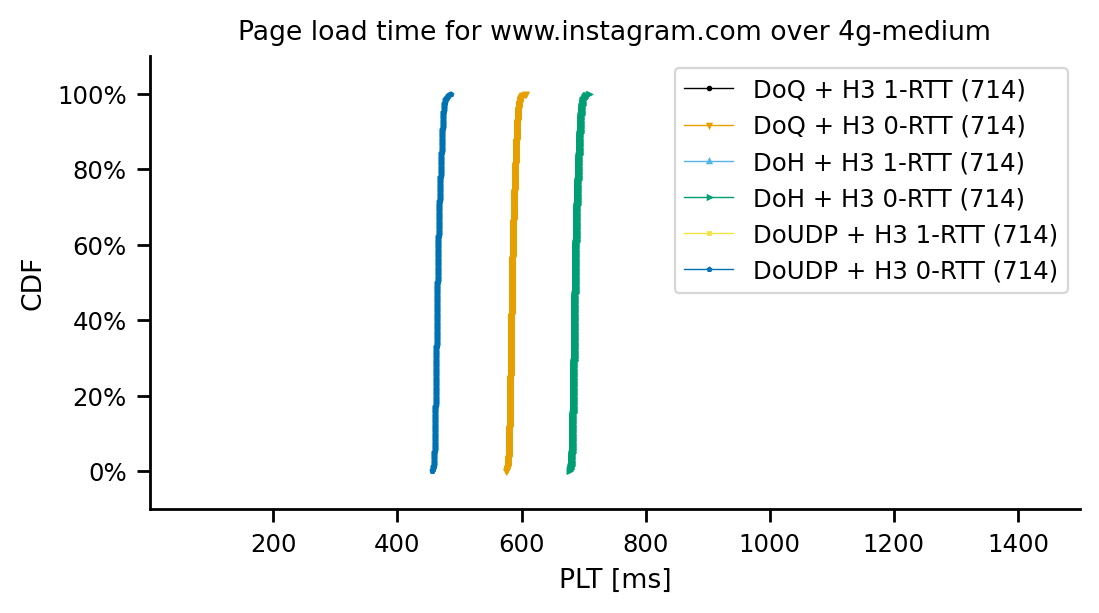

In [512]:
for access_technology in ['fiber', 'cable', 'dsl', '4g', '4g-medium']:
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_plt', 'experiment_description', 'website']].copy()
    for website in ['www.instagram.com']:
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=False
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_plt']) == 0:
                    continue
                #print(df_tmp['full_plt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_plt'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('Page load time for '+website+' over '+access_technology)

        ax.set_xlabel('PLT [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(1,1500)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [513]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].full_plt.describe(percentiles=[0.5, 0.6, 0.65])

count    645.000000
mean     240.487500
std       25.432113
min      216.338667
50%      223.393658
60%      226.296570
65%      255.850049
max      304.379689
Name: full_plt, dtype: float64

In [514]:
df_dns_and_h3.timestamp

0        2022-06-08_15_01_00
1        2022-06-08_15_01_00
2        2022-06-08_15_01_00
3        2022-06-08_15_01_00
4        2022-06-08_15_01_00
                ...         
60181    2022-06-15_17_09_35
60182    2022-06-15_17_09_35
60183    2022-06-15_17_09_35
60184    2022-06-15_17_09_35
60185    2022-06-15_17_09_35
Name: timestamp, Length: 60186, dtype: object

In [515]:
df_dns_and_h3.timestamp = pd.to_datetime(df_dns_and_h3.timestamp, format="%Y-%m-%d_%H_%M_%S")

count    409.000000
mean      97.253790
std        2.581921
min       91.800000
25%       95.500000
50%       97.100000
75%       98.700000
max      109.100000
Name: loadEventStart, dtype: float64
count    409.000000
mean     124.477517
std        0.688183
min      120.257623
25%      124.111886
50%      124.310064
75%      124.804961
max      126.221037
Name: elapsed, dtype: float64


<AxesSubplot:xlabel='timestamp'>

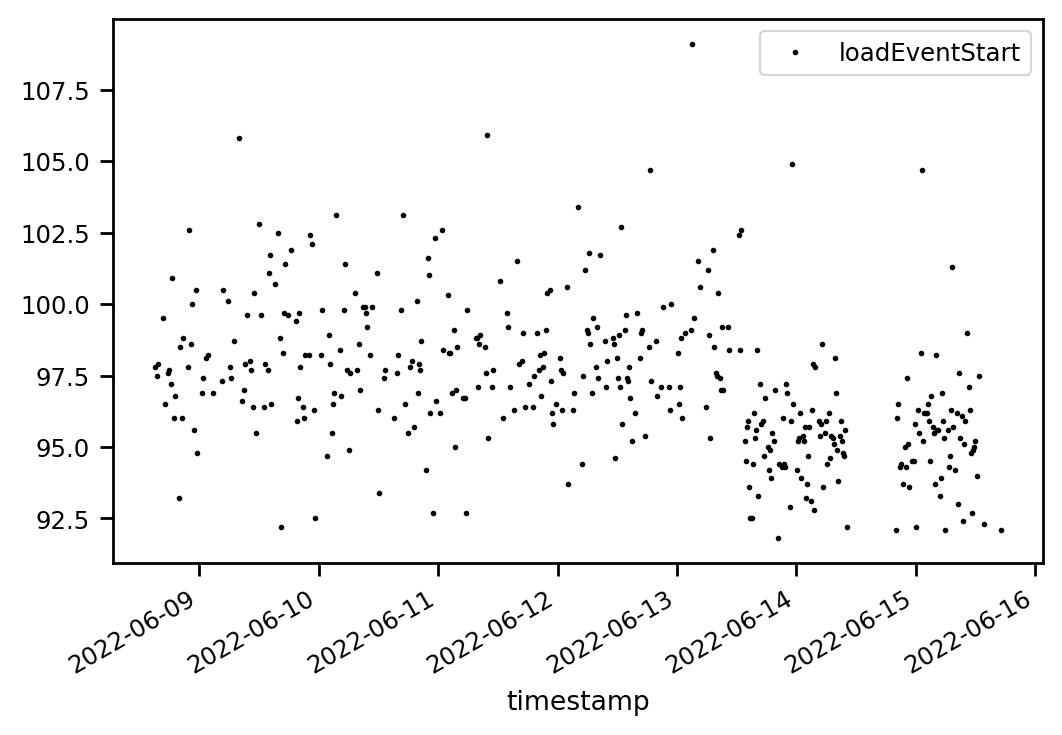

In [516]:
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].loadEventStart.describe())
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].elapsed.describe())
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt < 250)].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

count    236.000000
mean     148.416949
std        9.299094
min      127.000000
25%      143.550000
50%      148.550000
75%      154.875000
max      178.900000
Name: loadEventStart, dtype: float64
count    236.000000
mean     124.575987
std        0.698171
min      119.664892
25%      124.161133
50%      124.383130
75%      125.037642
max      126.377896
Name: elapsed, dtype: float64


<AxesSubplot:xlabel='timestamp'>

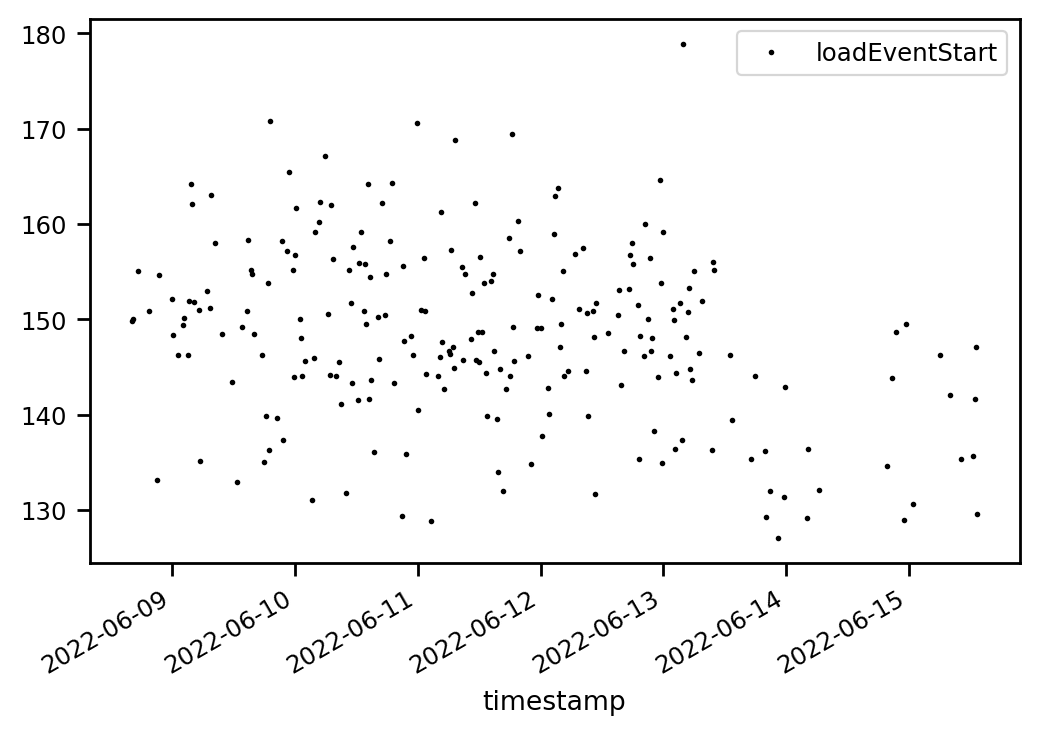

In [517]:
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].loadEventStart.describe())
print(df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].elapsed.describe())
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.full_plt >= 250)].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

<AxesSubplot:xlabel='timestamp'>

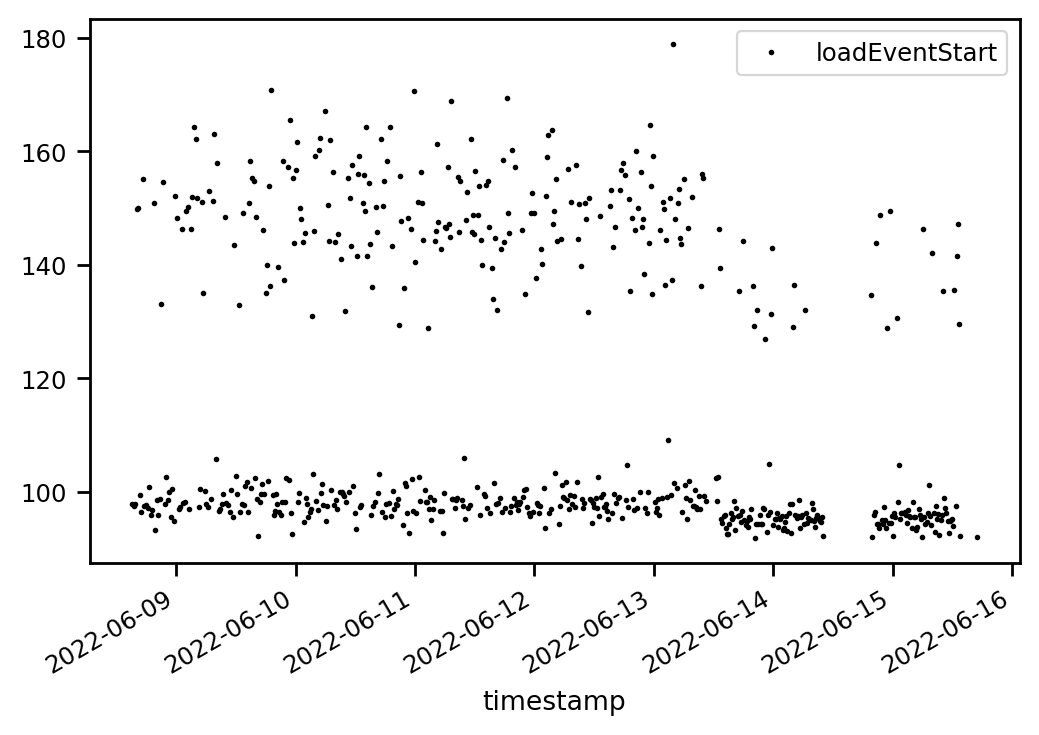

In [518]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'dsl') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

In [381]:
dsl_msms=['ea7f2f67-49aa-4b24-bbdb-2f579e93ae2d',
          '0db34220-adc4-47ca-98ef-b477b4546c70',
          '1a594a4d-7229-4b33-996a-86ac8ee8e87f',
          'a5bdf51b-6cf3-4b39-af48-7b3588b8fa32',
          '72f14b6a-778c-4aaa-ae6b-081b55eb1a3e',
          'd5c12acb-6c08-4aed-a30d-fe5177353e9a']
dsl_msms = ['40226da6-4e2e-41da-be00-ea3d8568b8ac',
           '0996f426-0b60-40bc-844b-59642efb5e88', 
           '834c4ab5-fffe-438b-9eba-ec294fca29e1']
df_dns_and_h3[(df_dns_and_h3.msm_id.isin(dsl_msms)) & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')][['msm_id', 'loadEventStart']]

msm_id  loadEventStart
18951  40226da6-4e2e-41da-be00-ea3d8568b8ac           150.2
19041  0996f426-0b60-40bc-844b-59642efb5e88           145.8
19131  834c4ab5-fffe-438b-9eba-ec294fca29e1            99.8

<AxesSubplot:xlabel='timestamp'>

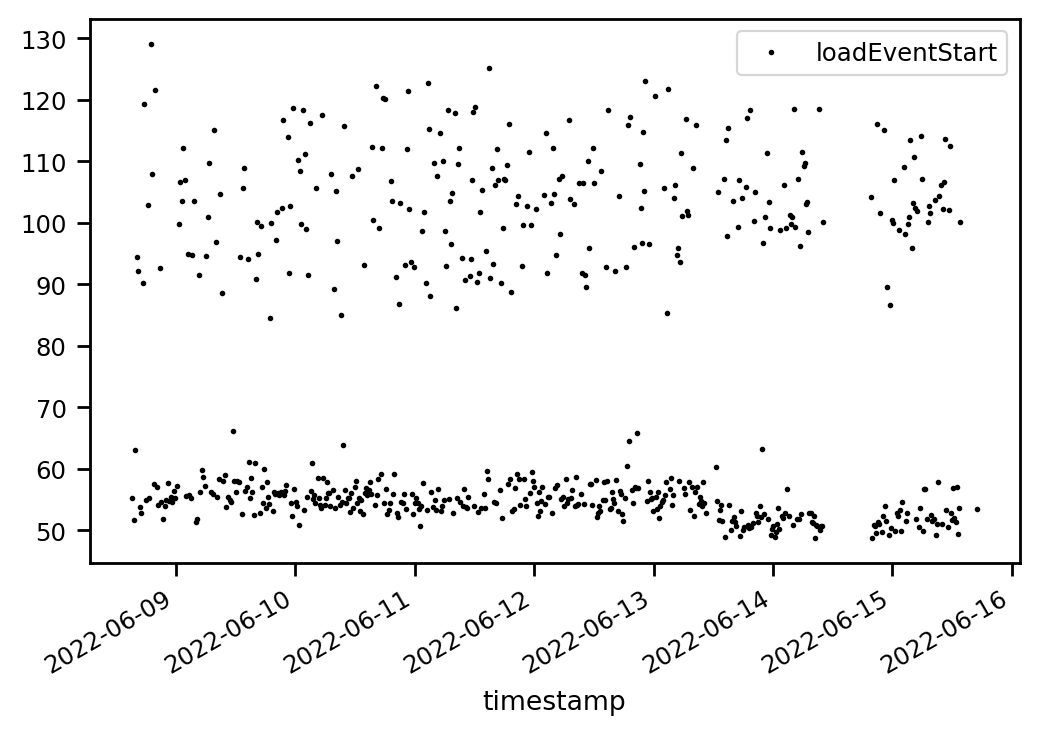

In [519]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'fiber') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

In [383]:
fiber_msms=['097f5c5a-70d2-4d49-9403-a8bcce09aac9', 
           '91f26e10-53cc-4c85-8e4c-401f37fbcb5b',
           '11893d09-c545-48eb-84cd-69336faf5ea1',
           '25cab733-fee7-4e82-af9c-8993f827f499',
           '6f4abddc-4822-4cfe-8019-ad1058cb8177',
           '52ad18c8-2f93-45fc-b6e0-ea6c6a589478']
fiber_msms=['80ffb3af-c2c9-4567-ba4a-7bcca408dff4',
           'b6131e76-734f-4ded-b907-006d00d19e6b',
           '8831ce97-936c-46b7-94bb-0199d9a53f00',
           '9e1ed825-d333-4bd9-9053-584d7079c31a']
df_dns_and_h3[(df_dns_and_h3.msm_id.isin(fiber_msms)) & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')][['msm_id', 'loadEventStart']]

msm_id  loadEventStart
18963  80ffb3af-c2c9-4567-ba4a-7bcca408dff4           122.2
19053  b6131e76-734f-4ded-b907-006d00d19e6b            55.7
19143  8831ce97-936c-46b7-94bb-0199d9a53f00            58.4
19233  9e1ed825-d333-4bd9-9053-584d7079c31a            99.1

<AxesSubplot:xlabel='timestamp'>

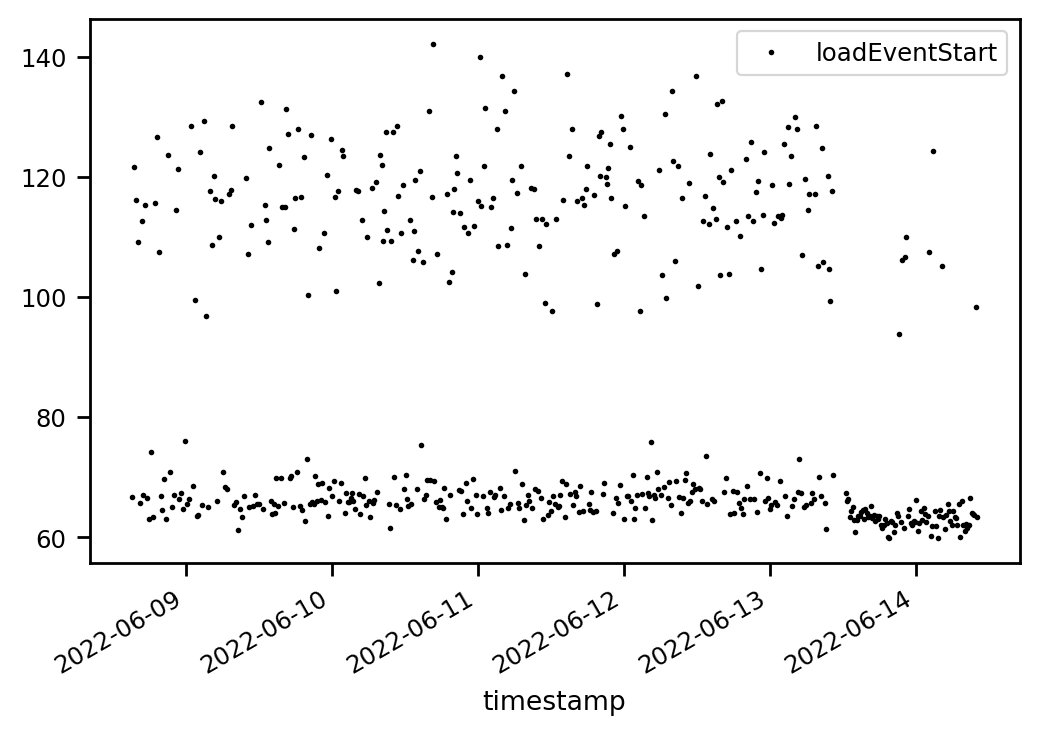

In [384]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == 'cable') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

In [385]:
cable_msms=['25043c95-126c-4a50-91f2-3a248f2840a1', 
           '1a674496-67b0-4f9b-953e-8753f95b0dc5',
           '39485fb3-aba4-4530-9069-c1aa2194c36d',
           'c0d8523a-aa0a-4df5-9889-5aa0c4db4b40',
           '37b9ac16-7359-4fa5-9e15-22a7bd8fa85a',
           '7e3fafbf-e74b-4365-9de0-553a276057ce']
df_dns_and_h3[(df_dns_and_h3.msm_id.isin(cable_msms)) & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')][['msm_id', 'loadEventStart']]

msm_id  loadEventStart
18147  25043c95-126c-4a50-91f2-3a248f2840a1            68.0
18237  1a674496-67b0-4f9b-953e-8753f95b0dc5           107.6
18327  39485fb3-aba4-4530-9069-c1aa2194c36d           120.9
18417  c0d8523a-aa0a-4df5-9889-5aa0c4db4b40            75.4
18507  37b9ac16-7359-4fa5-9e15-22a7bd8fa85a           105.8
18597  7e3fafbf-e74b-4365-9de0-553a276057ce            66.4

<AxesSubplot:xlabel='timestamp'>

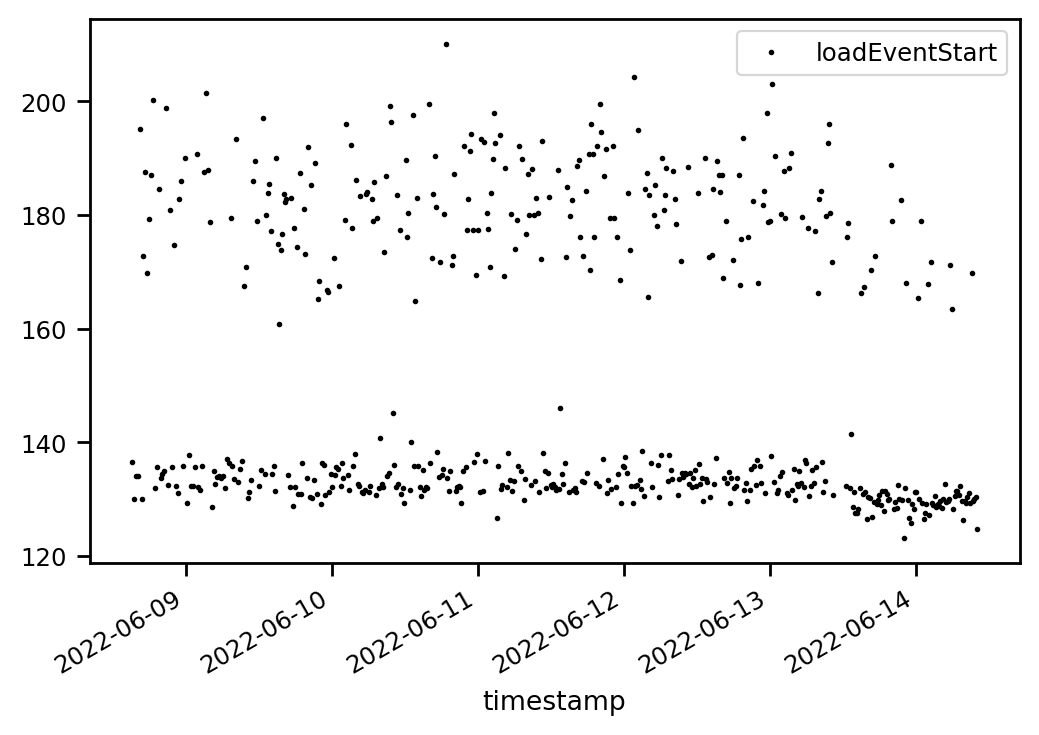

In [386]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == '4g') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

In [387]:
lte_msms=['76f85d7f-927c-47fd-a72a-f2f9bb36e393', 
           '494500df-6fa3-4ec1-8d0e-d86479dbfcc2',
           'd66574f5-2ef4-479c-9a53-d1e520c40e3b',
           '6462d64e-715f-41f8-8bf1-cbaae877b8ee',
           'c628eb84-a78a-401e-b29b-08f358592902',
           'cb5fe4a3-1fe7-4443-aa45-b598ba2ba0e3']
df_dns_and_h3[(df_dns_and_h3.msm_id.isin(lte_msms)) & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')][['msm_id', 'loadEventStart']]

msm_id  loadEventStart
18159  76f85d7f-927c-47fd-a72a-f2f9bb36e393           183.0
18249  494500df-6fa3-4ec1-8d0e-d86479dbfcc2           135.9
18339  d66574f5-2ef4-479c-9a53-d1e520c40e3b           132.2
18429  6462d64e-715f-41f8-8bf1-cbaae877b8ee           130.5
18519  c628eb84-a78a-401e-b29b-08f358592902           135.1
18609  cb5fe4a3-1fe7-4443-aa45-b598ba2ba0e3           131.6

<AxesSubplot:xlabel='timestamp'>

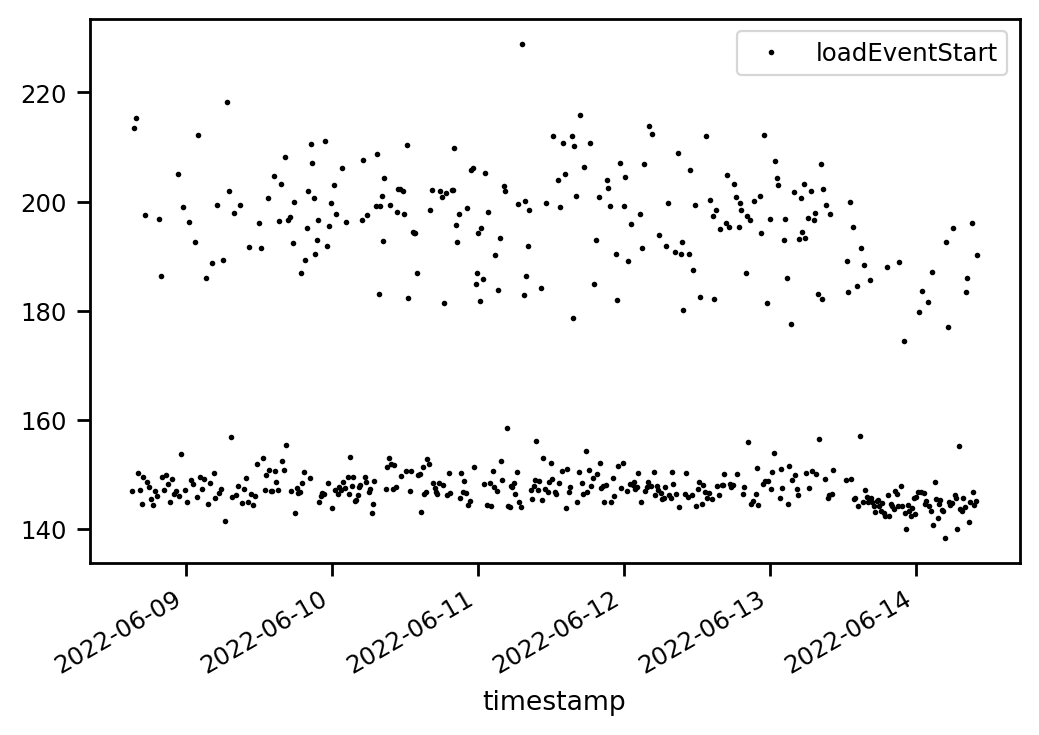

In [388]:
df_dns_and_h3[(df_dns_and_h3.website == 'www.wikipedia.org') & (df_dns_and_h3.experiment_type == '4g-medium') & (df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT')].set_index('timestamp').plot(y='loadEventStart', linewidth=0, markersize=2, color='C0', marker=".")

dsl
count    569.000000
mean     318.310562
std        5.093078
min      307.640989
10%      313.491331
20%      314.620288
25%      315.067562
30%      315.458755
40%      316.251140
50%      316.862024
60%      317.429138
70%      318.394939
75%      319.064029
80%      323.859838
90%      327.299120
100%     331.553237
max      331.553237
Name: full_fcp, dtype: float64
count    569.000000
mean     206.911792
std        3.547923
min      198.344235
10%      202.453126
20%      203.066602
25%      203.406072
30%      203.842969
40%      205.356611
50%      206.990417
60%      208.610935
70%      209.461344
75%      209.938769
80%      210.377469
90%      211.591216
100%     214.529399
max      214.529399
Name: full_fcp, dtype: float64
count    569.000000
mean     342.387257
std        5.080445
min      332.142713
10%      337.489993
20%      338.710895
25%      339.034613
30%      339.514972
40%      340.368387
50%      341.024353
60%      341.574536
70%      342.389432
75%      343.2

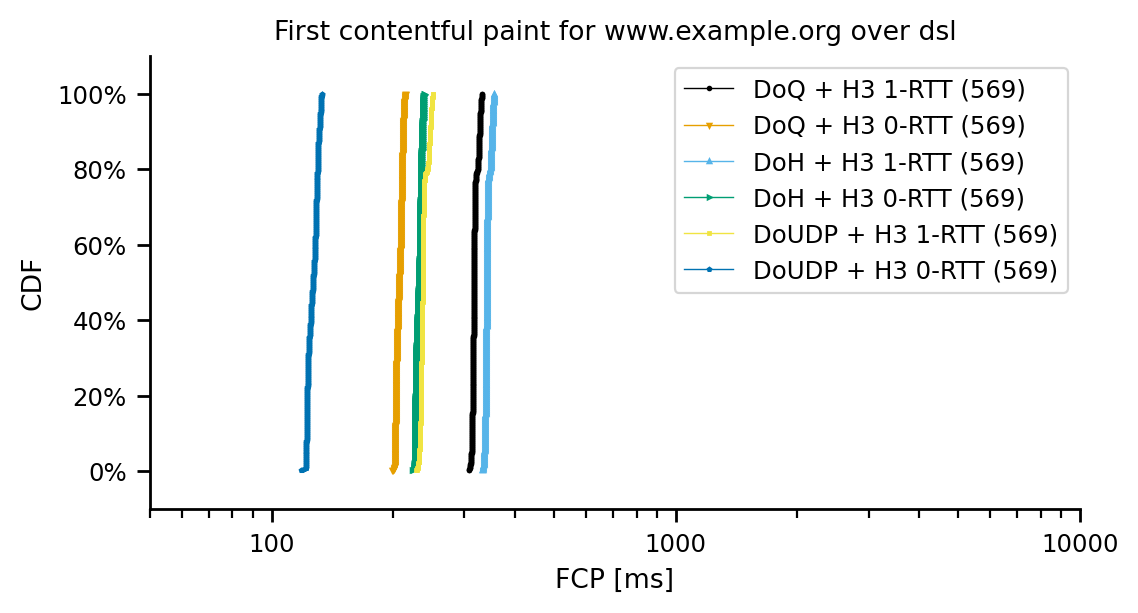

count    566.000000
mean     431.623560
std       41.050199
min      369.510295
10%      402.342387
20%      406.470329
25%      407.729272
30%      409.738431
40%      412.973353
50%      415.617513
60%      418.655914
70%      424.082039
75%      427.899691
80%      435.033365
90%      509.078152
100%     565.785710
max      565.785710
Name: full_fcp, dtype: float64
count    566.000000
mean     218.811192
std       19.181604
min      205.156004
10%      210.293525
20%      210.959287
25%      211.204531
30%      211.406537
40%      211.878143
50%      212.300330
60%      212.715418
70%      213.232776
75%      213.524683
80%      214.079401
90%      262.802915
100%     290.414390
max      290.414390
Name: full_fcp, dtype: float64
count    566.000000
mean     455.728640
std       41.052279
min      393.309129
10%      426.635620
20%      430.545550
25%      431.839239
30%      433.680885
40%      436.878973
50%      439.450654
60%      442.453944
70%      448.482786
75%      451.99092

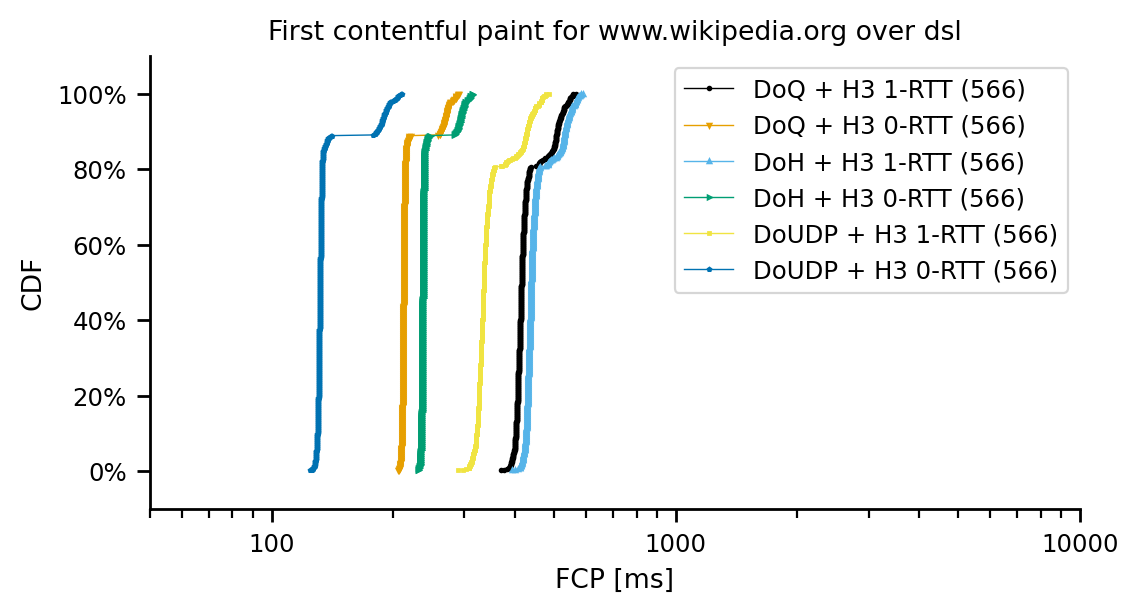

count    636.000000
mean     325.171955
std        7.667933
min      305.887292
10%      314.876397
20%      317.442763
25%      319.933244
30%      321.018600
40%      323.108127
50%      325.085545
60%      327.031859
70%      328.841208
75%      330.318603
80%      331.534954
90%      334.968001
100%     348.177519
max      348.177519
Name: full_fcp, dtype: float64
count    636.000000
mean     227.590981
std        6.549639
min      195.366226
10%      224.447465
20%      225.643515
25%      226.029528
30%      226.393107
40%      227.065401
50%      227.512537
60%      228.164748
70%      229.218593
75%      230.115728
80%      231.849870
90%      234.209966
100%     243.930432
max      243.930432
Name: full_fcp, dtype: float64
count    636.000000
mean     349.342631
std        7.742405
min      330.359431
10%      339.177178
20%      341.463013
25%      344.135235
30%      345.206184
40%      347.278143
50%      349.126792
60%      351.100200
70%      353.315354
75%      354.49195

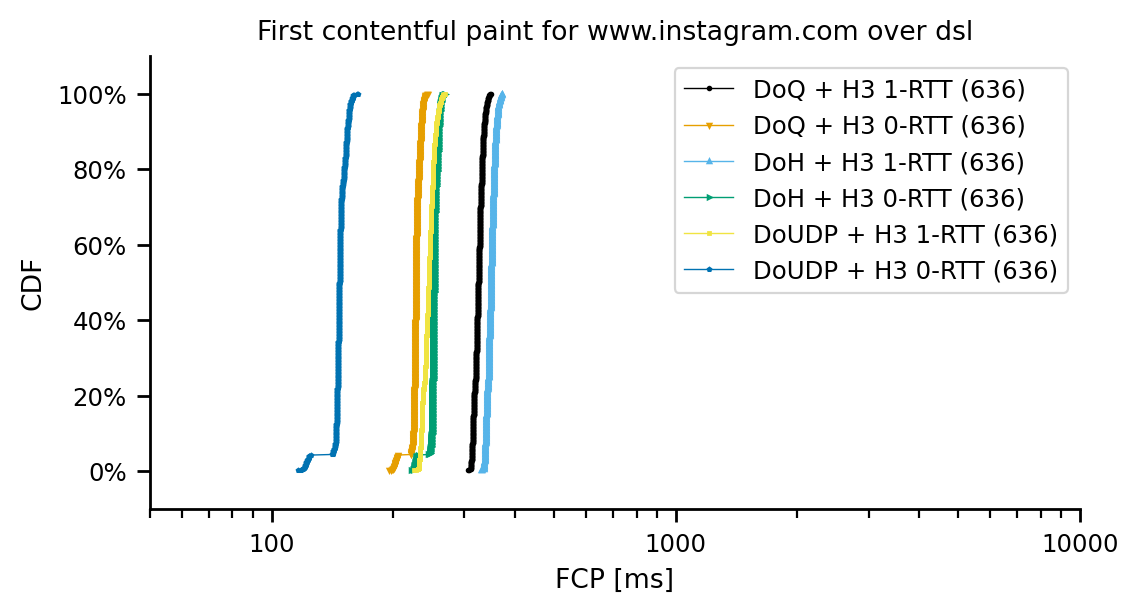

cable
count    569.000000
mean     201.175206
std        2.807357
min      190.960750
10%      197.645413
20%      199.155312
25%      199.676033
30%      200.062727
40%      200.694195
50%      201.305145
60%      201.856743
70%      202.367360
75%      202.744026
80%      203.102419
90%      204.046013
100%     215.063910
max      215.063910
Name: full_fcp, dtype: float64
count    569.000000
mean     113.607895
std        3.551512
min      103.967498
10%      108.778140
20%      109.756415
25%      110.345285
30%      110.994153
40%      112.448590
50%      113.918821
60%      115.131536
70%      116.119365
75%      116.584274
80%      117.129889
90%      118.333161
100%     120.848399
max      120.848399
Name: full_fcp, dtype: float64
count    569.000000
mean     224.693586
std        2.740118
min      214.849420
10%      221.482620
20%      222.742609
25%      223.165902
30%      223.605930
40%      224.215971
50%      224.803724
60%      225.409786
70%      225.911451
75%      226

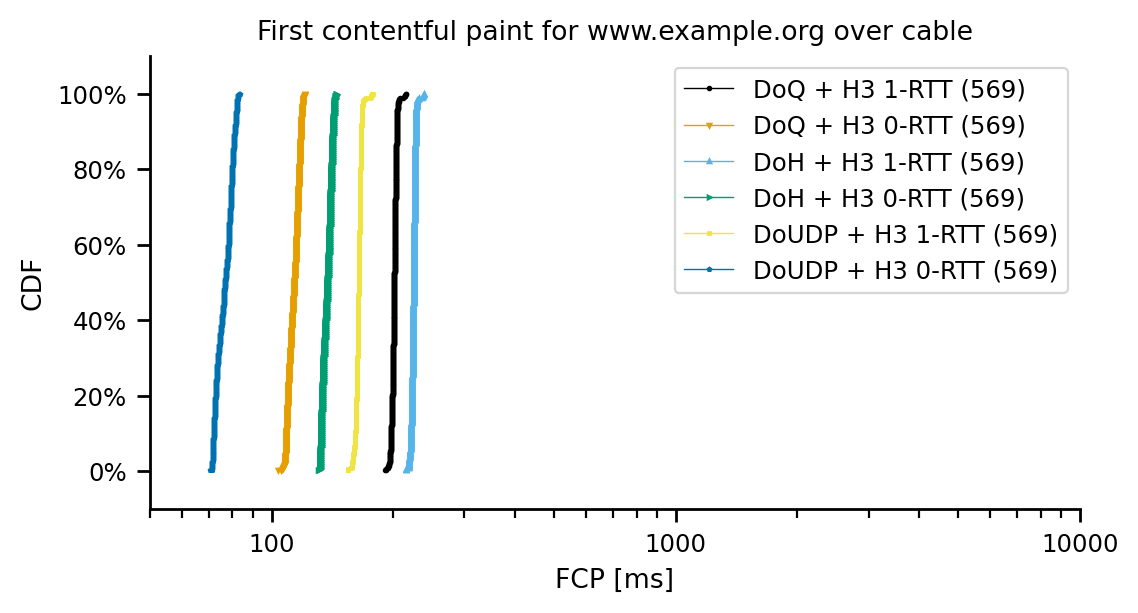

count    566.000000
mean     374.308552
std       54.738783
min      229.017521
10%      271.034468
20%      341.934015
25%      356.945072
30%      368.803681
40%      383.388415
50%      393.865476
60%      402.818996
70%      409.511759
75%      412.082853
80%      415.474390
90%      423.168941
100%     439.770384
max      439.770384
Name: full_fcp, dtype: float64
count    566.000000
mean     124.678340
std       18.180308
min      112.492455
10%      116.418300
20%      117.234423
25%      117.551758
30%      117.802195
40%      118.279040
50%      118.836548
60%      119.231387
70%      119.862242
75%      120.399652
80%      120.998786
90%      166.288113
100%     196.307501
max      196.307501
Name: full_fcp, dtype: float64
count    566.000000
mean     397.792091
std       54.744316
min      252.939776
10%      294.417618
20%      367.931643
25%      380.411120
30%      392.031685
40%      406.854568
50%      417.592360
60%      426.043421
70%      432.844101
75%      435.54043

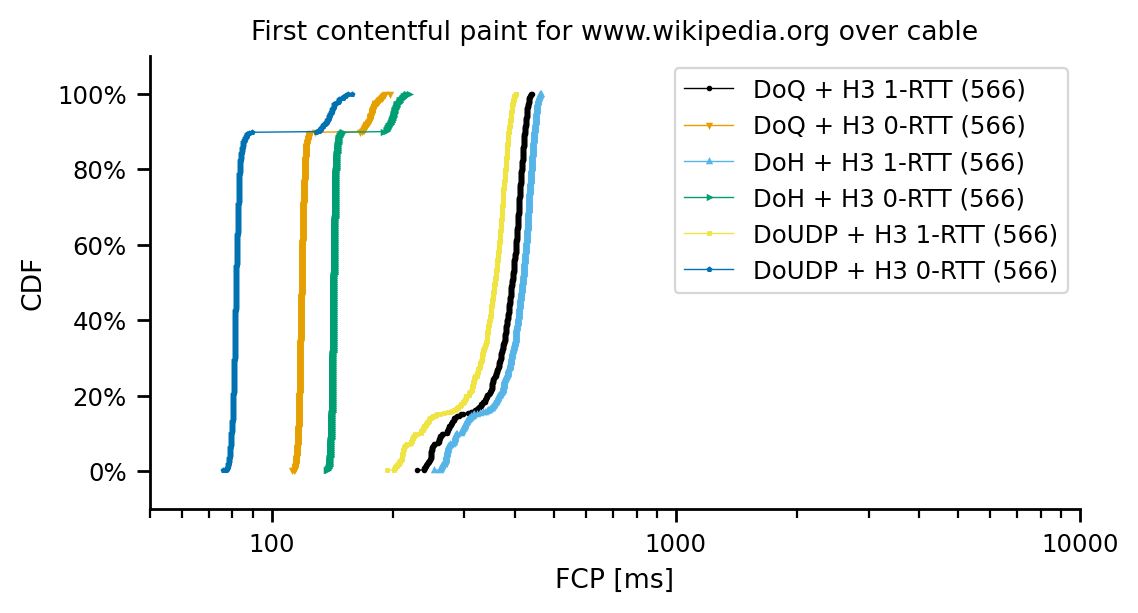

count    636.000000
mean     209.414675
std        5.974856
min      190.625722
10%      201.826616
20%      203.811679
25%      204.886155
30%      205.645373
40%      207.392915
50%      209.331276
60%      211.144926
70%      213.157558
75%      213.994075
80%      215.058296
90%      217.698036
100%     223.495194
max      223.495194
Name: full_fcp, dtype: float64
count    636.000000
mean     144.818763
std        4.773778
min      116.045122
10%      140.904618
20%      141.728961
25%      142.048387
30%      142.328016
40%      143.054465
50%      144.011432
60%      145.116761
70%      146.719127
75%      147.598028
80%      148.798939
90%      150.972413
100%     159.174647
max      159.174647
Name: full_fcp, dtype: float64
count    636.000000
mean     232.930920
std        5.904356
min      215.068540
10%      225.367733
20%      227.402978
25%      228.258854
30%      229.153752
40%      231.042308
50%      232.897768
60%      234.684689
70%      236.633704
75%      237.42000

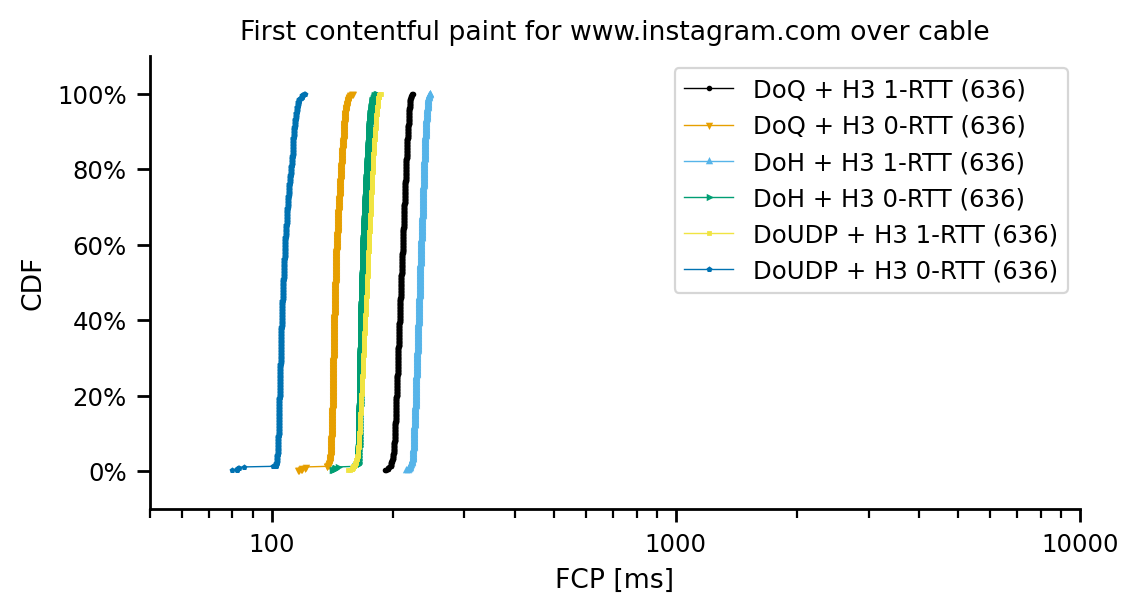

fiber
count    569.000000
mean     156.784031
std        3.124882
min      142.841638
10%      152.782155
20%      154.594300
25%      155.106735
30%      155.594264
40%      156.349799
50%      156.945335
60%      157.621871
70%      158.421073
75%      158.700595
80%      159.083301
90%      160.153265
100%     174.851301
max      174.851301
Name: full_fcp, dtype: float64
count    569.000000
mean      79.989655
std        3.441568
min       72.068326
10%       75.584484
20%       76.469679
25%       77.100595
30%       77.492553
40%       78.524129
50%       79.965351
60%       81.569931
70%       82.506418
75%       82.778144
80%       83.368893
90%       84.409804
100%      87.336389
max       87.336389
Name: full_fcp, dtype: float64
count    569.000000
mean     170.691983
std        2.962321
min      158.183457
10%      167.327530
20%      168.675771
25%      168.974044
30%      169.367959
40%      170.138038
50%      170.910920
60%      171.538108
70%      172.239217
75%      172

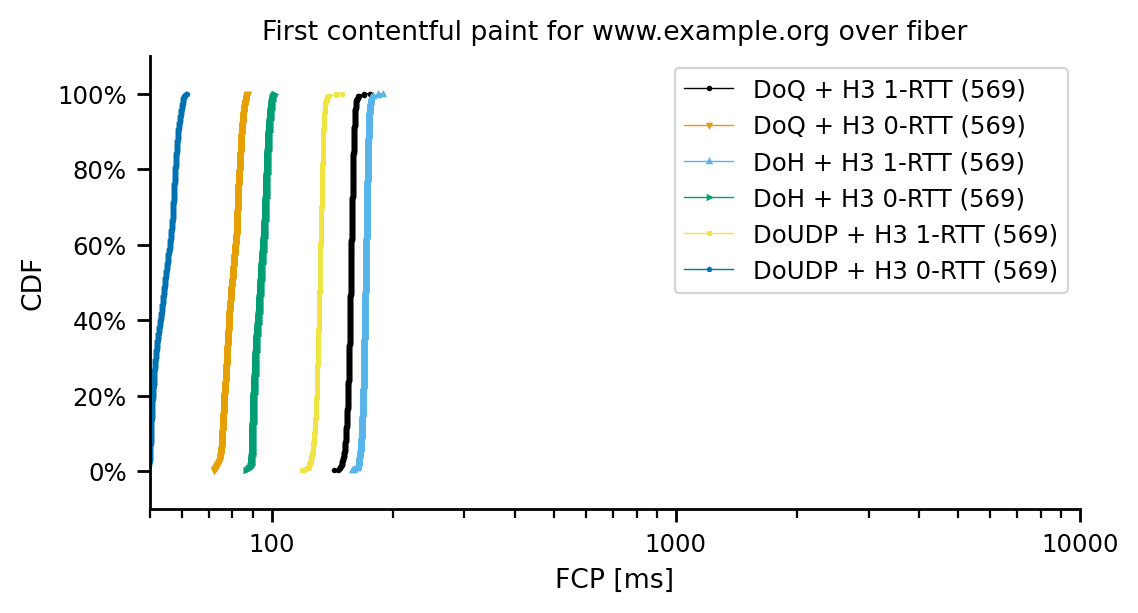

count    566.000000
mean     289.906946
std       69.691891
min      175.479093
10%      212.945236
20%      221.706849
25%      224.430991
30%      227.365872
40%      232.514501
50%      269.344537
60%      346.353162
70%      357.602003
75%      362.379431
80%      366.234449
90%      372.530509
100%     395.138135
max      395.138135
Name: full_fcp, dtype: float64
count    566.000000
mean      95.548995
std       22.600331
min       79.399204
10%       83.533467
20%       84.313091
25%       84.614772
30%       84.874141
40%       85.337736
50%       85.829236
60%       86.400575
70%       87.250678
75%       88.027064
80%       89.862599
90%      142.880084
100%     166.566470
max      166.566470
Name: full_fcp, dtype: float64
count    566.000000
mean     303.855583
std       69.694829
min      190.922238
10%      227.149596
20%      235.859797
25%      239.035310
30%      241.329781
40%      246.412075
50%      283.444681
60%      359.943758
70%      371.429034
75%      376.04985

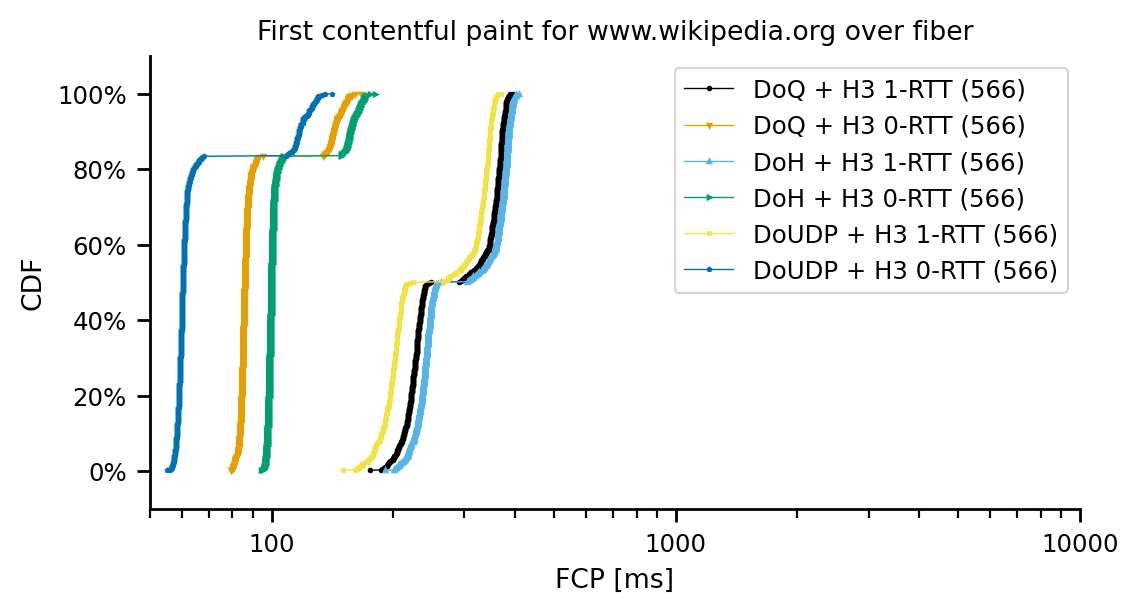

count    636.000000
mean     160.345149
std        7.254133
min      143.655755
10%      152.203560
20%      154.212520
25%      154.920499
30%      155.562355
40%      156.791334
50%      158.202644
60%      160.844243
70%      164.246384
75%      166.152612
80%      168.004389
90%      171.608298
100%     177.952500
max      177.952500
Name: full_fcp, dtype: float64
count    636.000000
mean     112.266533
std        4.741864
min       83.501656
10%      108.143231
20%      108.940785
25%      109.292459
30%      109.560347
40%      110.241615
50%      111.302694
60%      112.901041
70%      114.217781
75%      115.344443
80%      116.421875
90%      118.926089
100%     127.091829
max      127.091829
Name: full_fcp, dtype: float64
count    636.000000
mean     174.354970
std        7.113558
min      157.848122
10%      166.456277
20%      168.294821
25%      169.058100
30%      169.537620
40%      170.826811
50%      172.395572
60%      174.895482
70%      178.096879
75%      179.76840

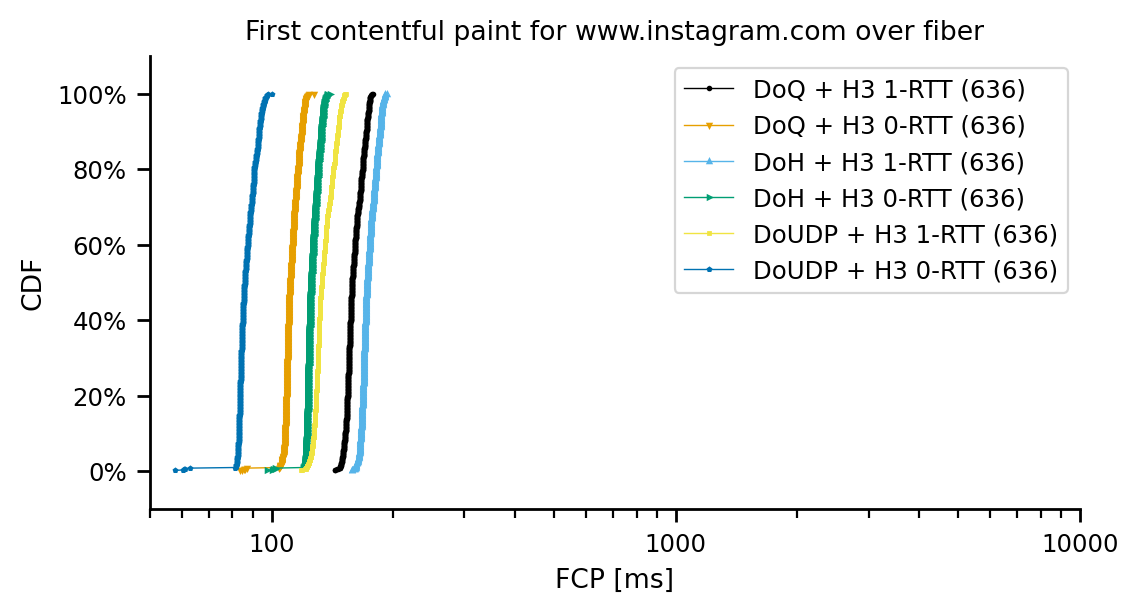

4g
count    567.000000
mean     468.284764
std        2.469471
min      454.545245
10%      465.291816
20%      466.513759
25%      466.829034
30%      467.196806
40%      467.781353
50%      468.375862
60%      468.881756
70%      469.611728
75%      469.941815
80%      470.252625
90%      470.932436
100%     480.153019
max      480.153019
Name: full_fcp, dtype: float64
count    567.000000
mean     312.738027
std        3.545618
min      303.973309
10%      308.264789
20%      309.124730
25%      309.559671
30%      309.986904
40%      311.066764
50%      312.525227
60%      314.198768
70%      315.416535
75%      315.869576
80%      316.361836
90%      317.553051
100%     320.791223
max      320.791223
Name: full_fcp, dtype: float64
count    567.000000
mean     559.079384
std        2.483223
min      545.159794
10%      556.093180
20%      557.316946
25%      557.764342
30%      558.045617
40%      558.743265
50%      559.291463
60%      559.707584
70%      560.276228
75%      560.63

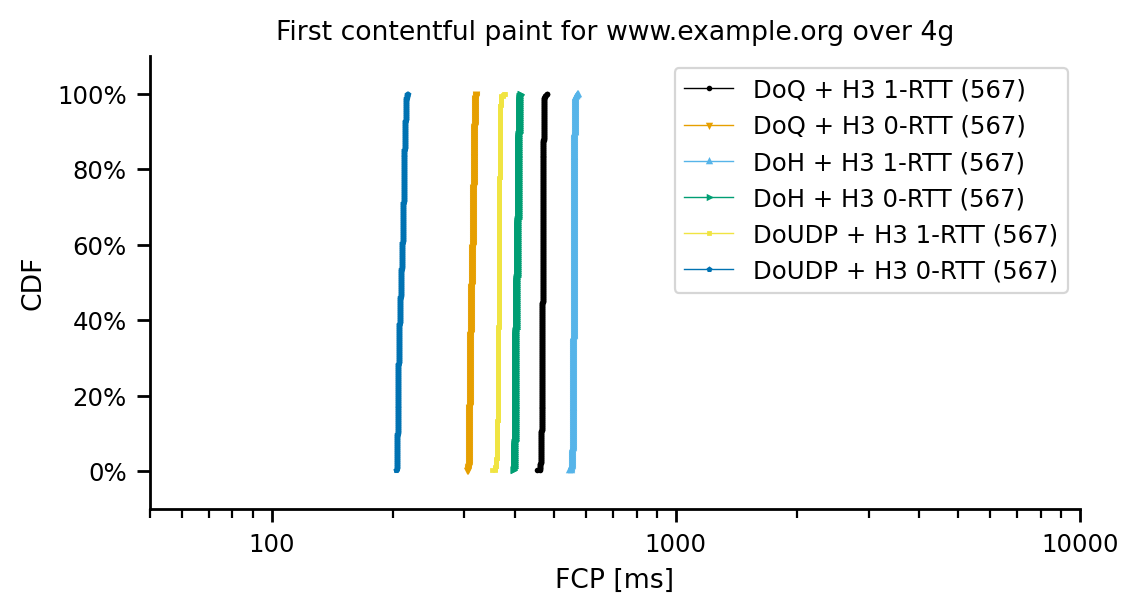

count    566.000000
mean     652.337521
std       44.537810
min      549.377387
10%      579.709476
20%      610.139733
25%      624.400615
30%      633.629358
40%      650.571717
50%      664.295074
60%      677.961959
70%      684.956176
75%      688.655292
80%      691.692706
90%      698.587725
100%     737.265302
max      737.265302
Name: full_fcp, dtype: float64
count    566.000000
mean     328.138228
std       22.524277
min      312.175976
10%      316.226727
20%      317.158417
25%      317.449240
30%      317.665224
40%      318.036093
50%      318.461229
60%      318.903878
70%      319.658756
75%      320.589668
80%      322.436111
90%      375.416351
100%     395.858335
max      395.858335
Name: full_fcp, dtype: float64
count    566.000000
mean     743.334001
std       44.505538
min      640.405496
10%      670.170826
20%      701.114906
25%      715.329064
30%      723.934159
40%      741.423579
50%      755.787083
60%      768.059584
70%      775.984384
75%      779.50228

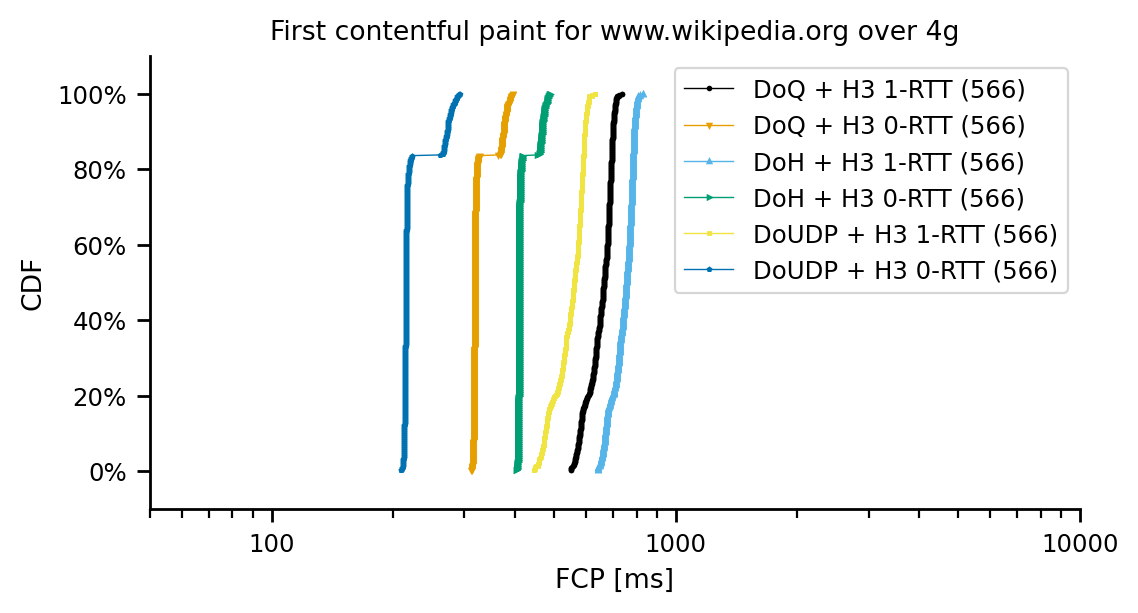

count    636.000000
mean     475.853487
std        5.556102
min      461.542245
10%      468.672243
20%      470.505424
25%      471.204700
30%      472.184090
40%      474.395293
50%      476.276717
60%      477.564572
70%      479.139177
75%      480.085940
80%      480.782224
90%      482.623497
100%     505.150812
max      505.150812
Name: full_fcp, dtype: float64
count    636.000000
mean     344.611349
std        6.149931
min      315.418507
10%      341.545295
20%      342.437396
25%      342.731924
30%      343.090864
40%      343.664261
50%      344.386198
60%      345.099688
70%      346.564846
75%      347.747282
80%      348.840103
90%      351.118721
100%     358.360783
max      358.360783
Name: full_fcp, dtype: float64
count    636.000000
mean     566.777962
std        5.576767
min      550.900430
10%      559.764183
20%      561.469914
25%      562.390301
30%      563.074324
40%      565.336111
50%      566.974179
60%      568.397867
70%      570.061020
75%      570.78165

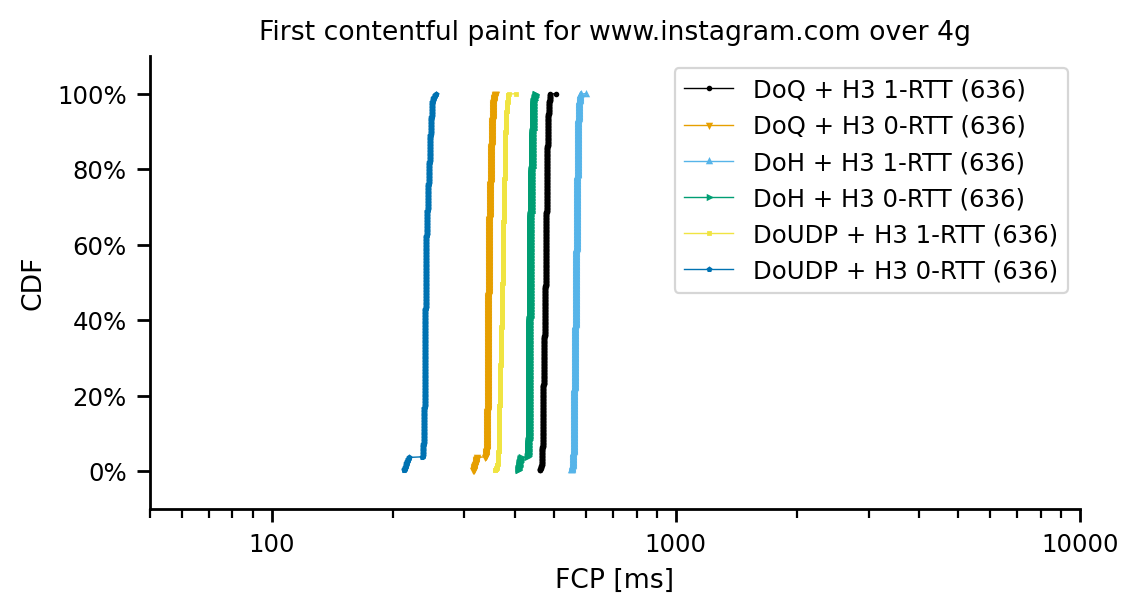

4g-medium
count    567.000000
mean     525.662878
std        2.744090
min      515.119072
10%      522.463548
20%      523.758106
25%      524.209212
30%      524.612315
40%      525.264111
50%      525.830909
60%      526.355107
70%      526.806811
75%      527.137594
80%      527.539834
90%      528.341403
100%     540.667577
max      540.667577
Name: full_fcp, dtype: float64
count    567.000000
mean     356.887922
std        3.481213
min      350.952996
10%      352.453649
20%      353.088668
25%      353.518624
30%      354.050651
40%      355.320471
50%      357.079979
60%      358.422254
70%      359.329122
75%      359.807039
80%      360.312581
90%      361.726303
100%     364.108217
max      364.108217
Name: full_fcp, dtype: float64
count    567.000000
mean     626.649825
std        2.740899
min      616.940092
10%      623.376134
20%      624.753750
25%      625.200964
30%      625.581045
40%      626.217978
50%      626.828335
60%      627.354774
70%      627.804895
75%     

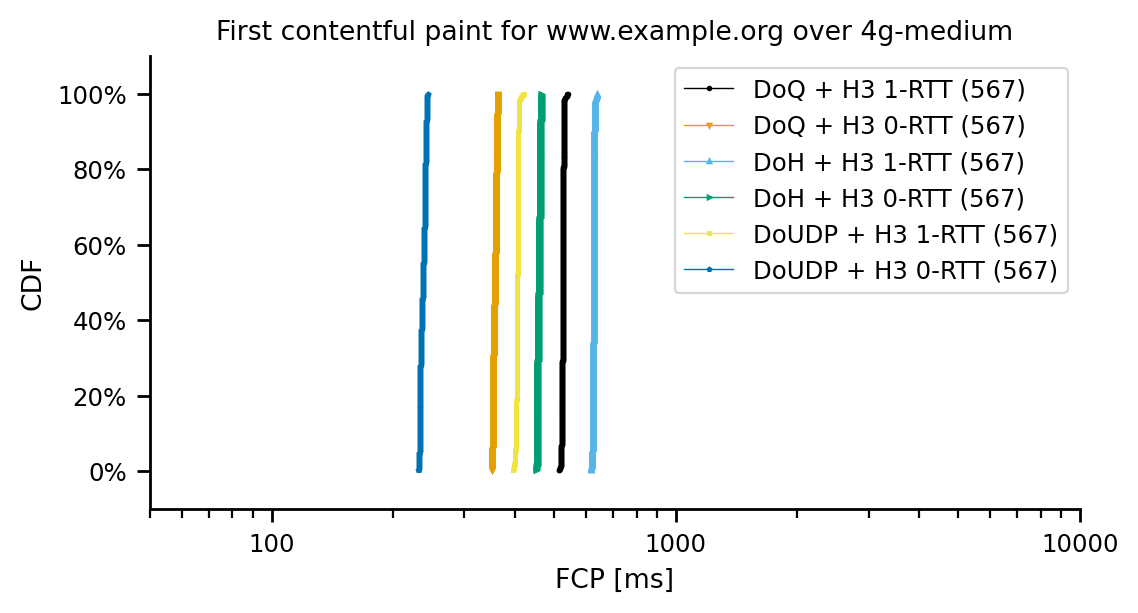

count    566.000000
mean     699.330862
std       32.379993
min      618.650643
10%      649.242918
20%      668.137790
25%      676.156260
30%      687.442076
40%      699.036722
50%      706.448041
60%      711.499417
70%      717.180120
75%      720.179400
80%      723.166646
90%      736.173233
100%     780.589671
max      780.589671
Name: full_fcp, dtype: float64
count    566.000000
mean     371.652240
std       21.632066
min      357.083906
10%      360.644652
20%      361.410511
25%      361.730928
30%      361.907433
40%      362.277727
50%      362.725656
60%      363.202158
70%      363.848548
75%      364.444920
80%      365.586073
90%      418.840916
100%     445.897619
max      445.897619
Name: full_fcp, dtype: float64
count    566.000000
mean     800.369118
std       32.408109
min      722.284683
10%      749.693236
20%      769.291385
25%      777.477345
30%      788.145959
40%      800.372377
50%      807.418139
60%      812.687927
70%      817.864479
75%      821.20648

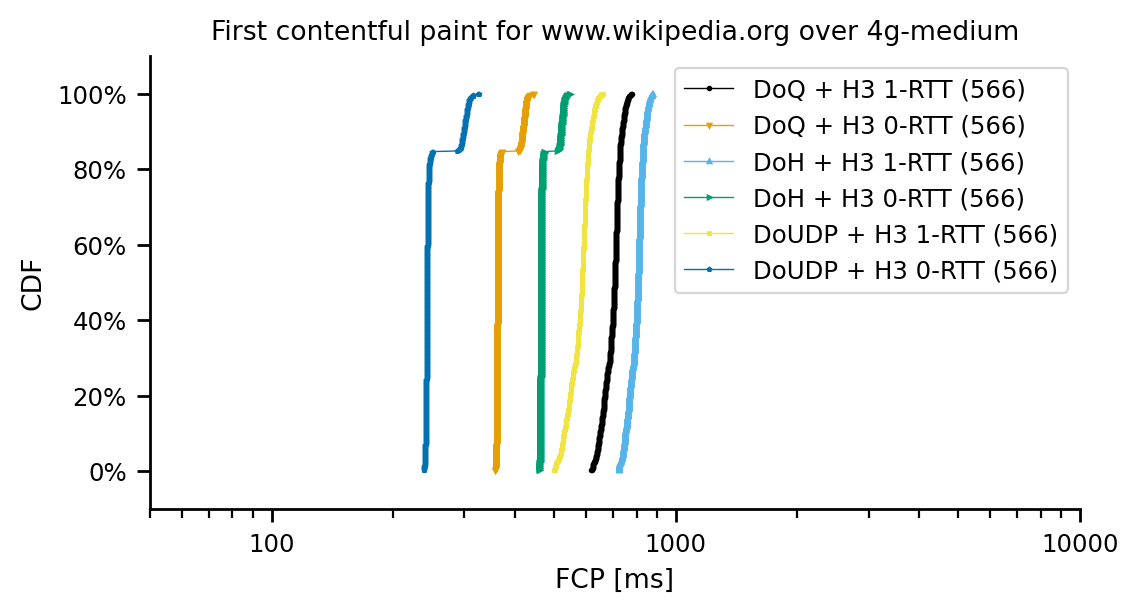

count    636.000000
mean     535.072368
std        4.604883
min      520.266815
10%      528.755664
20%      530.466320
25%      531.336265
30%      532.318935
40%      534.010848
50%      535.556274
60%      536.923390
70%      538.067225
75%      538.559606
80%      539.244451
90%      540.899660
100%     549.306469
max      549.306469
Name: full_fcp, dtype: float64
count    636.000000
mean     387.167808
std        6.899691
min      356.364566
10%      384.012297
20%      385.238424
25%      385.595469
30%      385.917637
40%      386.461145
50%      387.028932
60%      387.824812
70%      388.984222
75%      390.174726
80%      391.693168
90%      394.328779
100%     401.674811
max      401.674811
Name: full_fcp, dtype: float64
count    636.000000
mean     636.055147
std        4.638741
min      622.866777
10%      629.713765
20%      631.514733
25%      632.149537
30%      633.064466
40%      634.921792
50%      636.532285
60%      637.882816
70%      639.131471
75%      639.72842

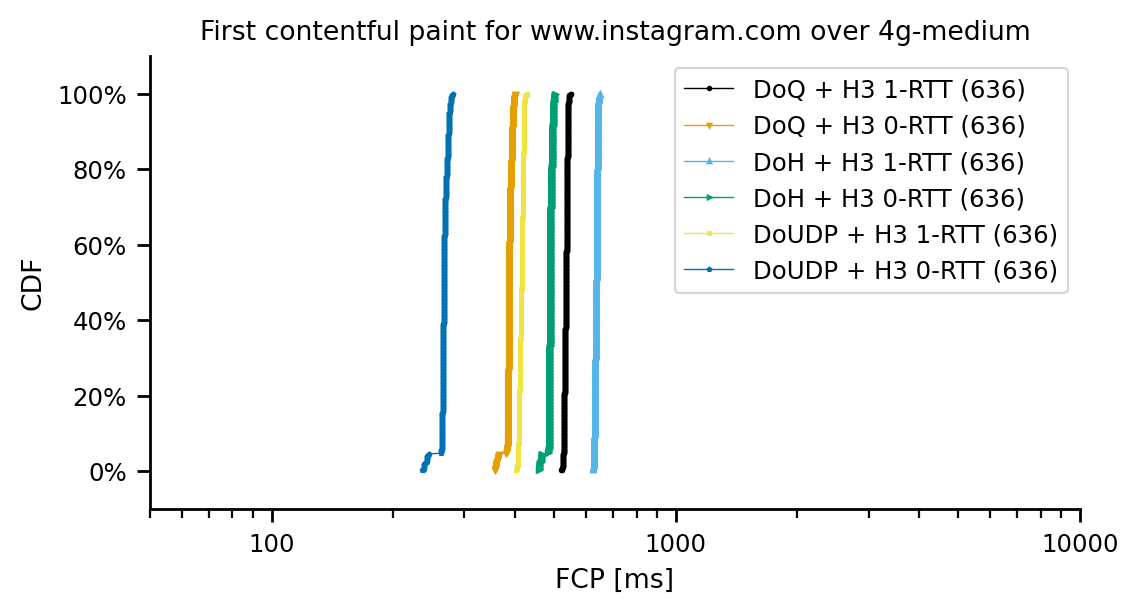

In [389]:
for access_technology in df_dns_and_h3.experiment_type.unique():
    print(access_technology)
    df_plt = df_dns_and_h3[df_dns_and_h3.experiment_type == access_technology][['full_fcp', 'experiment_description', 'website']].copy()
    for website in df_plt['website'].unique():
        fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
        line_order = ['DoQ + H3 1-RTT', 'DoQ + H3 0-RTT', 'DoH + H3 1-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 1-RTT', 'DoUDP + H3 0-RTT']
        colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
        markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))

        lnwidth = 0.5
        mrksize = 1
        log=True
        for experiment in line_order:
                df_tmp = df_plt[(df_plt.experiment_description == experiment) & (df_plt.website == website)]
                if len(df_tmp['full_fcp']) == 0:
                    continue
                print(df_tmp['full_fcp'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

                dfplt = make_cdf(df_tmp['full_fcp'])
                dfplt.plot(ax=ax, label=experiment+" ("+str(len(df_tmp))+")", marker=markers[experiment], markersize=mrksize, drawstyle="default", color=colors[experiment], linestyle='-', linewidth=lnwidth, logx=log)

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')


        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')


        ax.set_title('First contentful paint for '+website+' over '+access_technology)

        ax.set_xlabel('FCP [ms]')

        ax.set_ylabel("CDF")
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(50,10000)


        ax.legend()

        #if log:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
        #else:
        #    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [390]:
df_dns_and_h3.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoUDP + H3 1-RTT',
       'DoQ + H3 0-RTT', 'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'],
      dtype=object)

In [391]:
df_diff_plt_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_plt'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_udp.columns)
            df_diff_plt_udp = df_diff_plt_udp.append(next_df_series, ignore_index=True)
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.634956       34.842599       45.267388             dsl   
1       -51.689103       17.337700       22.526885             dsl   
2       -90.430381        1.754970        2.281210             dsl   
3       -34.786408       23.328361       38.158032           cable   
4       -65.496404        9.683123       15.868370           cable   
5       -67.140907        4.821315        7.877455           cable   
6       -41.092527       21.327226       32.965998           fiber   
7       -70.648672        7.458996       11.723209           fiber   
8       -75.156053        2.966877        4.601788           fiber   
9       -15.674316       28.765648       54.073062              4g   
10      -51.824403       15.051493       28.235441              4g   
11      -70.742512        5.791563       10.890422              4g   
12      -13.243224       29.973095       55.229984       4g-medium   
13      -48.470637       16.471603       30.348501       4g-medium   
14      -76.629480        4.802176        8.835061       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [392]:
df_diff_plt_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_plt'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_plt'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_plt_quic.columns)
            df_diff_plt_quic = df_diff_plt_quic.append(next_df_series, ignore_index=True)
df_diff_plt_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          17.143969       57.959972       70.171983             dsl   
1         106.992640      142.880402      153.621633             dsl   
2         944.973646      963.312615      968.811690             dsl   
3          53.342267       89.114505      111.854658           cable   
4         189.824866      217.888965      235.815349           cable   
5         204.329765      219.002462      228.303204           cable   
6          69.757750      105.962368      125.720086           fiber   
7         240.700091      266.112896      280.641076           fiber   
8         302.512531      314.454584      321.035305           fiber   
9          18.587831       52.700389       82.711902              4g   
10        107.573972      138.816955      166.183399              4g   
11        241.792845      261.587992      279.015527              4g   
12         15.264772       49.813191       78.925487       4g-medium   
13         94.064110      126.029580      152.959658       4g-medium   
14        327.889495      348.437503      365.693793       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [393]:
df_diff_fcp_udp = pd.DataFrame(columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_udp = df_website[df_website['experiment_description'] == 'DoUDP + H3 1-RTT'].copy()
        median_udp = df_udp['full_fcp'].median()
        if median_udp is not np.nan:
            next_df_row = []
            for protocol in ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_udp/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_udp.columns)
            df_diff_fcp_udp = df_diff_fcp_udp.append(next_df_series, ignore_index=True)
df_diff_fcp_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -12.486626       33.965936       44.181515             dsl   
1       -36.622755       24.072785       31.187606             dsl   
2        -7.012214       32.867338       42.693356             dsl   
3       -30.645349       22.556114       36.862229           cable   
4       -66.699020       10.370979       17.019846           cable   
5       -16.507336       21.362767       35.025774           cable   
6       -39.222430       19.286116       29.900642           fiber   
7       -64.864548       10.260121       16.032221           fiber   
8       -16.376494       18.860193       29.523569           fiber   
9       -14.356034       28.353051       53.267432              4g   
10      -43.242364       18.393747       34.699877              4g   
11       -7.597925       27.789549       52.124536              4g   
12      -12.017826       29.561300       54.446406       4g-medium   
13      -38.138195       20.482657       37.702813       4g-medium   
14       -6.842279       28.908198       53.213087       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [394]:
df_diff_fcp_quic = pd.DataFrame(columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'experiment_type', 'website'])
for access_technology in df_dns_and_h3['experiment_type'].unique():
    df_access_tech = df_dns_and_h3[df_dns_and_h3['experiment_type'] == access_technology].copy()
    for website in df_access_tech['website'].unique():
        df_website = df_access_tech[df_access_tech['website'] == website].copy()
        df_baseline = df_website[df_website['experiment_description'] == 'DoQ + H3 0-RTT'].copy()
        median_baseline = df_baseline['full_fcp'].median()
        if median_baseline is not np.nan:
            next_df_row = []
            for protocol in ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']:
                df_protocol = df_website[df_website['experiment_description'] == protocol].copy()
                median_protocol = df_protocol['full_fcp'].median()
                #minimize floating point errors I guess?
                increase = (median_protocol/(median_baseline/100))-100
                if increase is np.nan:
                    increase = 0
                next_df_row.append(increase)
            next_df_row.append(access_technology)
            next_df_row.append(website)
            next_df_series = pd.Series(next_df_row, index = df_diff_fcp_quic.columns)
            df_diff_fcp_quic = df_diff_fcp_quic.append(next_df_series, ignore_index=True)
df_diff_fcp_quic

DoUDP + H3 1-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0          14.268248       53.080528       64.753691             dsl   
1          57.785337       95.768662      106.994805             dsl   
2           7.541006       42.886871       53.453870             dsl   
3          44.186437       76.709294       97.336772           cable   
4         200.291467      231.434631      251.400613           cable   
5          19.771002       45.357401       61.721721           cable   
6          64.534383       96.266674      113.731220           fiber   
7         184.612820      213.814440      230.242577           fiber   
8          19.583602       42.137300       54.888949           fiber   
9          16.762459       49.868178       78.958821              4g   
10         76.187746      108.595274      137.324677              4g   
11          8.222678       38.297272       64.633247              4g   
12         13.659388       47.258581       75.542840       4g-medium   
13         61.650635       94.760980      122.597471       4g-medium   
14          7.344832       38.376289       64.466331       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

DoQ + H3 0-RTT
count    15.000000
mean    -52.510666
std      24.453900
min     -90.430381
10%     -76.040109
20%     -71.625220
25%     -70.695592
30%     -69.947119
40%     -66.154205
50%     -51.824403
60%     -50.401717
70%     -42.568149
75%     -37.939468
80%     -30.963990
90%     -15.050700
100%    -13.243224
max     -13.243224
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     14.958450
std      10.764284
min       1.754970
10%       3.700997
20%       4.817487
25%       5.306439
30%       6.125049
40%       8.793472
50%      15.051493
60%      16.818042
70%      20.529321
75%      22.327793
80%      24.415819
90%      29.490116
100%     34.842599
max      34.842599
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     24.592187
std      17.717236
min       2.281210
10%       5.912055
20%       8.643540
25%       9.862741
30%      11.056979
40%      14.210306
50%      22.526885
60%      29.080665
70%      32.442498
75%    

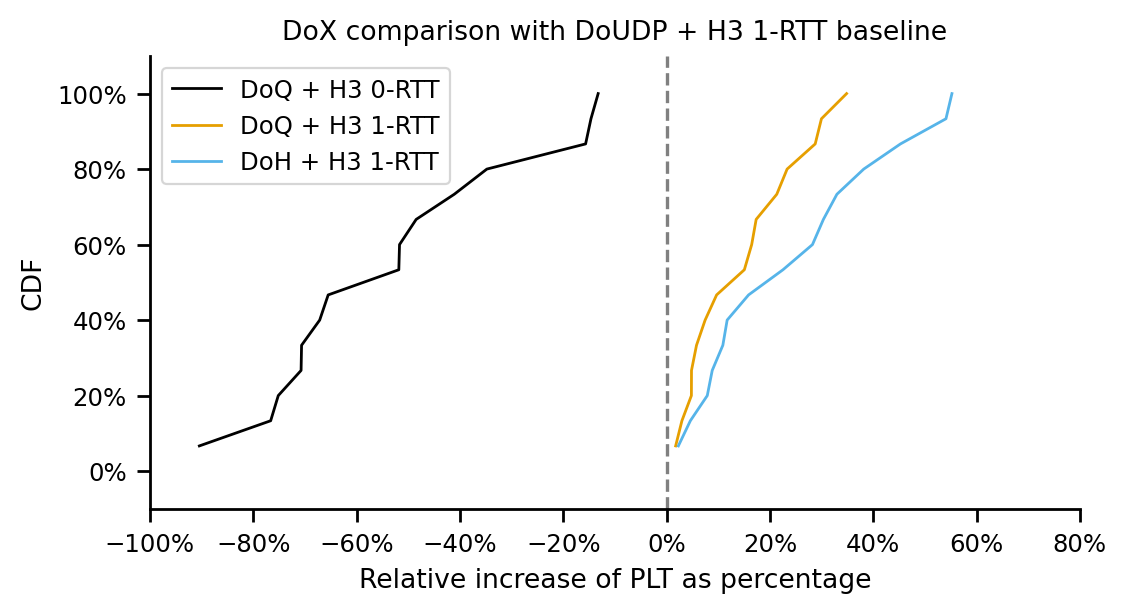

In [395]:
df_tmp = df_diff_plt_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean     195.650037
std      231.833154
min       15.264772
10%       17.721514
20%       46.391380
25%       61.550009
30%       74.619022
40%      101.821228
50%      107.573972
60%      195.626826
70%      233.426026
75%      241.246468
80%      253.936782
90%      317.738709
100%     944.973646
max      944.973646
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean     223.604959
std      226.197103
min       49.813191
10%       54.804222
20%       82.883599
25%       97.538437
30%      109.975811
40%      133.702005
50%      142.880402
60%      218.334364
70%      253.070886
75%      263.850444
80%      275.781234
90%      334.844335
100%     963.312615
max      963.312615
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     241.430983
std      221.411545
min       70.171983
10%       80.440053
20%      106.026107
25%      118.787372
30%      131.168000
40%      153.356843
50%      166.1833

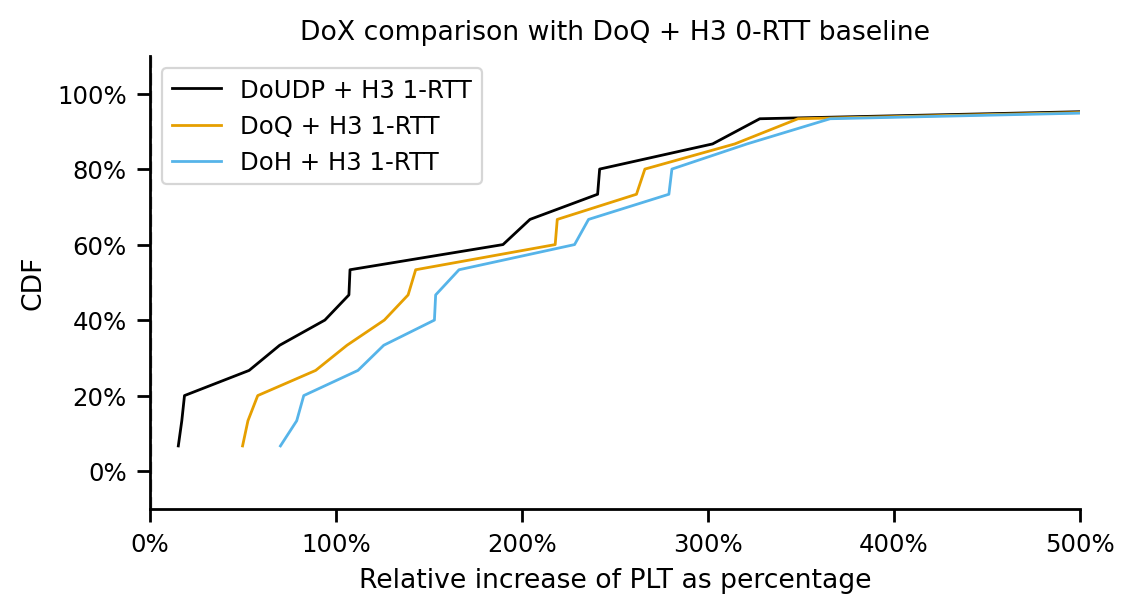

In [396]:
df_tmp = df_diff_plt_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of PLT as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 500)
ax.legend()


if log:
    fig.savefig('figures/plt-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/plt-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoUDP + H3 1-RTT
count     15.000000
mean      53.093469
std       61.295794
min        7.344832
10%        7.813675
20%       12.572046
25%       13.963818
30%       14.767090
40%       18.455144
50%       19.771002
60%       49.625997
70%       60.877575
75%       63.092509
80%       66.865056
90%      141.242790
100%     200.291467
max      200.291467
Name: DoUDP + H3 1-RTT, dtype: float64
DoQ + H3 1-RTT
count     15.000000
mean      84.974158
std       61.070564
min       38.297272
10%       39.880693
20%       42.736957
25%       44.122136
30%       45.737637
40%       48.824339
50%       53.080528
60%       83.929968
70%       95.567125
75%       96.017668
80%       98.732394
90%      171.726774
100%     231.434631
max      231.434631
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count     15.000000
mean     105.203174
std       60.998205
min       53.453870
10%       57.622058
20%       63.917409
25%       64.549789
30%       64.657336
40%       71.227180
50%       78.9588

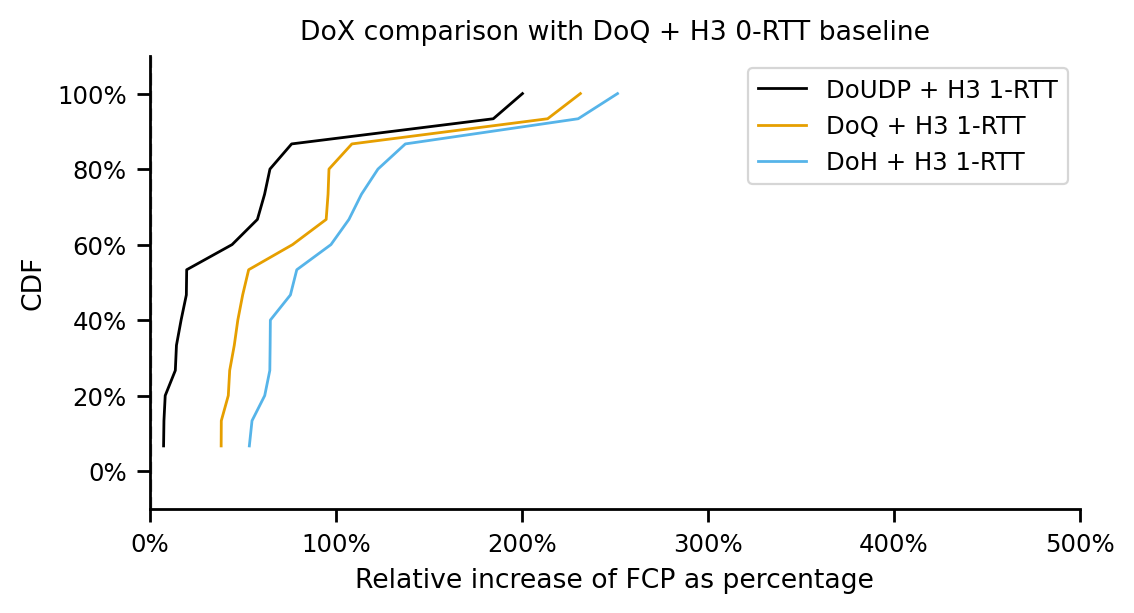

In [397]:
df_tmp = df_diff_fcp_quic
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoQ + H3 0-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 500)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doq-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doq-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ + H3 0-RTT
count    15.000000
mean    -27.508760
std      20.087692
min     -66.699020
10%     -56.215674
20%     -40.026417
25%     -38.680313
30%     -37.835107
40%     -33.036311
50%     -16.507336
60%     -15.568310
70%     -12.860507
75%     -12.252226
80%     -11.133846
90%      -7.246499
100%     -6.842279
max      -6.842279
Name: DoQ + H3 0-RTT, dtype: float64
DoQ + H3 1-RTT
count    15.000000
mean     23.139390
std       7.226873
min      10.260121
10%      13.580086
20%      18.766904
25%      19.073154
30%      19.525424
40%      21.010723
50%      22.556114
60%      25.559491
70%      28.240350
75%      28.630624
80%      29.038818
90%      31.544923
100%     33.965936
max      33.965936
Name: DoQ + H3 1-RTT, dtype: float64
DoH + H3 1-RTT
count    15.000000
mean     37.858727
std      12.311976
min      16.032221
10%      22.021335
20%      29.825227
25%      30.544124
30%      31.890060
40%      34.895415
50%      36.862229
60%      39.699030
70%      43.883883
75%    

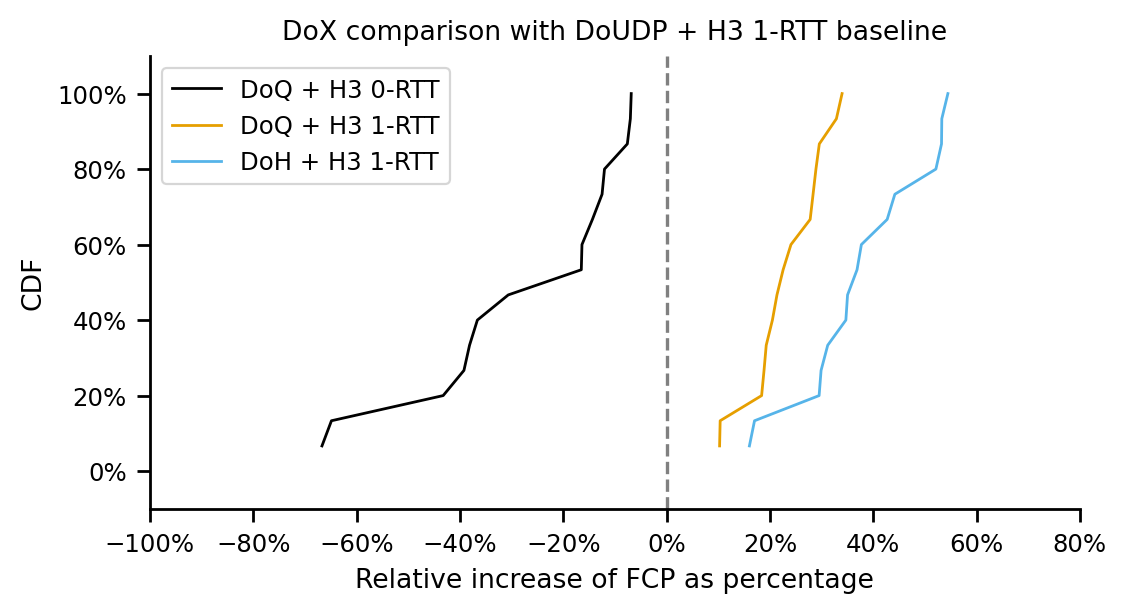

In [398]:
df_tmp = df_diff_fcp_udp
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
columns = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
lnwidth = 1
mrksize = 0
log=False
for col_val_ in columns:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(col_val_)
    print(df_tmp[col_val_].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[col_val_])
    dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=0, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX comparison with DoUDP + H3 1-RTT baseline')

ax.set_xlabel('Relative increase of FCP as percentage')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(-100, 80)
ax.legend()


if log:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/fcp-rel-inc-doudp-baseline.pdf', format='pdf', bbox_inches='tight')
plt.show()

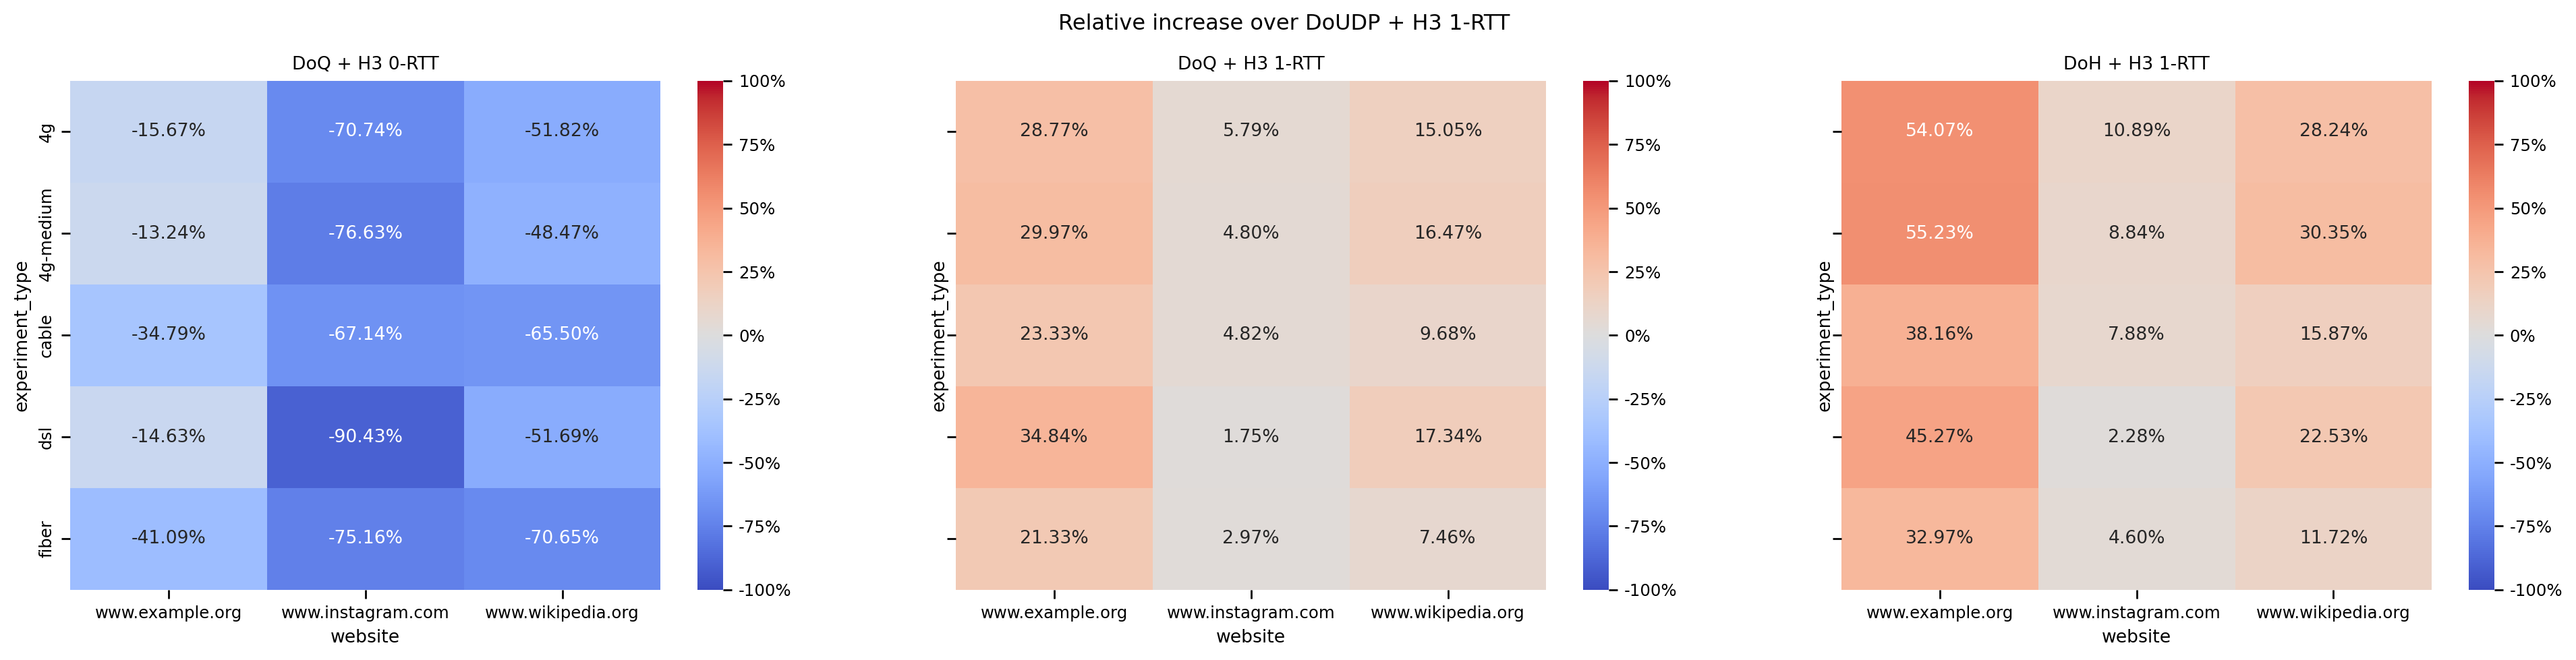

In [399]:
fig, axs = plt.subplots(1, 3, sharex='all', figsize=(24,5), sharey='all')
ax_hm1 =sns.heatmap(df_diff_plt_udp[['DoQ + H3 0-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 0-RTT'), ax=axs.flat[0], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm2 = sns.heatmap(df_diff_plt_udp[['DoQ + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoQ + H3 1-RTT'), ax=axs.flat[1], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
ax_hm3 = sns.heatmap(df_diff_plt_udp[['DoH + H3 1-RTT', 'experiment_type', 'website']].pivot(index='experiment_type', columns='website', values='DoH + H3 1-RTT'), ax=axs.flat[2], cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'format': '%.0f%%'}, vmin=-100, vmax=100)
axs.flat[0].set_title('DoQ + H3 0-RTT')
axs.flat[1].set_title('DoQ + H3 1-RTT')
axs.flat[2].set_title('DoH + H3 1-RTT')
fig.suptitle('Relative increase over DoUDP + H3 1-RTT')
ax_hm1.set_yticklabels(labels=ax_hm1.get_yticklabels(), va='center')
for t in ax_hm1.texts: t.set_text(t.get_text() + "%")
for t in ax_hm2.texts: t.set_text(t.get_text() + "%")
for t in ax_hm3.texts: t.set_text(t.get_text() + "%")
plt.show()

In [400]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.634956       34.842599       45.267388             dsl   
1       -51.689103       17.337700       22.526885             dsl   
2       -90.430381        1.754970        2.281210             dsl   
3       -34.786408       23.328361       38.158032           cable   
4       -65.496404        9.683123       15.868370           cable   
5       -67.140907        4.821315        7.877455           cable   
6       -41.092527       21.327226       32.965998           fiber   
7       -70.648672        7.458996       11.723209           fiber   
8       -75.156053        2.966877        4.601788           fiber   
9       -15.674316       28.765648       54.073062              4g   
10      -51.824403       15.051493       28.235441              4g   
11      -70.742512        5.791563       10.890422              4g   
12      -13.243224       29.973095       55.229984       4g-medium   
13      -48.470637       16.471603       30.348501       4g-medium   
14      -76.629480        4.802176        8.835061       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [401]:
df_diff_plt_udp

DoQ + H3 0-RTT  DoQ + H3 1-RTT  DoH + H3 1-RTT experiment_type  \
0       -14.634956       34.842599       45.267388             dsl   
1       -51.689103       17.337700       22.526885             dsl   
2       -90.430381        1.754970        2.281210             dsl   
3       -34.786408       23.328361       38.158032           cable   
4       -65.496404        9.683123       15.868370           cable   
5       -67.140907        4.821315        7.877455           cable   
6       -41.092527       21.327226       32.965998           fiber   
7       -70.648672        7.458996       11.723209           fiber   
8       -75.156053        2.966877        4.601788           fiber   
9       -15.674316       28.765648       54.073062              4g   
10      -51.824403       15.051493       28.235441              4g   
11      -70.742512        5.791563       10.890422              4g   
12      -13.243224       29.973095       55.229984       4g-medium   
13      -48.470637       16.471603       30.348501       4g-medium   
14      -76.629480        4.802176        8.835061       4g-medium   

              website  
0     www.example.org  
1   www.wikipedia.org  
2   www.instagram.com  
3     www.example.org  
4   www.wikipedia.org  
5   www.instagram.com  
6     www.example.org  
7   www.wikipedia.org  
8   www.instagram.com  
9     www.example.org  
10  www.wikipedia.org  
11  www.instagram.com  
12    www.example.org  
13  www.wikipedia.org  
14  www.instagram.com

In [402]:
df_udp_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [403]:
df_diff_all_data_udp_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoUDP + H3 1-RTT'], df_udp_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_udp_baseline_medians['relative_increase_plt'] = (df_diff_all_data_udp_baseline_medians['full_plt']/(df_diff_all_data_udp_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_udp_baseline_medians['full_fcp']/(df_diff_all_data_udp_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_udp_baseline_medians

msm_id  connectEnd  connectStart  \
0      d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1      d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2      d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
3      d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4      d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                     ...         ...           ...   
44250  43536617-7849-4070-940d-8784b0b4de63       161.8          45.2   
44251  43536617-7849-4070-940d-8784b0b4de63       161.8          45.2   
44252  43536617-7849-4070-940d-8784b0b4de63         0.5           0.5   
44253  43536617-7849-4070-940d-8784b0b4de63         0.5           0.5   
44254  43536617-7849-4070-940d-8784b0b4de63         0.5           0.5   

       domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0            184.3                     184.3                       184.3   
1            184.3                     184.3                       184.3   
2             72.9                      72.2                        72.2   
3             72.9                      72.2                        72.2   
4             72.9                      72.2                        72.2   
...            ...                       ...                         ...   
44250       2381.5                    2032.2                      2032.2   
44251       2381.5                    2032.2                      2032.2   
44252        361.1                     161.1                       161.1   
44253        361.1                     161.1                       161.1   
44254        361.1                     161.1                       161.1   

       domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0               184.3             45.9               45.9     184.3  ...   
1               184.3             45.9               45.9     184.3  ...   
2                72.2              2.0                2.0      72.9  ...   
3                72.2              2.0                2.0      72.9  ...   
4                72.2              2.0                2.0      72.9  ...   
...               ...              ...                ...       ...  ...   
44250          2032.2             45.2               45.1    2382.0  ...   
44251          2032.2             45.2               45.1    2382.0  ...   
44252           161.1              0.5                0.5     361.3  ...   
44253           161.1              0.5                0.5     361.3  ...   
44254           161.1              0.5                0.5     361.3  ...   

       transport_protocol     full_plt     full_fp    full_fcp  \
0                     DoQ   308.403523  313.103523  313.103523   
1                     DoH   332.963518  337.663518  337.663518   
2                     DoQ   197.003523  204.703523  204.703523   
3                     DoH   221.563518  229.263518  229.263518   
4                   DoUDP   117.057384  124.757384  124.757384   
...                   ...          ...         ...         ...   
44250                 DoQ  2606.417549  536.017549  536.017549   
44251                 DoH  2707.825251  637.425251  637.425251   
44252                 DoQ   585.817549  392.317549  392.317549   
44253                 DoH   687.225251  493.725251  493.725251   
44254               DoUDP   466.769587  273.269587  273.269587   

       h3_description  experiment_description  full_plt_udp_med  \
0            H3 1-RTT          DoQ + H3 1-RTT        230.708238   
1            H3 1-RTT          DoH + H3 1-RTT        230.708238   
2            H3 0-RTT          DoQ + H3 0-RTT        230.708238   
3            H3 0-RTT          DoH + H3 0-RTT        230.708238   
4            H3 0-RTT        DoUDP + H3 0-RTT        230.708238   
...               ...                     ...               ...   
44250        H3 1-RTT          DoQ + H3 1-RTT       2501.448112   
44251

In [404]:
df_diff_all_data_udp_baseline_medians.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [405]:
df_diff_all_data_udp_baseline_medians.website.unique()

array(['www.example.org', 'www.wikipedia.org', 'www.instagram.com'],
      dtype=object)

In [406]:
df_diff_all_data_udp_baseline_medians.experiment_description.unique()

array(['DoQ + H3 1-RTT', 'DoH + H3 1-RTT', 'DoQ + H3 0-RTT',
       'DoH + H3 0-RTT', 'DoUDP + H3 0-RTT'], dtype=object)

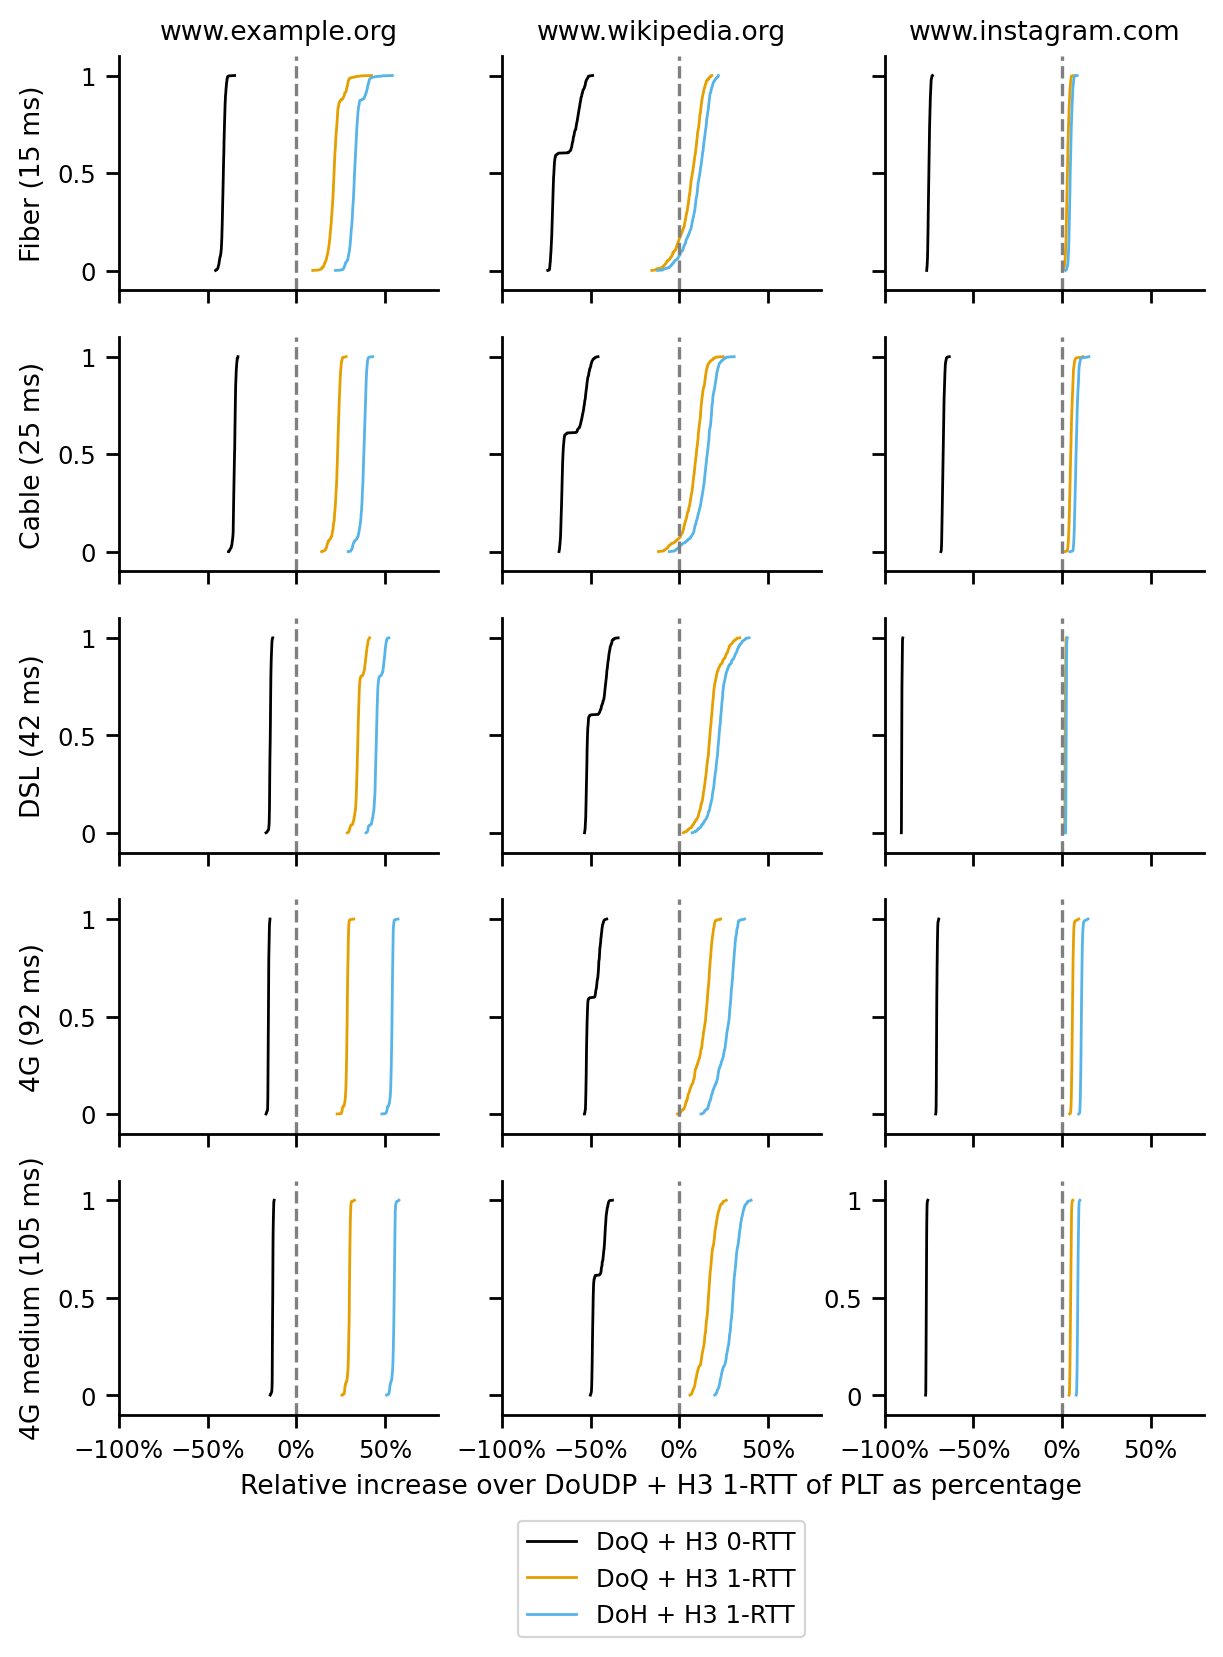

<Figure size 1200x800 with 0 Axes>

In [407]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/plt-doudp-baseline-grid.pdf", bbox_inches='tight')

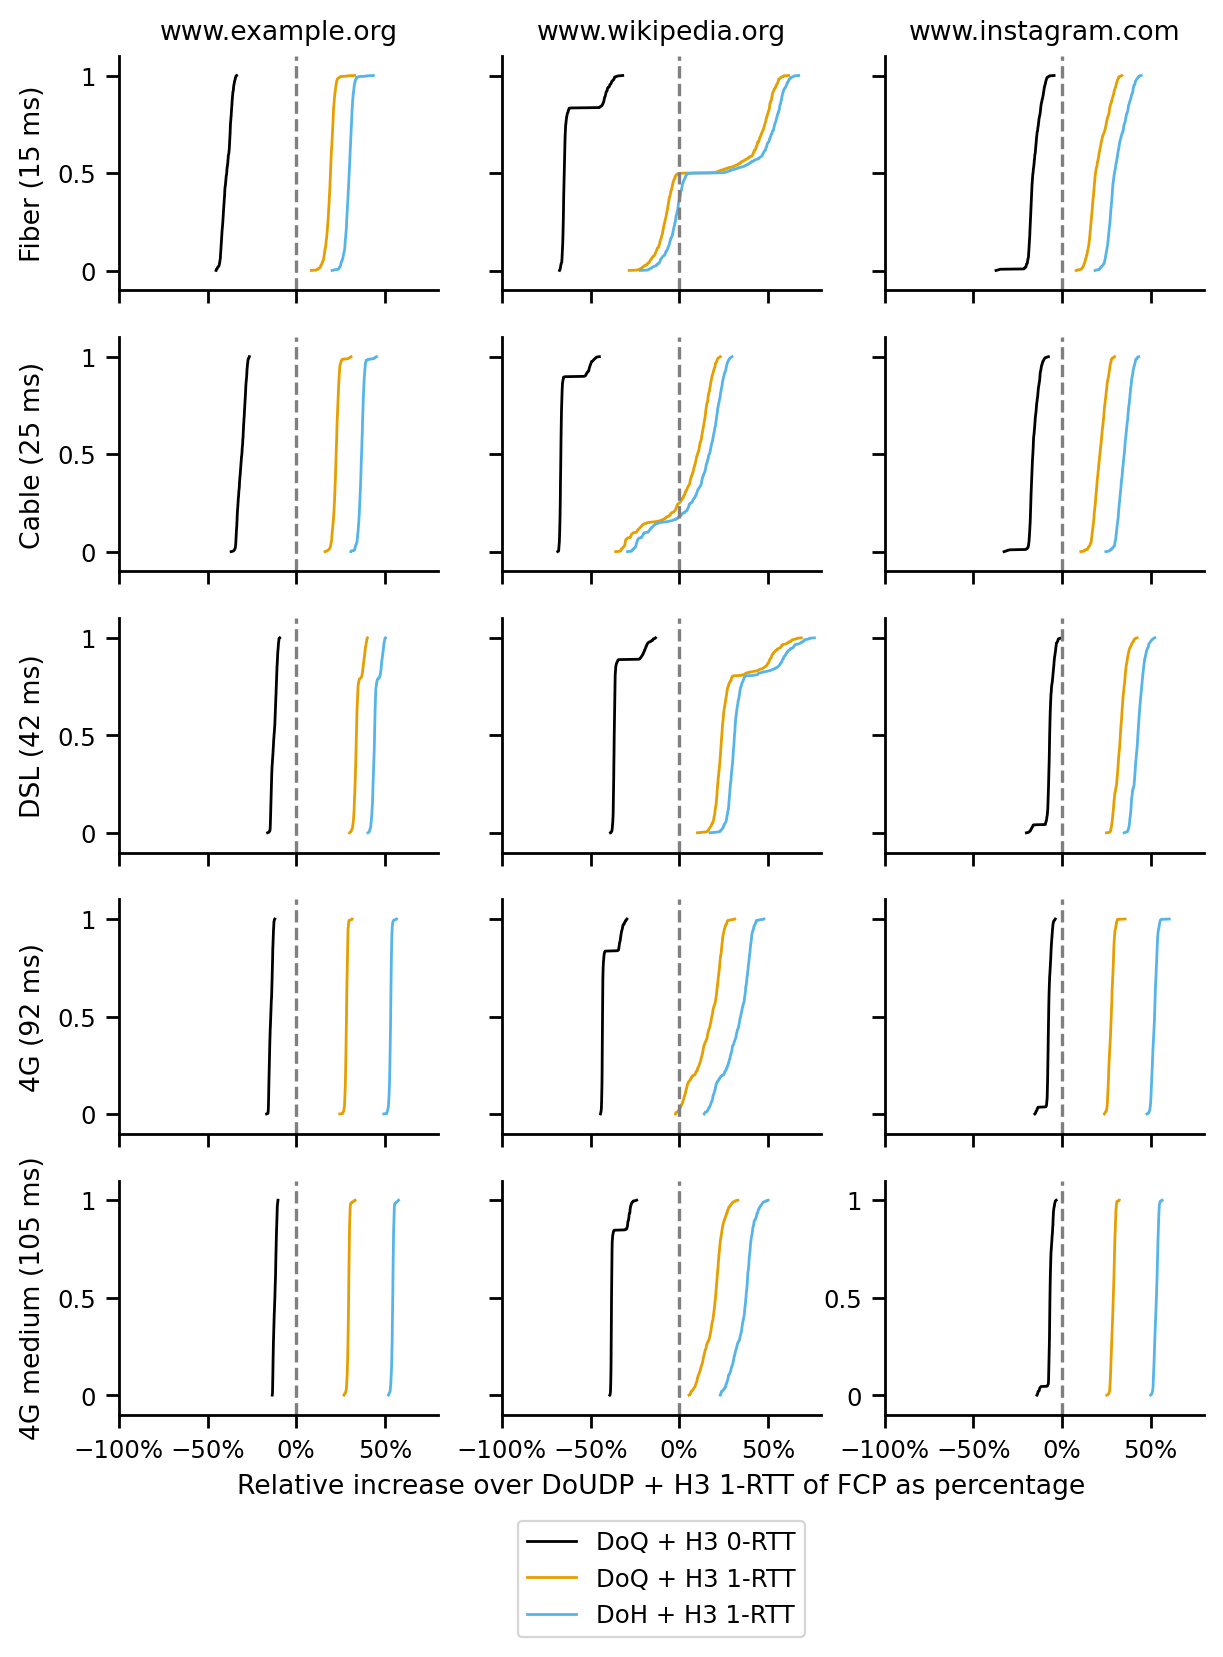

<Figure size 1200x800 with 0 Axes>

In [408]:
metrics_for_single_cdf = ['DoQ + H3 0-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_udp_baseline_medians[(df_diff_all_data_udp_baseline_medians['website'] == website) & (df_diff_all_data_udp_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_udp_baseline_medians['experiment_description'] == metric)]['relative_increase_fcp'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoUDP + H3 1-RTT of FCP as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(-100, 80)

plt.show()
plt.savefig("figures/fcp-doudp-baseline-grid.pdf", bbox_inches='tight')

In [409]:
df_quic_baseline_medians = df_dns_and_h3[df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT'].groupby(['website','experiment_type'], as_index=False).agg(full_plt_udp_med=('full_plt', 'median'), full_fcp_udp_med=('full_fcp', 'median'))

In [410]:
df_diff_all_data_quic_baseline_medians = pd.merge(df_dns_and_h3[df_dns_and_h3.experiment_description != 'DoQ + H3 0-RTT'], df_quic_baseline_medians, on=['website', 'experiment_type'])
df_diff_all_data_quic_baseline_medians['relative_increase_plt'] = (df_diff_all_data_quic_baseline_medians['full_plt']/(df_diff_all_data_quic_baseline_medians['full_plt_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians['relative_increase_fcp'] = (df_diff_all_data_quic_baseline_medians['full_fcp']/(df_diff_all_data_quic_baseline_medians['full_fcp_udp_med']/100))-100
df_diff_all_data_quic_baseline_medians

msm_id  connectEnd  connectStart  \
0      d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
1      d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
2      d31444a1-777c-45ae-bb04-f67fbcf67716       111.4          45.9   
3      d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
4      d31444a1-777c-45ae-bb04-f67fbcf67716        60.0           2.0   
...                                     ...         ...           ...   
44250  43536617-7849-4070-940d-8784b0b4de63       161.8          45.2   
44251  43536617-7849-4070-940d-8784b0b4de63       161.8          45.2   
44252  43536617-7849-4070-940d-8784b0b4de63       161.8          45.2   
44253  43536617-7849-4070-940d-8784b0b4de63         0.5           0.5   
44254  43536617-7849-4070-940d-8784b0b4de63         0.5           0.5   

       domComplete  domContentLoadedEventEnd  domContentLoadedEventStart  \
0            184.3                     184.3                       184.3   
1            184.3                     184.3                       184.3   
2            184.3                     184.3                       184.3   
3             72.9                      72.2                        72.2   
4             72.9                      72.2                        72.2   
...            ...                       ...                         ...   
44250       2381.5                    2032.2                      2032.2   
44251       2381.5                    2032.2                      2032.2   
44252       2381.5                    2032.2                      2032.2   
44253        361.1                     161.1                       161.1   
44254        361.1                     161.1                       161.1   

       domInteractive  domainLookupEnd  domainLookupStart  duration  ...  \
0               184.3             45.9               45.9     184.3  ...   
1               184.3             45.9               45.9     184.3  ...   
2               184.3             45.9               45.9     184.3  ...   
3                72.2              2.0                2.0      72.9  ...   
4                72.2              2.0                2.0      72.9  ...   
...               ...              ...                ...       ...  ...   
44250          2032.2             45.2               45.1    2382.0  ...   
44251          2032.2             45.2               45.1    2382.0  ...   
44252          2032.2             45.2               45.1    2382.0  ...   
44253           161.1              0.5                0.5     361.3  ...   
44254           161.1              0.5                0.5     361.3  ...   

       transport_protocol     full_plt     full_fp    full_fcp  \
0                     DoQ   308.403523  313.103523  313.103523   
1                     DoH   332.963518  337.663518  337.663518   
2                   DoUDP   228.457384  233.157384  233.157384   
3                     DoH   221.563518  229.263518  229.263518   
4                   DoUDP   117.057384  124.757384  124.757384   
...                   ...          ...         ...         ...   
44250                 DoQ  2606.417549  536.017549  536.017549   
44251                 DoH  2707.825251  637.425251  637.425251   
44252               DoUDP  2487.369587  416.969587  416.969587   
44253                 DoH   687.225251  493.725251  493.725251   
44254               DoUDP   466.769587  273.269587  273.269587   

       h3_description  experiment_description  full_plt_udp_med  \
0            H3 1-RTT          DoQ + H3 1-RTT        196.944188   
1            H3 1-RTT          DoH + H3 1-RTT        196.944188   
2            H3 1-RTT        DoUDP + H3 1-RTT        196.944188   
3            H3 0-RTT          DoH + H3 0-RTT        196.944188   
4            H3 0-RTT        DoUDP + H3 0-RTT        196.944188   
...               ...                     ...               ...   
44250        H3 1-RTT          DoQ + H3 1-RTT        584.601432   
44251

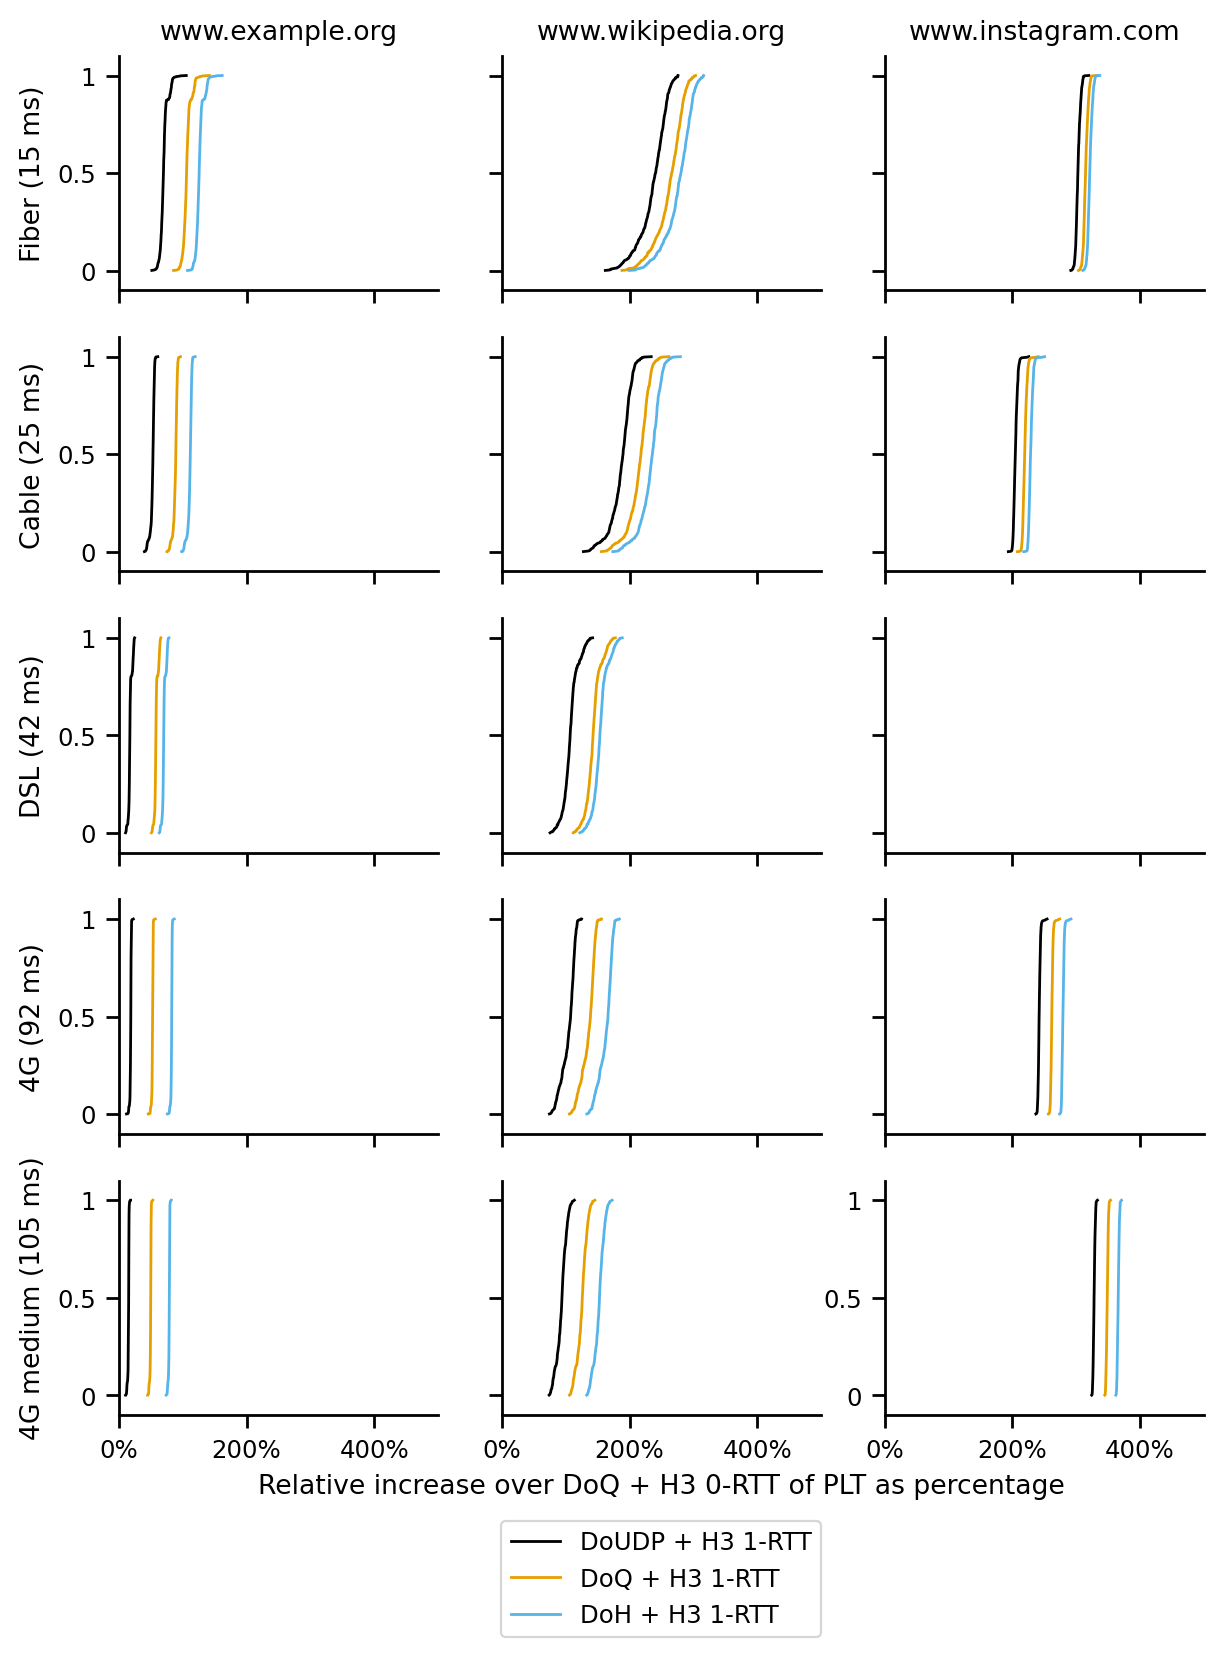

<Figure size 1200x800 with 0 Axes>

In [411]:
metrics_for_single_cdf = ['DoUDP + H3 1-RTT', 'DoQ + H3 1-RTT', 'DoH + H3 1-RTT']
colors = dict(zip(metrics_for_single_cdf, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(metrics_for_single_cdf, ['o','v','^','>','s','p','h','d','<','.']))
website_columns = ['www.example.org', 'www.wikipedia.org', 'www.instagram.com']
access_tech_rows = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
lnwidth = 1
mrksize = 0
access_tech_rows_descr_mapping = {'4g-medium':'4G medium (105 ms)', '4g':'4G (92 ms)', 'dsl':'DSL (42 ms)', 'cable':'Cable (25 ms)', 'fiber':'Fiber (15 ms)'}
fig, axs = plt.subplots(len(access_tech_rows), len(website_columns), sharex='all', figsize=(7,9), sharey='all')
#fig.suptitle('DoX comparison with DoUDP + H3 1-RTT baseline')
for i, website in enumerate(website_columns):
    for j, tech in enumerate(access_tech_rows):
        ax = axs[j, i]
        for metric in metrics_for_single_cdf:
            s_plot = make_cdf(df_diff_all_data_quic_baseline_medians[(df_diff_all_data_quic_baseline_medians['website'] == website) & (df_diff_all_data_quic_baseline_medians['experiment_type'] == tech) & (df_diff_all_data_quic_baseline_medians['experiment_description'] == metric)]['relative_increase_plt'])
            s_plot.plot(ax=ax, label=metric, marker=markers[metric], markersize=mrksize, drawstyle="default", color=colors[metric], linestyle='-', linewidth=lnwidth)

        #ax.axvline(x=0, color='gray', linestyle='--')

        ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.0))
        ax.spines['left'].set_position(('axes', -0.0))
        if log:
            ax.set_xscale('log')

        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax.xaxis.set_minor_formatter(ticker.PercentFormatter())

        ax.tick_params(axis='x', which='minor', labelsize=6)
        ax.xaxis.set_tick_params(labelbottom=True, which='both')

        if j == 0:
            ax.set_title(website)
        if j == len(access_tech_rows)-1:
            if i == math.floor(len(website_columns)/2):
                ax.set_xlabel('Relative increase over DoQ + H3 0-RTT of PLT as percentage')
                ax.legend(loc='center', bbox_to_anchor=(0.5, -0.7))
        if i == 0:
            ax.set_ylabel(access_tech_rows_descr_mapping[tech])
        ax.set_ylim(-0.1,1.1)
        ax.set_xlim(0, 500)

plt.show()
plt.savefig("figures/plt-doq-baseline-grid.pdf", bbox_inches='tight')

DoQ+0rtt -> 1-rtt handshake
DoUDP+1-rtt -> 1-rtt handshake
-> compare their relative increase in PLT from 4g to 4g medium for www.example.org (inflight should always be below BDP)

In [412]:
df_exchange_durations = df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'exchange'].copy()
df_exchange_durations = pd.merge(df_exchange_durations, measurements, on='msm_id')

In [413]:
df_exchange_durations.experiment_type.unique()

array(['dsl', 'cable', 'fiber', '4g', '4g-medium'], dtype=object)

In [414]:
df_exchange_durations['rtt'] = 0
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'dsl', 42.35979, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'cable', 25.17665, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == 'fiber', 14.767147, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g', 91.85231065904635, df_exchange_durations['rtt'])
df_exchange_durations['rtt'] = np.where(df_exchange_durations['experiment_type'] == '4g-medium', 104.5041425140391, df_exchange_durations['rtt'])

In [415]:
df_exchange_durations['duration_in_rtt'] = df_exchange_durations['duration'] / df_exchange_durations['rtt']

In [416]:
df_exchange_durations['handshake_round_trips'] = 0
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoQ', 1, df_exchange_durations['handshake_round_trips'])
df_exchange_durations['handshake_round_trips'] = np.where(df_exchange_durations['transport_protocol'] == 'DoH', 2, df_exchange_durations['handshake_round_trips'])

In [417]:
df_exchange_durations['theoretical_handshake_duration'] = df_exchange_durations['handshake_round_trips'] * df_exchange_durations['rtt']

In [418]:
df_exchange_durations['theoretical_exchange_without_handshake'] = df_exchange_durations['duration'] - df_exchange_durations['theoretical_handshake_duration']

In [419]:
df_exchange_durations['theoretical_query_in_rtt'] = df_exchange_durations['theoretical_exchange_without_handshake'] / df_exchange_durations['rtt']

In [420]:
df_exchange_durations['theoretical_processing_delay'] = df_exchange_durations['theoretical_exchange_without_handshake'] - df_exchange_durations['rtt']

In [421]:
df_exchange_durations.transport_protocol.unique()

array(['DoQ', 'DoH', 'DoUDP'], dtype=object)

DoQ
count    8851.000000
mean        2.500310
std         0.323117
min         2.072813
10%         2.132589
20%         2.148905
25%         2.154393
30%         2.156126
40%         2.322840
50%         2.496029
60%         2.560502
70%         2.773289
75%         2.802792
80%         2.891072
90%         2.934908
100%        3.345451
max         3.345451
Name: duration_in_rtt, dtype: float64
DoH
count    8851.000000
mean        3.381149
std         0.229677
min         3.070226
10%         3.122344
20%         3.124137
25%         3.124988
30%         3.126003
40%         3.280384
50%         3.432308
60%         3.493943
70%         3.507708
75%         3.510650
80%         3.549241
90%         3.713071
100%        3.860057
max         3.860057
Name: duration_in_rtt, dtype: float64
DoUDP
count    8851.000000
mean        1.027718
std         0.016749
min         1.003528
10%         1.008306
20%         1.008726
25%         1.008913
30%         1.009099
40%         1.017382
50%    

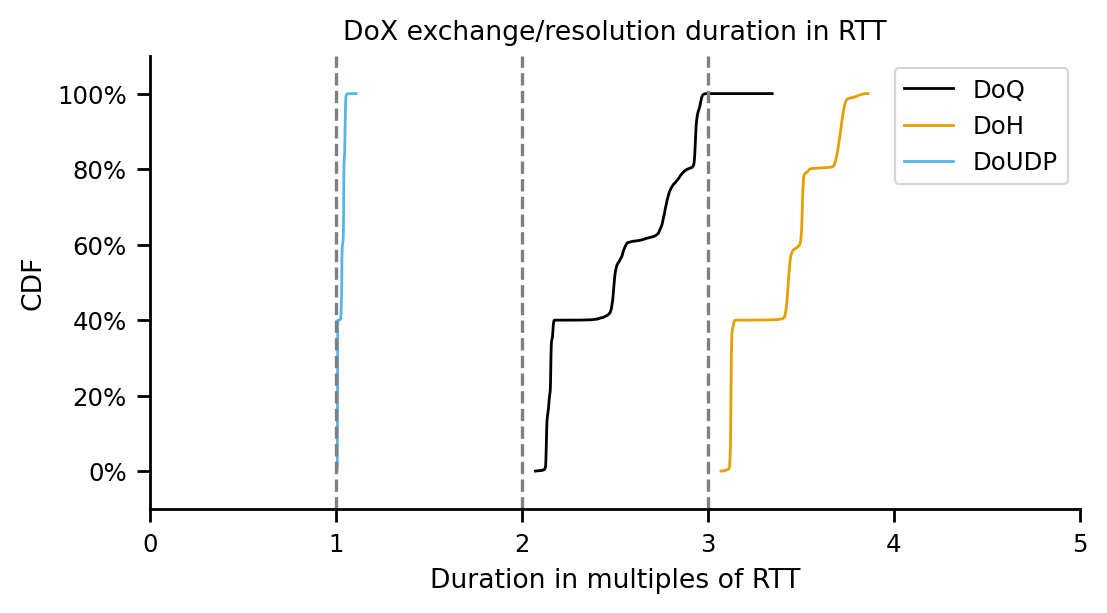

In [422]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX exchange/resolution duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/exchange-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/exchange-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    1771.000000
mean        2.768777
std         0.072076
min         2.407651
10%         2.698058
20%         2.742471
25%         2.750701
30%         2.756525
40%         2.765390
50%         2.773260
60%         2.781929
70%         2.793690
75%         2.802716
80%         2.815609
90%         2.849487
100%        3.345451
max         3.345451
Name: duration_in_rtt, dtype: float64
DoH
count    1771.000000
mean        3.713952
std         0.036794
min         3.466003
10%         3.685208
20%         3.694483
25%         3.698003
30%         3.701309
40%         3.707348
50%         3.713071
60%         3.718413
70%         3.723950
75%         3.726863
80%         3.730986
90%         3.742200
100%        3.860057
max         3.860057
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.048773
std         0.004709
min         1.019876
10%         1.043329
20%         1.046866
25%         1.047616
30%         1.048076
40%         1.048799
50%    

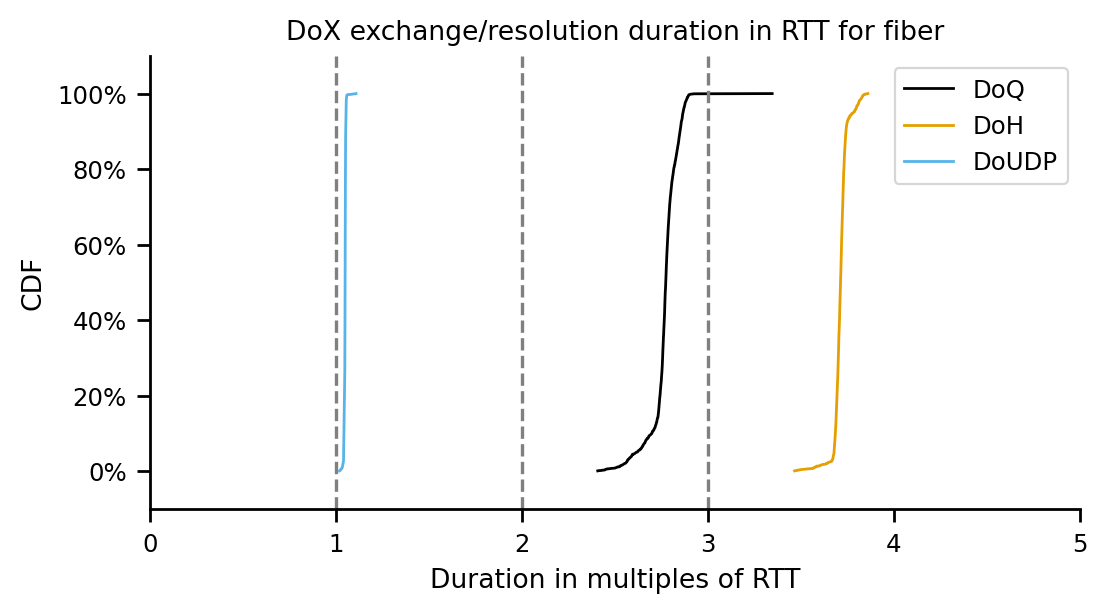

DoQ
count    1771.000000
mean        2.500950
std         0.032631
min         2.294487
10%         2.475352
20%         2.484920
25%         2.487689
30%         2.489596
40%         2.493051
50%         2.496351
60%         2.500436
70%         2.508431
75%         2.517925
80%         2.530699
90%         2.545893
100%        2.581566
max         2.581566
Name: duration_in_rtt, dtype: float64
DoH
count    1771.000000
mean        3.434612
std         0.021992
min         3.267833
10%         3.417269
20%         3.423036
25%         3.424917
30%         3.426399
40%         3.429483
50%         3.432363
60%         3.435400
70%         3.438570
75%         3.440599
80%         3.442722
90%         3.453427
100%        3.539340
max         3.539340
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.030955
std         0.002402
min         1.014908
10%         1.027833
20%         1.029768
25%         1.030321
30%         1.030574
40%         1.030958
50%    

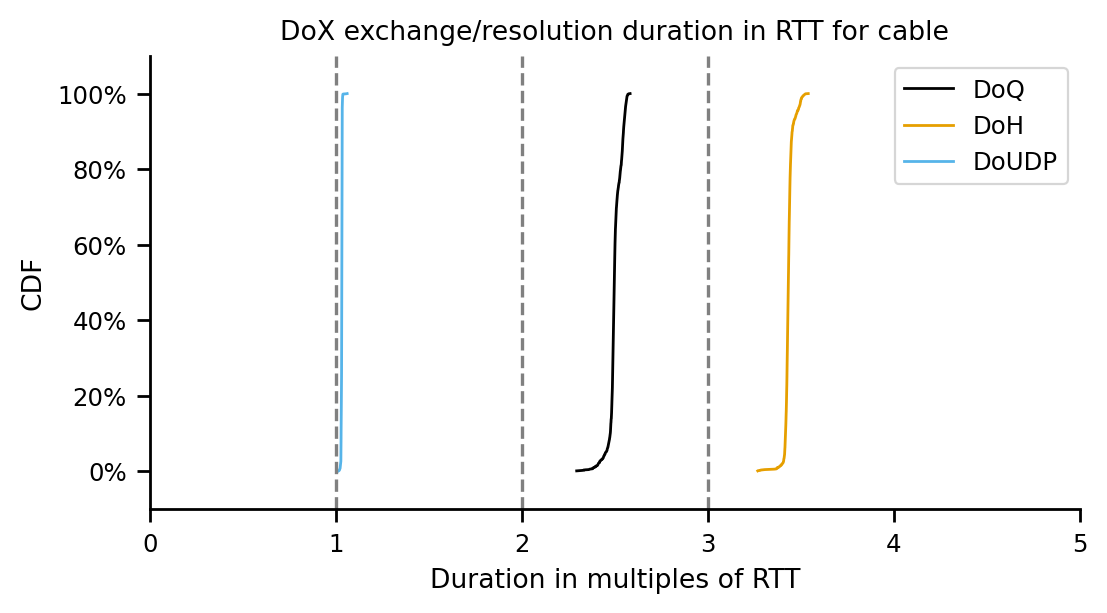

DoQ
count    1771.000000
mean        2.938699
std         0.016515
min         2.803749
10%         2.926408
20%         2.929364
25%         2.930363
30%         2.931327
40%         2.932961
50%         2.934903
60%         2.937437
70%         2.942530
75%         2.946778
80%         2.952842
90%         2.961770
100%        2.987789
max         2.987789
Name: duration_in_rtt, dtype: float64
DoH
count    1771.000000
mean        3.508095
std         0.011755
min         3.399031
10%         3.500427
20%         3.503672
25%         3.504579
30%         3.505215
40%         3.506430
50%         3.507633
60%         3.508688
70%         3.509933
75%         3.510614
80%         3.511648
90%         3.515297
100%        3.555582
max         3.555582
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.041520
std         0.001507
min         1.031577
10%         1.039561
20%         1.040664
25%         1.041073
30%         1.041251
40%         1.041510
50%    

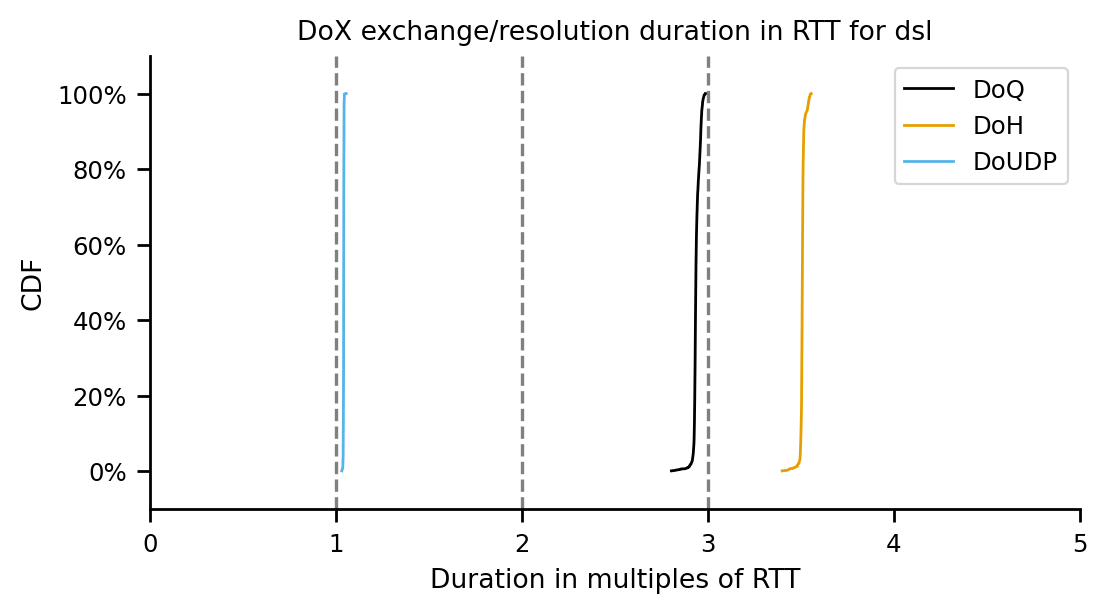

DoQ
count    1769.000000
mean        2.134512
std         0.007968
min         2.072813
10%         2.128462
20%         2.129734
25%         2.130183
30%         2.130723
40%         2.131681
50%         2.132735
60%         2.133819
70%         2.136421
75%         2.139459
80%         2.142386
90%         2.145597
100%        2.154791
max         2.154791
Name: duration_in_rtt, dtype: float64
DoH
count    1769.000000
mean        3.124208
std         0.005800
min         3.070226
10%         3.119773
20%         3.121639
25%         3.122086
30%         3.122475
40%         3.123268
50%         3.123992
60%         3.124718
70%         3.125506
75%         3.125963
80%         3.126490
90%         3.128665
100%        3.147049
max         3.147049
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008324
std         0.000621
min         1.003528
10%         1.007526
20%         1.008046
25%         1.008134
30%         1.008207
40%         1.008318
50%    

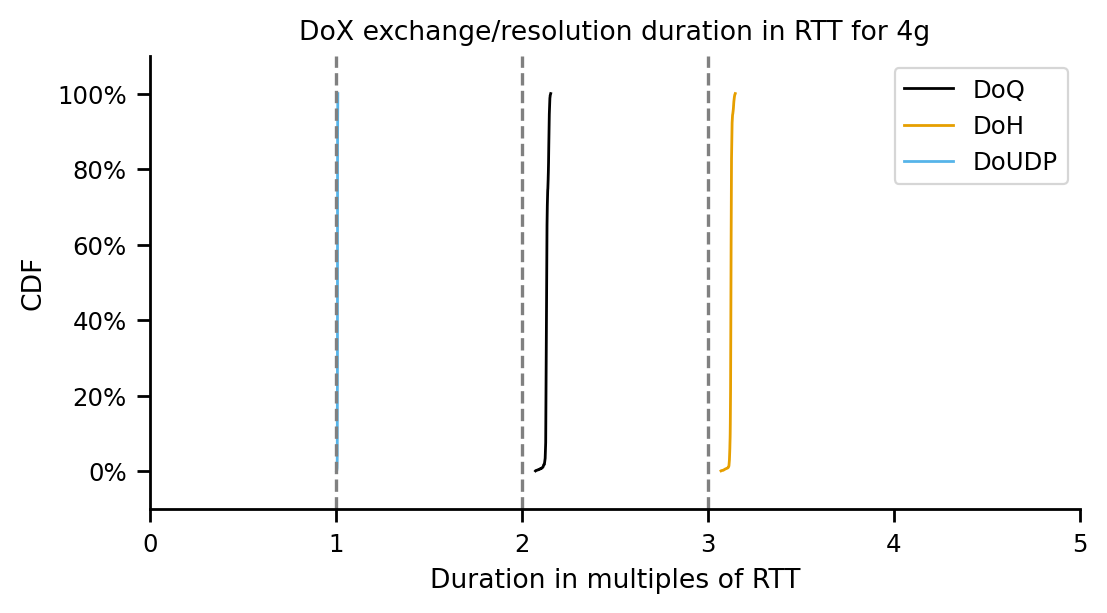

DoQ
count    1769.000000
mean        2.157812
std         0.006943
min         2.109798
10%         2.152837
20%         2.153996
25%         2.154362
30%         2.154727
40%         2.155282
50%         2.156123
60%         2.157010
70%         2.158829
75%         2.161920
80%         2.165065
90%         2.167725
100%        2.174666
max         2.174666
Name: duration_in_rtt, dtype: float64
DoH
count    1769.000000
mean        3.124299
std         0.005226
min         3.084519
10%         3.119697
20%         3.122131
25%         3.122605
30%         3.122977
40%         3.123625
50%         3.124243
60%         3.124826
70%         3.125600
75%         3.126031
80%         3.126513
90%         3.128427
100%        3.142604
max         3.142604
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008975
std         0.000608
min         1.005154
10%         1.008236
20%         1.008718
25%         1.008785
30%         1.008846
40%         1.008959
50%    

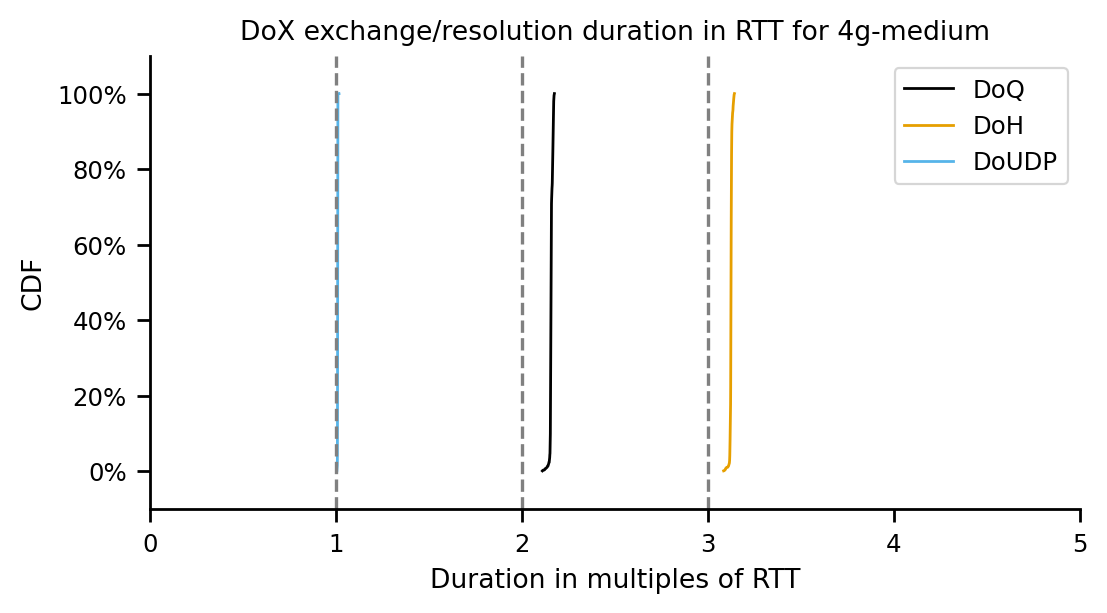

In [423]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    plt.axvline(x=1, color='gray', linestyle='--')
    plt.axvline(x=2, color='gray', linestyle='--')
    plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX exchange/resolution duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/exchange-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    8851.000000
mean       74.229712
std        36.862658
min        20.786989
10%        26.185994
20%        32.590848
25%        37.454628
30%        37.672772
40%        39.625914
50%        81.959187
60%        84.076249
70%       104.041645
75%       104.661386
80%       106.010223
90%       120.819399
100%      122.757442
max       122.757442
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    8851.000000
mean       69.194692
std        36.173472
min        21.648678
10%        25.297173
20%        27.467741
25%        35.873795
30%        36.060902
40%        38.388745
50%        63.862717
60%        65.690350
70%       103.241210
75%       103.420132
80%       105.316280
90%       117.487977
100%      119.406850
max       119.406850
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    8851.000000
mean       56.705065
std        35.964727
min        15.060658
10%        15.496442
20%        16.362055
25%        25.939980
30%

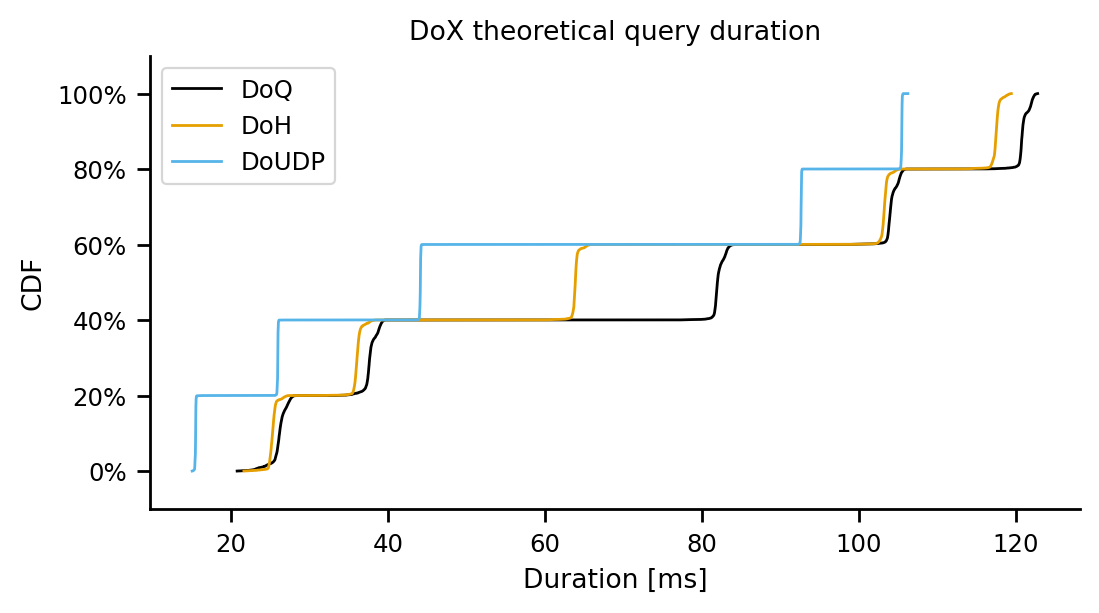

In [424]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    1771.000000
mean       26.119787
std         1.064353
min        20.786989
10%        25.075467
20%        25.731319
25%        25.852858
30%        25.938860
40%        26.069768
50%        26.185994
60%        26.314008
70%        26.487683
75%        26.620980
80%        26.811361
90%        27.311640
100%       34.635614
max        34.635614
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1771.000000
mean       25.310178
std         0.543336
min        21.648678
10%        24.885714
20%        25.022675
25%        25.074663
30%        25.123484
40%        25.212660
50%        25.297173
60%        25.376052
70%        25.457829
75%        25.500846
80%        25.561722
90%        25.727330
100%       27.467741
max        27.467741
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1771.000000
mean       15.487387
std         0.069533
min        15.060658
10%        15.406997
20%        15.459227
25%        15.470302
30%

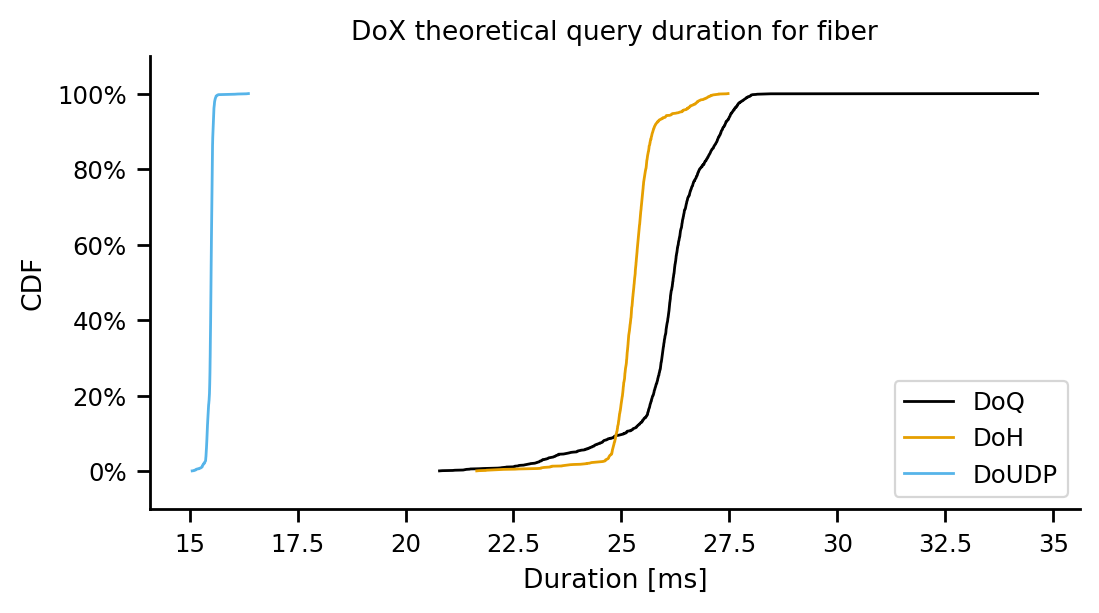

DoQ
count    1771.000000
mean       37.788887
std         0.821547
min        32.590848
10%        37.144423
20%        37.385322
25%        37.455037
30%        37.503038
40%        37.590022
50%        37.673105
60%        37.775952
70%        37.977242
75%        38.216257
80%        38.537861
90%        38.920395
100%       39.818544
max        39.818544
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1771.000000
mean       36.118715
std         0.553685
min        31.919783
10%        35.682096
20%        35.827269
25%        35.874637
30%        35.911943
40%        35.989601
50%        36.062098
60%        36.138559
70%        36.218370
75%        36.269447
80%        36.322901
90%        36.592425
100%       38.755412
max        38.755412
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1771.000000
mean       25.956003
std         0.060484
min        25.551986
10%        25.877403
20%        25.926105
25%        25.940022
30%

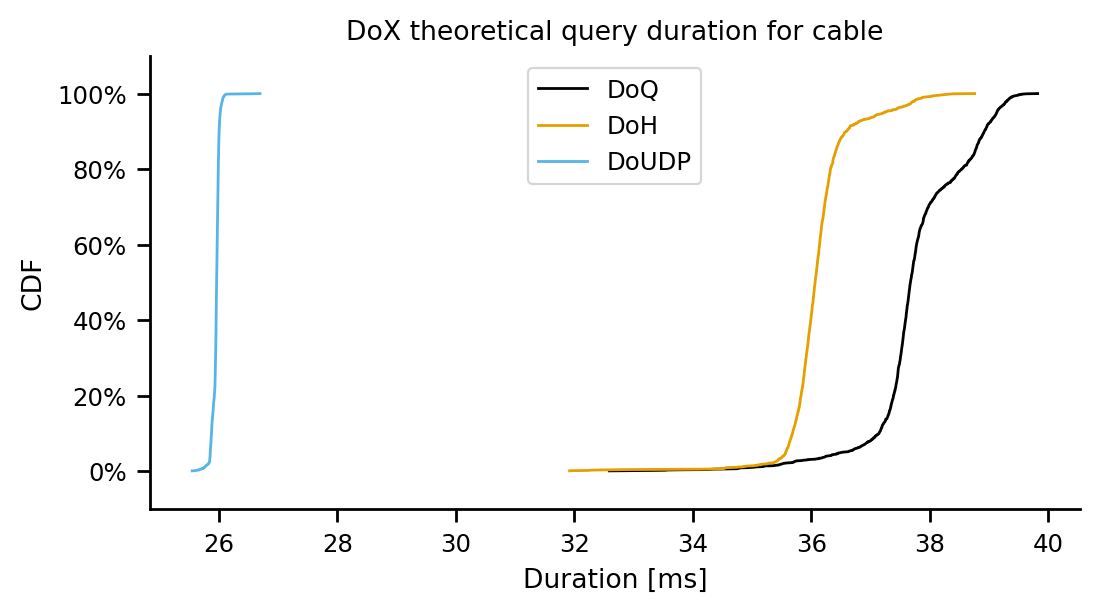

DoQ
count    1771.000000
mean       82.122880
std         0.699582
min        76.406436
10%        81.602234
20%        81.727443
25%        81.769787
30%        81.810589
40%        81.879843
50%        81.962077
60%        82.069424
70%        82.285161
75%        82.465097
80%        82.721957
90%        83.100167
100%       84.202336
max        84.202336
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1771.000000
mean       63.882607
std         0.497958
min        59.262669
10%        63.557787
20%        63.695237
25%        63.733671
30%        63.760608
40%        63.812071
50%        63.863015
60%        63.907701
70%        63.960442
75%        63.989295
80%        64.033076
90%        64.187667
100%       65.894142
max        65.894142
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1771.000000
mean       44.118582
std         0.063855
min        43.697391
10%        44.035572
20%        44.082307
25%        44.099647
30%

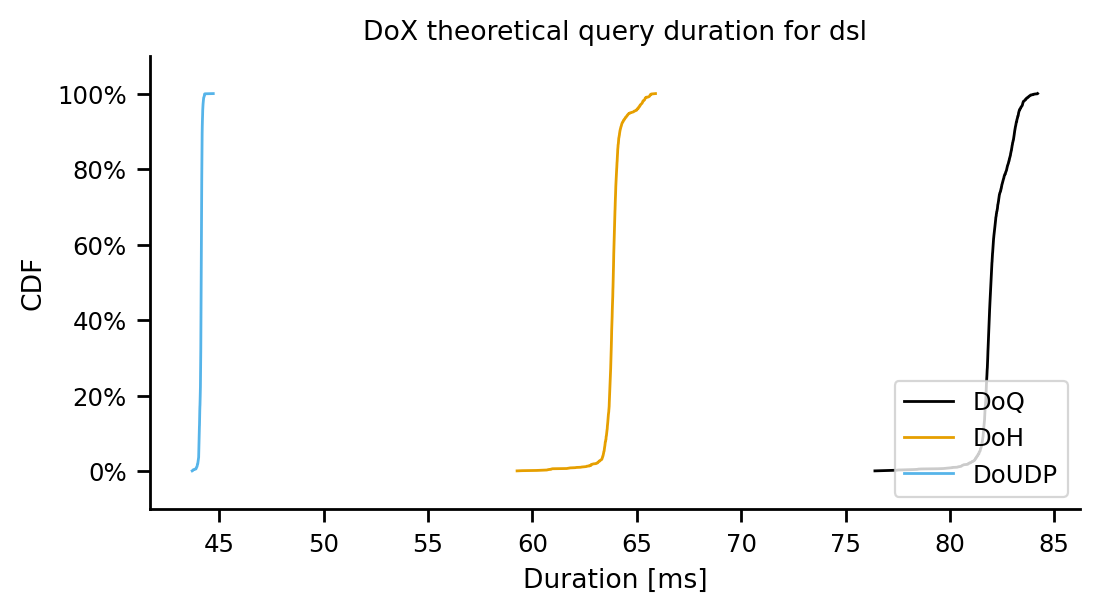

DoQ
count    1769.000000
mean      104.207506
std         0.731843
min        98.540395
10%       103.651820
20%       103.768640
25%       103.809933
30%       103.859544
40%       103.947506
50%       104.044285
60%       104.143926
70%       104.382887
75%       104.661949
80%       104.930774
90%       105.225708
100%      106.070257
max       106.070257
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1769.000000
mean      103.261088
std         0.532761
min        98.302768
10%       102.853772
20%       103.025133
25%       103.066184
30%       103.101880
40%       103.174801
50%       103.241275
60%       103.307923
70%       103.380307
75%       103.422349
80%       103.470712
90%       103.670496
100%      105.359138
max       105.359138
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1769.000000
mean       92.616895
std         0.057016
min        92.176357
10%        92.543600
20%        92.591392
25%        92.599460
30%

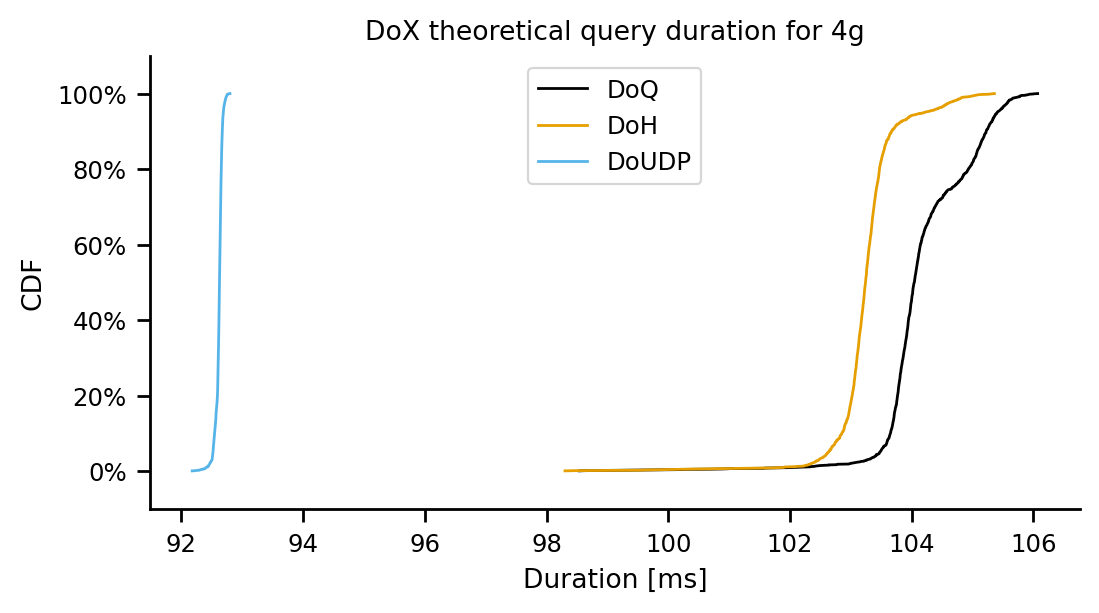

DoQ
count    1769.000000
mean      120.996166
std         0.725605
min       115.978521
10%       120.476263
20%       120.597336
25%       120.635587
30%       120.673710
40%       120.731725
50%       120.819668
60%       120.912330
70%       121.102460
75%       121.425435
80%       121.754163
90%       122.032091
100%      122.757442
max       122.757442
Name: theoretical_exchange_without_handshake, dtype: float64
DoH
count    1769.000000
mean      117.493889
std         0.546175
min       113.336753
10%       117.012952
20%       117.267329
25%       117.316910
30%       117.355727
40%       117.423493
50%       117.488048
60%       117.548941
70%       117.629889
75%       117.674944
80%       117.725316
90%       117.925261
100%      119.406850
max       119.406850
Name: theoretical_exchange_without_handshake, dtype: float64
DoUDP
count    1769.000000
mean      105.442055
std         0.063562
min       105.042749
10%       105.364857
20%       105.415207
25%       105.422177
30%

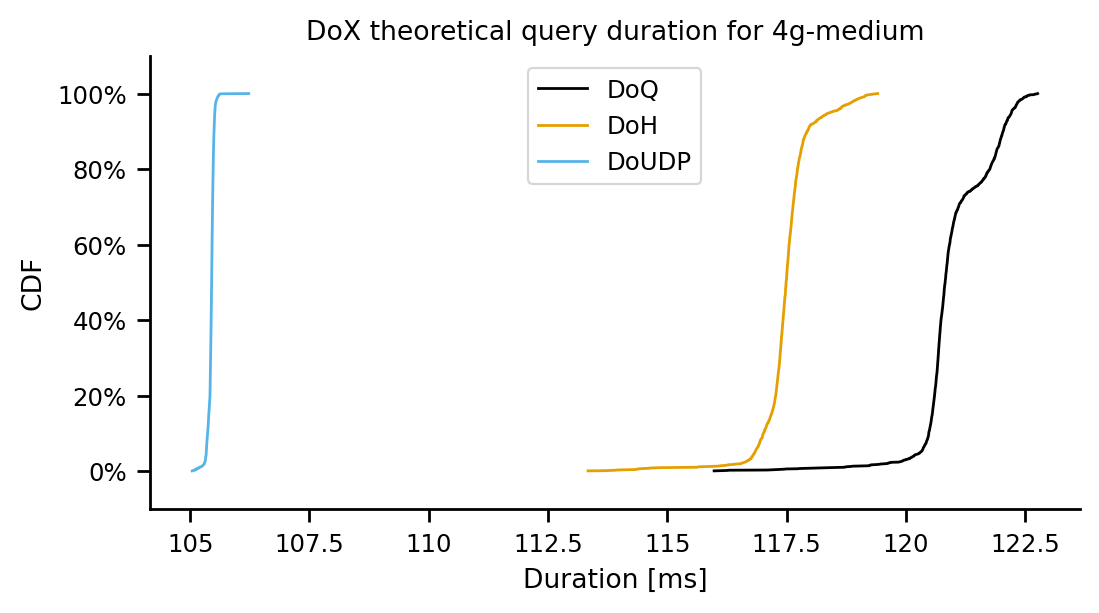

In [425]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_exchange_without_handshake'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration for '+tech)

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    8851.000000
mean        1.500310
std         0.323117
min         1.072813
10%         1.132589
20%         1.148905
25%         1.154393
30%         1.156126
40%         1.322840
50%         1.496029
60%         1.560502
70%         1.773289
75%         1.802792
80%         1.891072
90%         1.934908
100%        2.345451
max         2.345451
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    8851.000000
mean        1.381149
std         0.229677
min         1.070226
10%         1.122344
20%         1.124137
25%         1.124988
30%         1.126003
40%         1.280384
50%         1.432308
60%         1.493943
70%         1.507708
75%         1.510650
80%         1.549241
90%         1.713071
100%        1.860057
max         1.860057
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    8851.000000
mean        1.027718
std         0.016749
min         1.003528
10%         1.008306
20%         1.008726
25%         1.008913
30%         1.009099
40%       

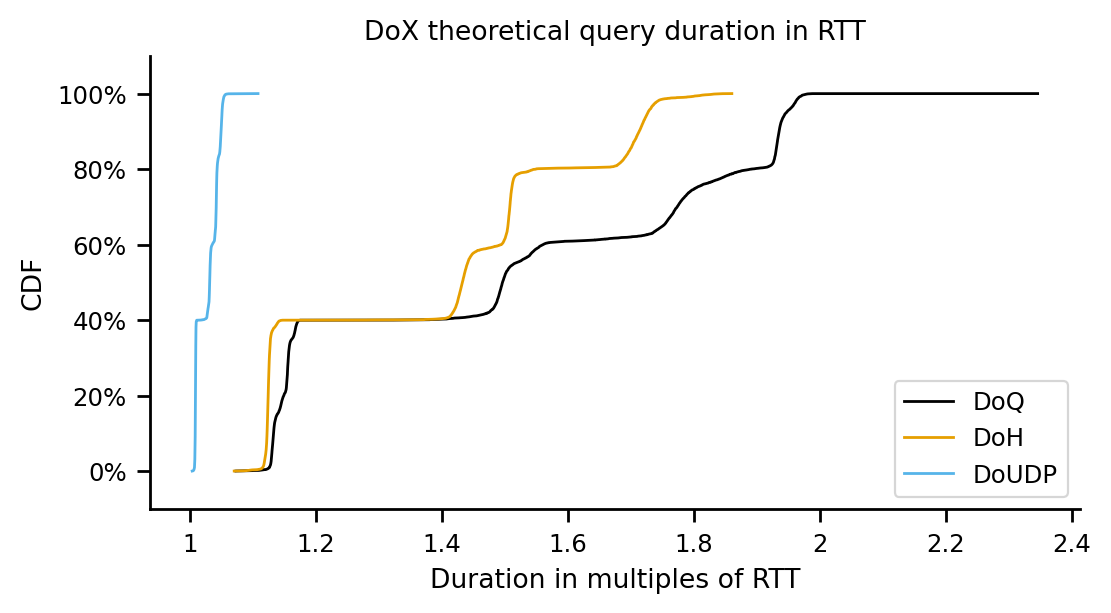

In [426]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

#plt.axvline(x=1, color='gray', linestyle='--')
#plt.axvline(x=2, color='gray', linestyle='--')
#plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical query duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/theoretical-query-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/theoretical-query-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    1771.000000
mean        1.768777
std         0.072076
min         1.407651
10%         1.698058
20%         1.742471
25%         1.750701
30%         1.756525
40%         1.765390
50%         1.773260
60%         1.781929
70%         1.793690
75%         1.802716
80%         1.815609
90%         1.849487
100%        2.345451
max         2.345451
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1771.000000
mean        1.713952
std         0.036794
min         1.466003
10%         1.685208
20%         1.694483
25%         1.698003
30%         1.701309
40%         1.707348
50%         1.713071
60%         1.718413
70%         1.723950
75%         1.726863
80%         1.730986
90%         1.742200
100%        1.860057
max         1.860057
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.048773
std         0.004709
min         1.019876
10%         1.043329
20%         1.046866
25%         1.047616
30%         1.048076
40%       

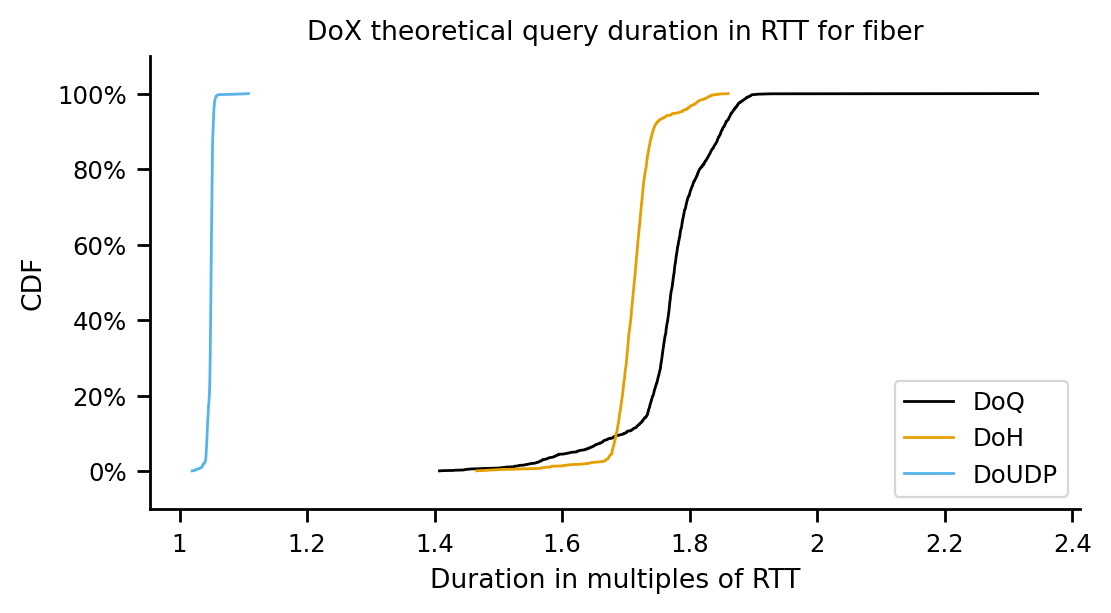

DoQ
count    1771.000000
mean        1.500950
std         0.032631
min         1.294487
10%         1.475352
20%         1.484920
25%         1.487689
30%         1.489596
40%         1.493051
50%         1.496351
60%         1.500436
70%         1.508431
75%         1.517925
80%         1.530699
90%         1.545893
100%        1.581566
max         1.581566
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1771.000000
mean        1.434612
std         0.021992
min         1.267833
10%         1.417269
20%         1.423036
25%         1.424917
30%         1.426399
40%         1.429483
50%         1.432363
60%         1.435400
70%         1.438570
75%         1.440599
80%         1.442722
90%         1.453427
100%        1.539340
max         1.539340
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.030955
std         0.002402
min         1.014908
10%         1.027833
20%         1.029768
25%         1.030321
30%         1.030574
40%       

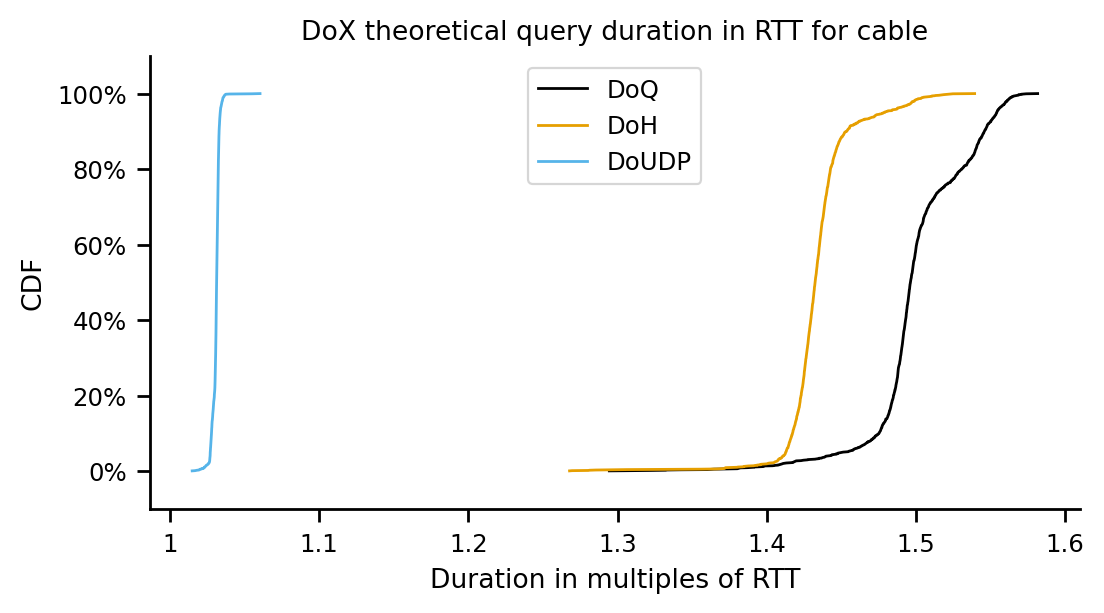

DoQ
count    1771.000000
mean        1.938699
std         0.016515
min         1.803749
10%         1.926408
20%         1.929364
25%         1.930363
30%         1.931327
40%         1.932961
50%         1.934903
60%         1.937437
70%         1.942530
75%         1.946778
80%         1.952842
90%         1.961770
100%        1.987789
max         1.987789
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1771.000000
mean        1.508095
std         0.011755
min         1.399031
10%         1.500427
20%         1.503672
25%         1.504579
30%         1.505215
40%         1.506430
50%         1.507633
60%         1.508688
70%         1.509933
75%         1.510614
80%         1.511648
90%         1.515297
100%        1.555582
max         1.555582
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.041520
std         0.001507
min         1.031577
10%         1.039561
20%         1.040664
25%         1.041073
30%         1.041251
40%       

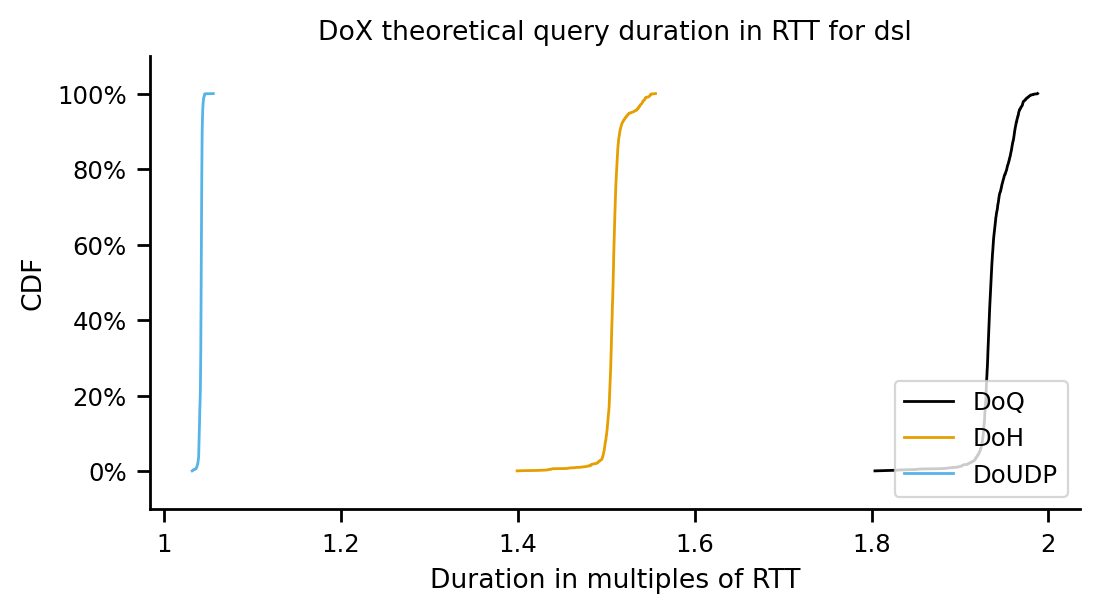

DoQ
count    1769.000000
mean        1.134512
std         0.007968
min         1.072813
10%         1.128462
20%         1.129734
25%         1.130183
30%         1.130723
40%         1.131681
50%         1.132735
60%         1.133819
70%         1.136421
75%         1.139459
80%         1.142386
90%         1.145597
100%        1.154791
max         1.154791
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1769.000000
mean        1.124208
std         0.005800
min         1.070226
10%         1.119773
20%         1.121639
25%         1.122086
30%         1.122475
40%         1.123268
50%         1.123992
60%         1.124718
70%         1.125506
75%         1.125963
80%         1.126490
90%         1.128665
100%        1.147049
max         1.147049
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008324
std         0.000621
min         1.003528
10%         1.007526
20%         1.008046
25%         1.008134
30%         1.008207
40%       

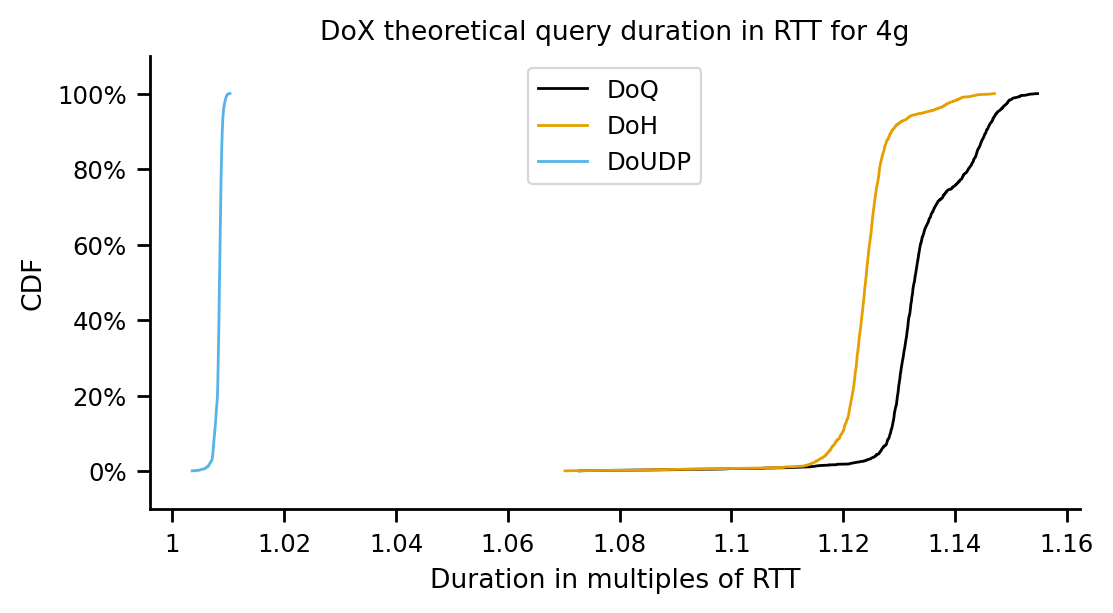

DoQ
count    1769.000000
mean        1.157812
std         0.006943
min         1.109798
10%         1.152837
20%         1.153996
25%         1.154362
30%         1.154727
40%         1.155282
50%         1.156123
60%         1.157010
70%         1.158829
75%         1.161920
80%         1.165065
90%         1.167725
100%        1.174666
max         1.174666
Name: theoretical_query_in_rtt, dtype: float64
DoH
count    1769.000000
mean        1.124299
std         0.005226
min         1.084519
10%         1.119697
20%         1.122131
25%         1.122605
30%         1.122977
40%         1.123625
50%         1.124243
60%         1.124826
70%         1.125600
75%         1.126031
80%         1.126513
90%         1.128427
100%        1.142604
max         1.142604
Name: theoretical_query_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008975
std         0.000608
min         1.005154
10%         1.008236
20%         1.008718
25%         1.008785
30%         1.008846
40%       

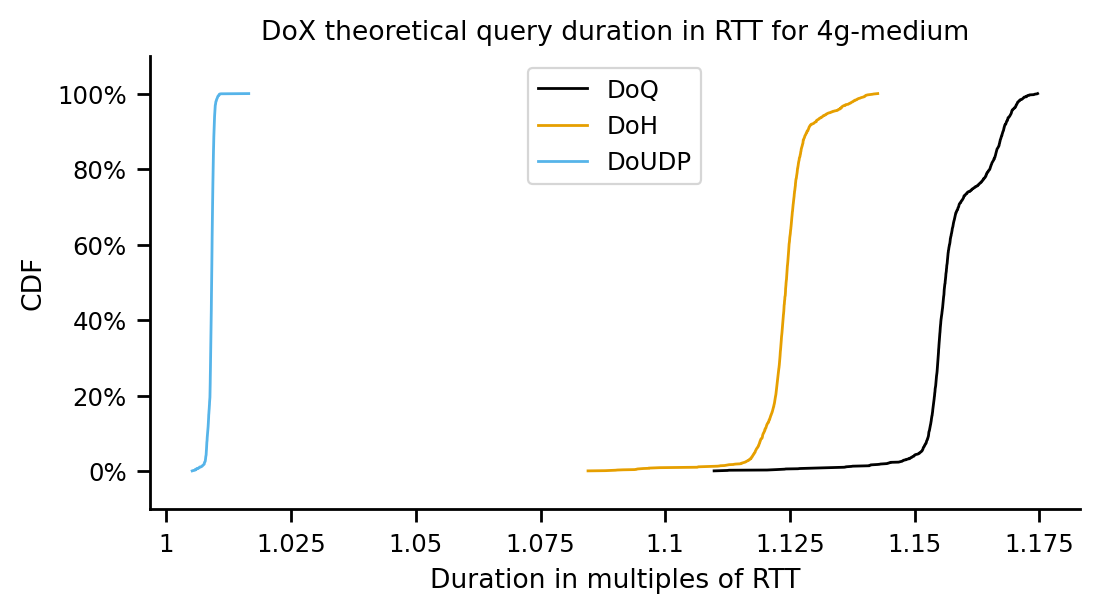

In [427]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_query_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical query duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    #ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/theoretical-query-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    8851.000000
mean       18.516886
std        10.800898
min         6.019842
10%        11.333214
20%        11.867711
25%        12.034638
30%        12.181123
40%        12.454563
50%        12.977583
60%        14.210046
70%        16.315703
75%        16.929232
80%        34.046646
90%        39.602287
100%       41.842546
max        41.842546
Name: theoretical_processing_delay, dtype: float64
DoH
count    8851.000000
mean       13.481867
std         4.141445
min         6.450457
10%        10.448268
20%        10.695628
25%        10.801127
30%        10.911957
40%        11.195667
50%        11.477812
60%        12.438140
70%        12.994050
75%        13.177723
80%        16.902879
90%        21.503225
100%       23.534352
max        23.534352
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    8851.000000
mean        0.992240
std         0.395451
min         0.293511
10%         0.704210
20%         0.738399
25%         0.751410
30%         0.762660
40

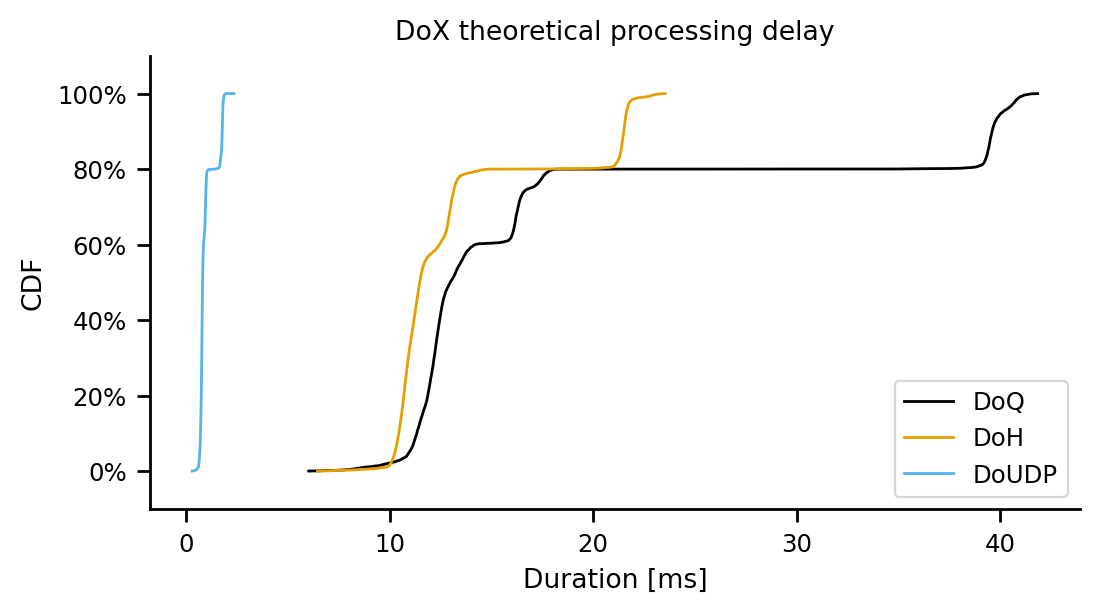

In [428]:
df_tmp = df_exchange_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)



ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoX theoretical processing delay')

ax.set_xlabel('Duration [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(0, 5)
ax.legend()


if log:
    fig.savefig('figures/processing-delay-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/processing-delay.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    1771.000000
mean       11.352640
std         1.064353
min         6.019842
10%        10.308320
20%        10.964172
25%        11.085712
30%        11.171713
40%        11.302621
50%        11.418847
60%        11.546861
70%        11.720536
75%        11.853833
80%        12.044214
90%        12.544493
100%       19.868467
max        19.868467
Name: theoretical_processing_delay, dtype: float64
DoH
count    1771.000000
mean       10.543031
std         0.543336
min         6.881531
10%        10.118567
20%        10.255528
25%        10.307516
30%        10.356337
40%        10.445513
50%        10.530026
60%        10.608905
70%        10.690682
75%        10.733699
80%        10.794575
90%        10.960183
100%       12.700594
max        12.700594
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1771.000000
mean        0.720240
std         0.069533
min         0.293511
10%         0.639850
20%         0.692080
25%         0.703156
30%         0.709941
40

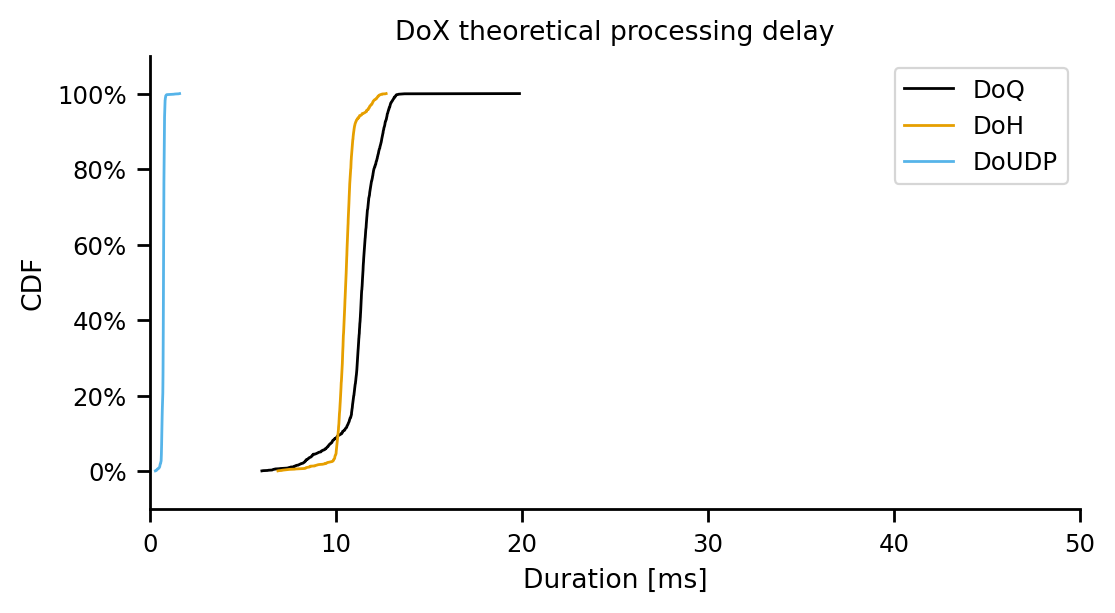

DoQ
count    1771.000000
mean       12.612237
std         0.821547
min         7.414198
10%        11.967773
20%        12.208672
25%        12.278387
30%        12.326388
40%        12.413372
50%        12.496455
60%        12.599302
70%        12.800592
75%        13.039607
80%        13.361211
90%        13.743745
100%       14.641894
max        14.641894
Name: theoretical_processing_delay, dtype: float64
DoH
count    1771.000000
mean       10.942065
std         0.553685
min         6.743133
10%        10.505446
20%        10.650619
25%        10.697987
30%        10.735293
40%        10.812951
50%        10.885448
60%        10.961909
70%        11.041720
75%        11.092797
80%        11.146251
90%        11.415775
100%       13.578762
max        13.578762
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1771.000000
mean        0.779353
std         0.060484
min         0.375336
10%         0.700753
20%         0.749455
25%         0.763372
30%         0.769754
40

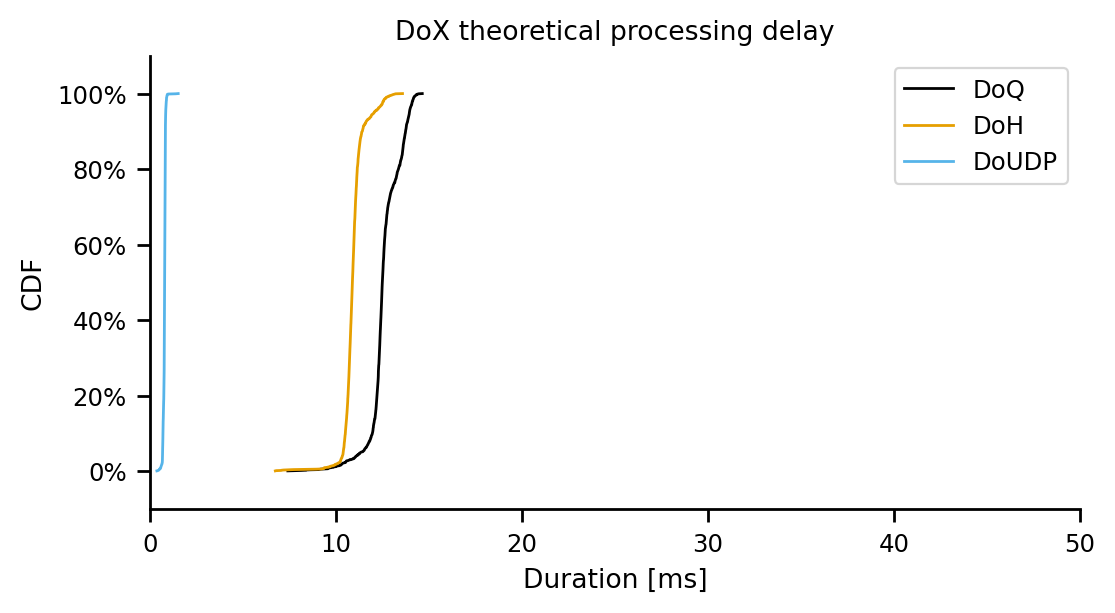

DoQ
count    1771.000000
mean       39.763090
std         0.699582
min        34.046646
10%        39.242444
20%        39.367653
25%        39.409997
30%        39.450799
40%        39.520053
50%        39.602287
60%        39.709634
70%        39.925371
75%        40.105307
80%        40.362167
90%        40.740377
100%       41.842546
max        41.842546
Name: theoretical_processing_delay, dtype: float64
DoH
count    1771.000000
mean       21.522817
std         0.497958
min        16.902879
10%        21.197997
20%        21.335447
25%        21.373881
30%        21.400818
40%        21.452281
50%        21.503225
60%        21.547911
70%        21.600652
75%        21.629505
80%        21.673286
90%        21.827877
100%       23.534352
max        23.534352
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1771.000000
mean        1.758792
std         0.063855
min         1.337601
10%         1.675782
20%         1.722517
25%         1.739857
30%         1.747368
40

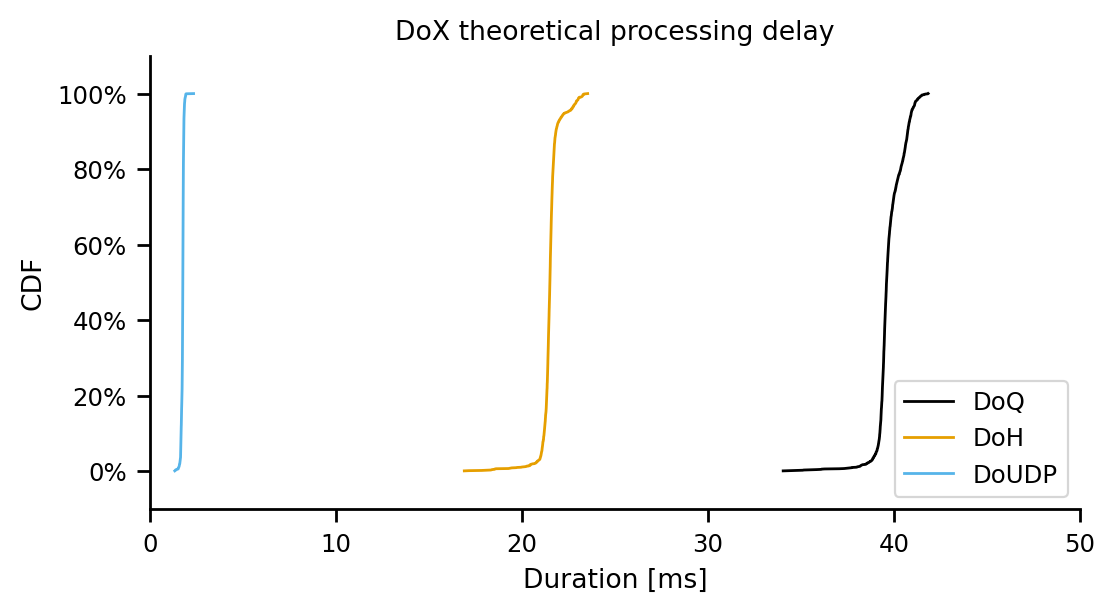

DoQ
count    1769.000000
mean       12.355196
std         0.731843
min         6.688085
10%        11.799509
20%        11.916329
25%        11.957623
30%        12.007233
40%        12.095195
50%        12.191975
60%        12.291616
70%        12.530576
75%        12.809639
80%        13.078463
90%        13.373397
100%       14.217947
max        14.217947
Name: theoretical_processing_delay, dtype: float64
DoH
count    1769.000000
mean       11.408777
std         0.532761
min         6.450457
10%        11.001461
20%        11.172822
25%        11.213873
30%        11.249569
40%        11.322490
50%        11.388964
60%        11.455612
70%        11.527996
75%        11.570038
80%        11.618401
90%        11.818186
100%       13.506827
max        13.506827
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1769.000000
mean        0.764584
std         0.057016
min         0.324046
10%         0.691289
20%         0.739081
25%         0.747149
30%         0.753868
40

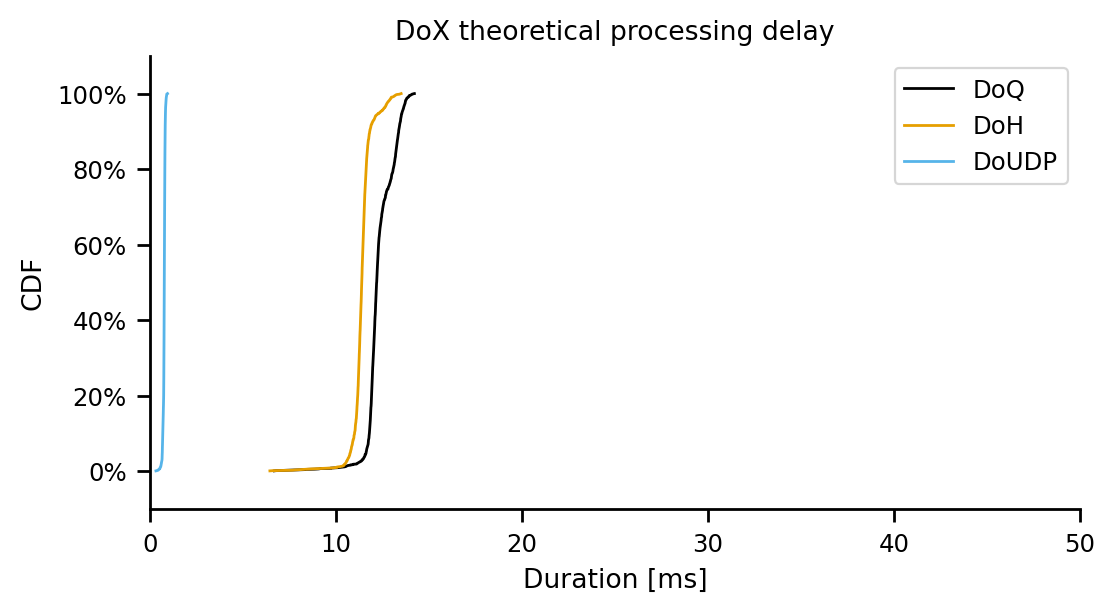

DoQ
count    1769.000000
mean       16.492023
std         0.725605
min        11.474379
10%        15.972121
20%        16.093194
25%        16.131445
30%        16.169567
40%        16.227582
50%        16.315526
60%        16.408187
70%        16.598318
75%        16.921293
80%        17.250020
90%        17.527949
100%       18.253300
max        18.253300
Name: theoretical_processing_delay, dtype: float64
DoH
count    1769.000000
mean       12.989746
std         0.546175
min         8.832610
10%        12.508809
20%        12.763186
25%        12.812767
30%        12.851585
40%        12.919350
50%        12.983905
60%        13.044798
70%        13.125746
75%        13.170801
80%        13.221173
90%        13.421118
100%       14.902707
max        14.902707
Name: theoretical_processing_delay, dtype: float64
DoUDP
count    1769.000000
mean        0.937912
std         0.063562
min         0.538606
10%         0.860714
20%         0.911064
25%         0.918034
30%         0.924471
40

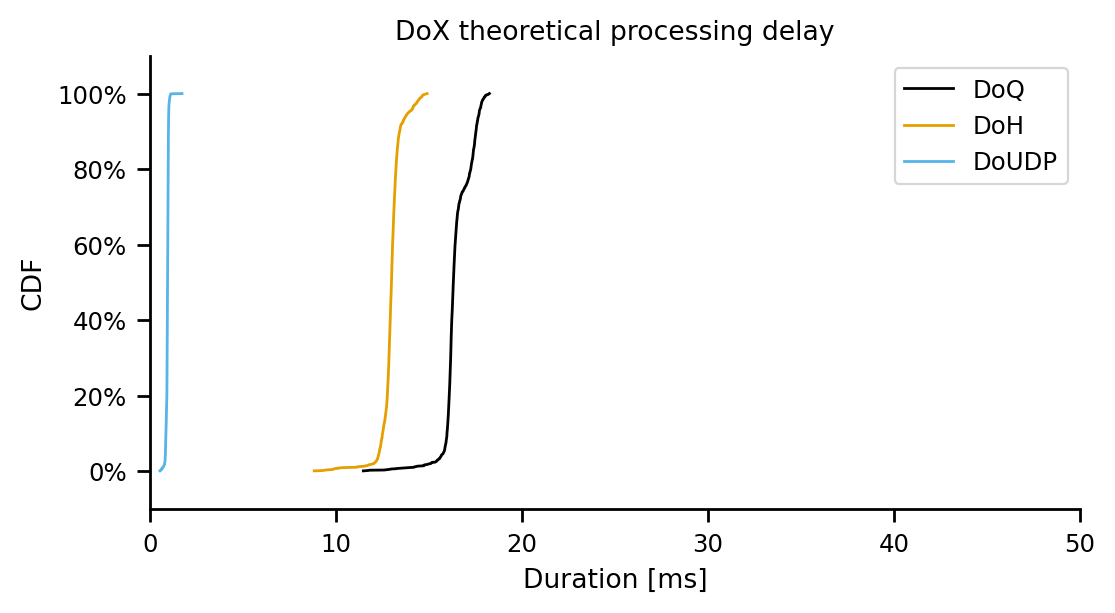

In [429]:
df_tmp = df_exchange_durations
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoH', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['theoretical_processing_delay'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    #plt.axvline(x=1, color='gray', linestyle='--')
    #plt.axvline(x=2, color='gray', linestyle='--')
    #plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoX theoretical processing delay')

    ax.set_xlabel('Duration [ms]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 50)
    ax.legend()


    if log:
        fig.savefig('figures/processing-delay-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/processing-delay-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [430]:
median_doq_0rtt_4g = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.experiment_type == '4g')].full_plt.median()
median_doq_0rtt_4g_med = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoQ + H3 0-RTT') & (df_dns_and_h3.experiment_type == '4g-medium')].full_plt.median()
print(str((median_doq_0rtt_4g_med/(median_doq_0rtt_4g/100))-100)+"%")

13.037752754144023%


In [431]:
median_doudp_1rtt_4g = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT') & (df_dns_and_h3.experiment_type == '4g')].full_plt.median()
median_doudp_1rtt_4g_med = df_dns_and_h3[(df_dns_and_h3.experiment_description == 'DoUDP + H3 1-RTT') & (df_dns_and_h3.experiment_type == '4g-medium')].full_plt.median()
print(str((median_doudp_1rtt_4g_med/(median_doudp_1rtt_4g/100))-100)+"%")

5.6131151302846405%


In [443]:
df_handshake_durations = df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'handshake'].copy()
df_handshake_durations = pd.merge(df_handshake_durations, measurements, on='msm_id')
df_handshake_durations['rtt'] = 0
df_handshake_durations['rtt'] = np.where(df_handshake_durations['experiment_type'] == 'dsl', 42.35979, df_handshake_durations['rtt'])
df_handshake_durations['rtt'] = np.where(df_handshake_durations['experiment_type'] == 'cable', 25.17665, df_handshake_durations['rtt'])
df_handshake_durations['rtt'] = np.where(df_handshake_durations['experiment_type'] == 'fiber', 14.767147, df_handshake_durations['rtt'])
df_handshake_durations['rtt'] = np.where(df_handshake_durations['experiment_type'] == '4g', 91.85231065904635, df_handshake_durations['rtt'])
df_handshake_durations['rtt'] = np.where(df_handshake_durations['experiment_type'] == '4g-medium', 104.5041425140391, df_handshake_durations['rtt'])
df_handshake_durations['duration_in_rtt'] = df_handshake_durations['duration'] / df_handshake_durations['rtt']

DoQ
count    8851.000000
mean        1.375855
std         0.224736
min         1.053693
10%         1.114190
20%         1.119166
25%         1.120692
30%         1.122768
40%         1.257661
50%         1.424583
60%         1.479667
70%         1.549313
75%         1.553387
80%         1.577409
90%         1.667227
100%        1.811258
max         1.811258
Name: duration_in_rtt, dtype: float64


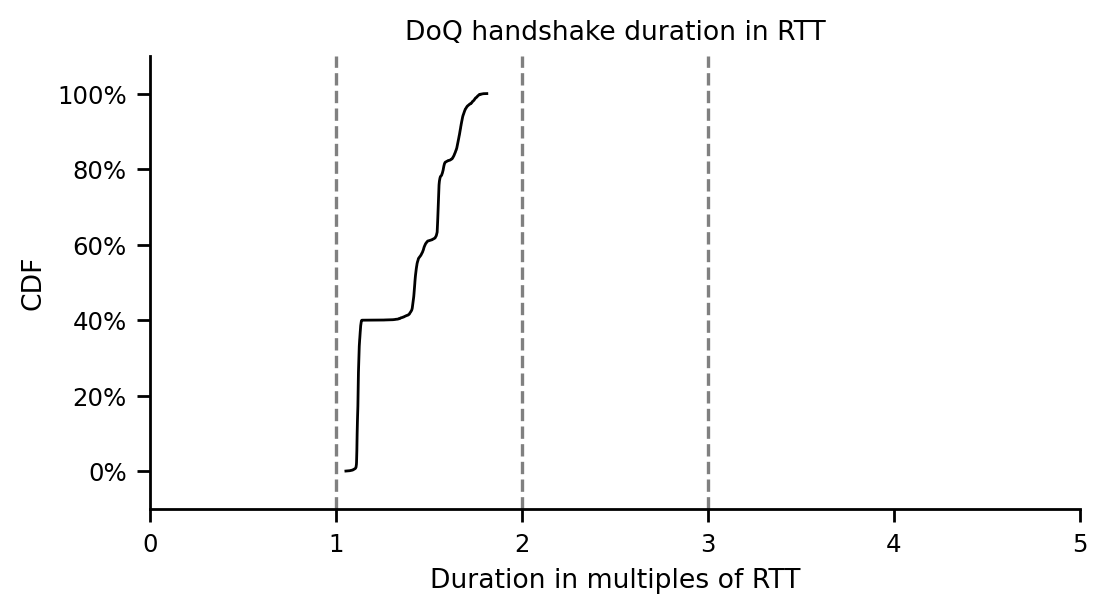

In [448]:
df_tmp = df_handshake_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoQ handshake duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 5)


if log:
    fig.savefig('figures/handshake-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/handshake-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoQ
count    1771.000000
mean        1.659740
std         0.068420
min         1.319737
10%         1.588456
20%         1.637854
25%         1.646085
30%         1.651784
40%         1.659568
50%         1.667227
60%         1.674071
70%         1.682255
75%         1.688637
80%         1.697912
90%         1.736954
100%        1.811258
max         1.811258
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.048773
std         0.004709
min         1.019876
10%         1.043329
20%         1.046866
25%         1.047616
30%         1.048076
40%         1.048799
50%         1.049386
60%         1.049960
70%         1.050574
75%         1.050884
80%         1.051184
90%         1.052330
100%        1.108004
max         1.108004
Name: duration_in_rtt, dtype: float64


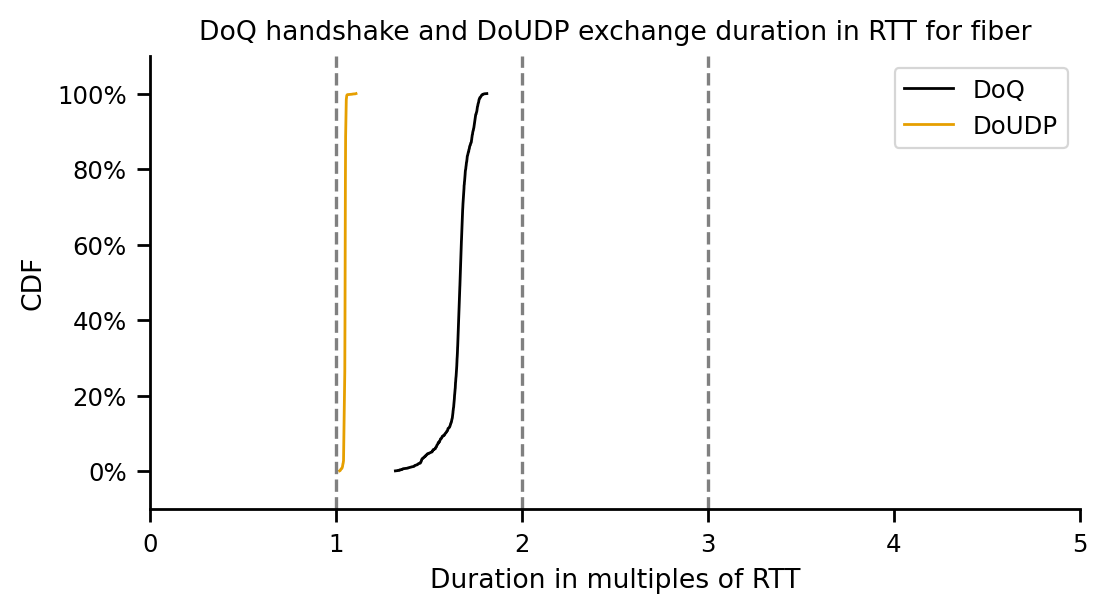

DoQ
count    1771.000000
mean        1.427445
std         0.030979
min         1.218622
10%         1.402049
20%         1.413796
25%         1.416325
30%         1.418471
40%         1.421801
50%         1.424956
60%         1.428862
70%         1.434223
75%         1.438167
80%         1.444884
90%         1.471039
100%        1.508806
max         1.508806
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.030955
std         0.002402
min         1.014908
10%         1.027833
20%         1.029768
25%         1.030321
30%         1.030574
40%         1.030958
50%         1.031292
60%         1.031624
70%         1.031936
75%         1.032133
80%         1.032371
90%         1.032953
100%        1.060372
max         1.060372
Name: duration_in_rtt, dtype: float64


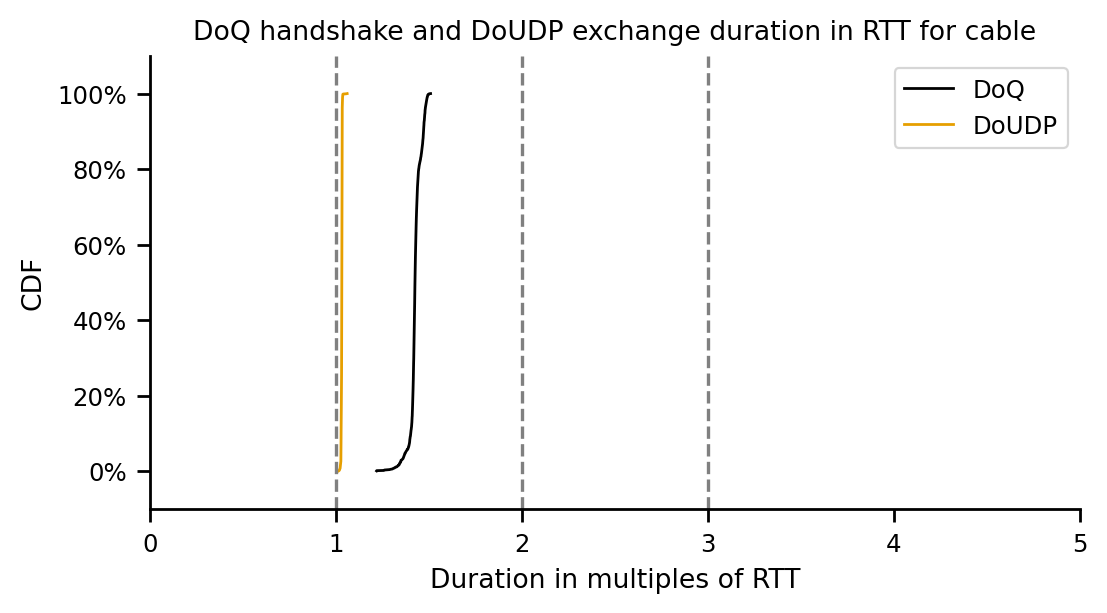

DoQ
count    1771.000000
mean        1.553260
std         0.015370
min         1.423357
10%         1.544422
20%         1.546314
25%         1.547078
30%         1.547852
40%         1.548941
50%         1.550377
60%         1.551786
70%         1.554092
75%         1.555788
80%         1.559326
90%         1.576857
100%        1.598408
max         1.598408
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.041520
std         0.001507
min         1.031577
10%         1.039561
20%         1.040664
25%         1.041073
30%         1.041251
40%         1.041510
50%         1.041739
60%         1.041966
70%         1.042192
75%         1.042322
80%         1.042467
90%         1.042889
100%        1.055413
max         1.055413
Name: duration_in_rtt, dtype: float64


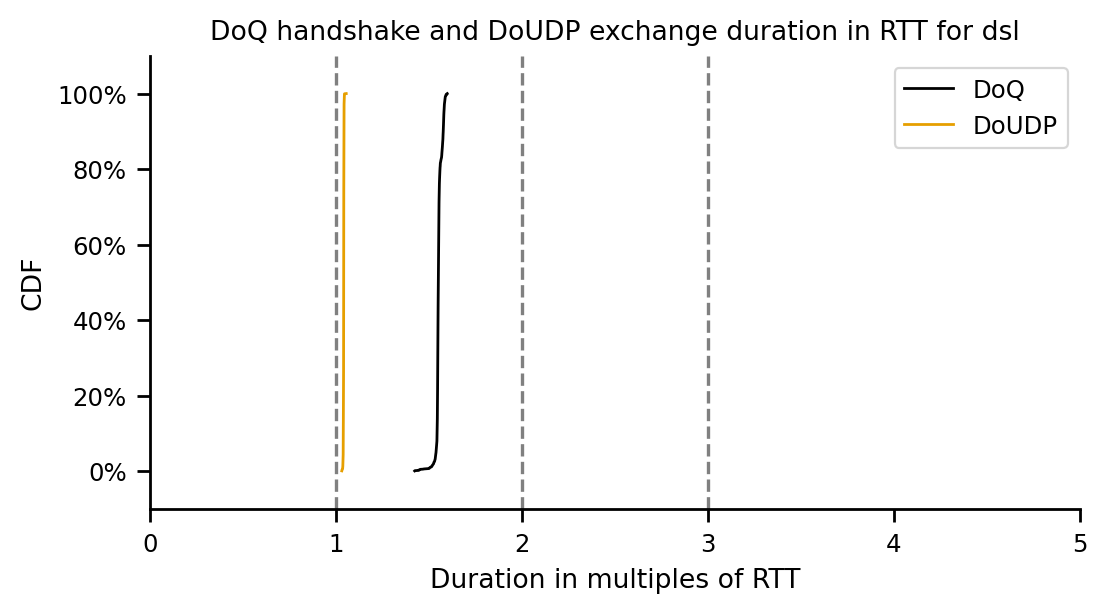

DoQ
count    1769.000000
mean        1.115977
std         0.007417
min         1.053693
10%         1.111020
20%         1.112135
25%         1.112618
30%         1.112988
40%         1.113685
50%         1.114520
60%         1.115485
70%         1.116769
75%         1.117966
80%         1.120295
90%         1.127091
100%        1.135726
max         1.135726
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008324
std         0.000621
min         1.003528
10%         1.007526
20%         1.008046
25%         1.008134
30%         1.008207
40%         1.008318
50%         1.008409
60%         1.008510
70%         1.008616
75%         1.008669
80%         1.008734
90%         1.008909
100%        1.010281
max         1.010281
Name: duration_in_rtt, dtype: float64


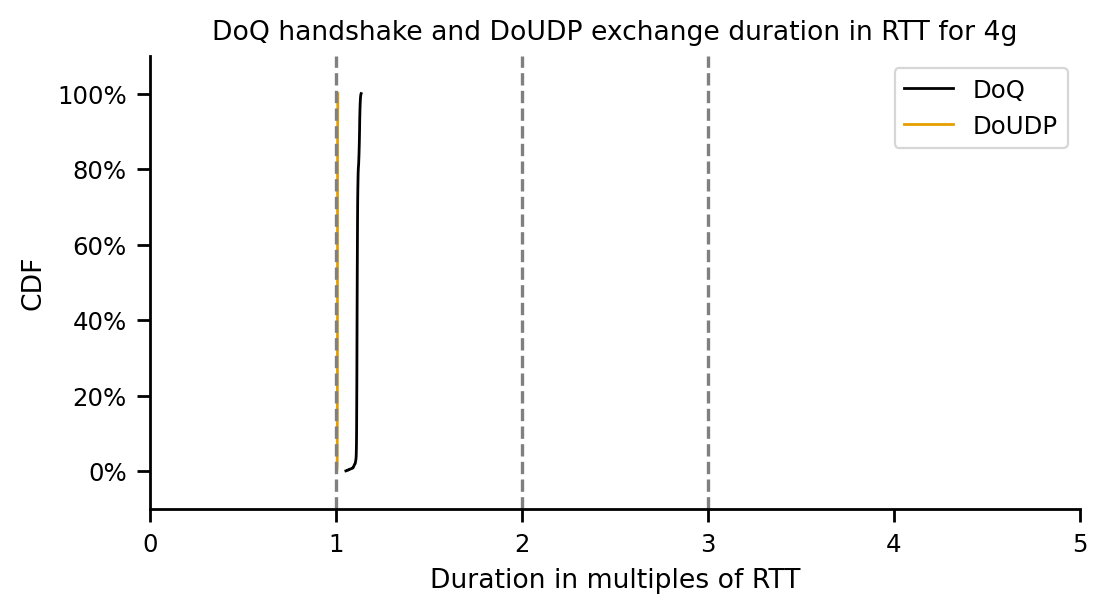

DoQ
count    1769.000000
mean        1.122273
std         0.006594
min         1.075342
10%         1.117966
20%         1.119014
25%         1.119417
30%         1.119784
40%         1.120357
50%         1.121101
60%         1.121898
70%         1.123026
75%         1.123816
80%         1.125822
90%         1.131986
100%        1.142767
max         1.142767
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008975
std         0.000608
min         1.005154
10%         1.008236
20%         1.008718
25%         1.008785
30%         1.008846
40%         1.008959
50%         1.009049
60%         1.009138
70%         1.009238
75%         1.009290
80%         1.009358
90%         1.009536
100%        1.016491
max         1.016491
Name: duration_in_rtt, dtype: float64


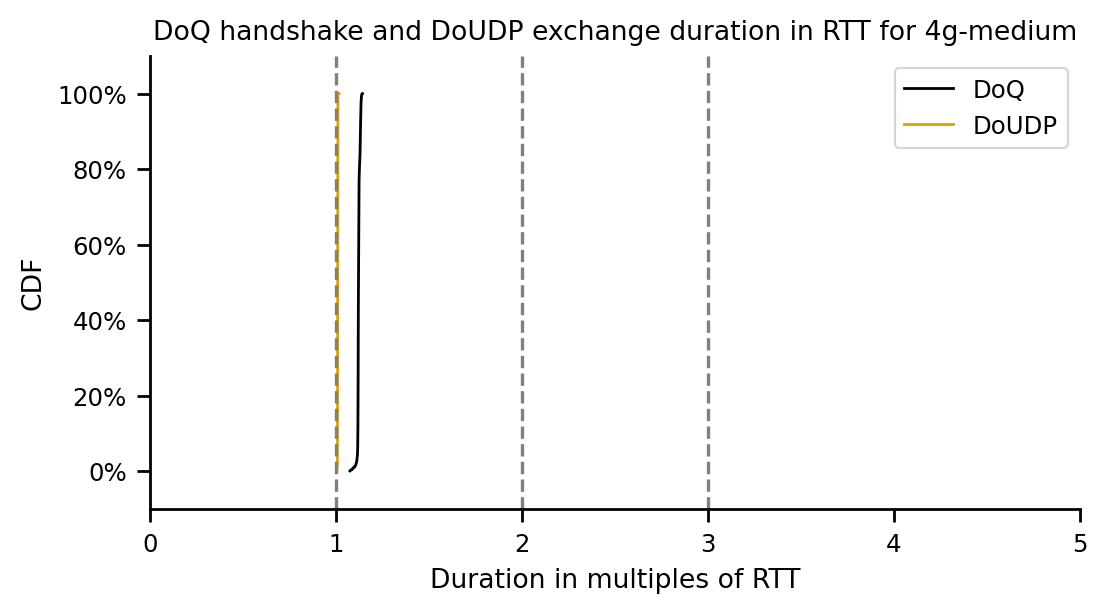

In [455]:
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        if proto == "DoQ":
            df_tmp = df_handshake_durations[df_handshake_durations.experiment_type == tech]
        if proto == "DoUDP":
            df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    plt.axvline(x=1, color='gray', linestyle='--')
    plt.axvline(x=2, color='gray', linestyle='--')
    plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoQ handshake and DoUDP exchange duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/doq-handshake-doudp-exchange-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/doq-handshake-doudp-exchange-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [530]:
df_tcp_pings = pd.DataFrame(columns=['duration', 'experiment_type'], )
for access_tech in ['dsl', 'cable', 'fiber', '4g', '4g-medium']:
    df_tmp = pd.read_csv('tcp_ping_'+access_tech+'.log', sep=" ", header=None, names=['len', 'ip', 'ttl', '??', 'id', 'port', 'flags', 'seq', 'cwin', 'duration', 'unit'])
    if df_tmp['unit'].nunique() > 1:
        print('error, unit that isnt miliseconds in data')
    df_tmp['experiment_type'] = access_tech
    #df_tmp.rename(columns=lambda x: x.replace('0', 'duration'), inplace=True)
    df_tmp = df_tmp[['duration', 'experiment_type']]
    df_tmp = df_tmp.apply(lambda s: s.str.replace('rtt=', ''))
    df_tmp['duration'] = pd.to_numeric(df_tmp['duration'])
    df_tcp_pings = pd.concat([df_tcp_pings, df_tmp])
df_tcp_pings
df_tcp_pings['rtt'] = 0
df_tcp_pings['rtt'] = np.where(df_tcp_pings['experiment_type'] == 'dsl', 42.35979, df_tcp_pings['rtt'])
df_tcp_pings['rtt'] = np.where(df_tcp_pings['experiment_type'] == 'cable', 25.17665, df_tcp_pings['rtt'])
df_tcp_pings['rtt'] = np.where(df_tcp_pings['experiment_type'] == 'fiber', 14.767147, df_tcp_pings['rtt'])
df_tcp_pings['rtt'] = np.where(df_tcp_pings['experiment_type'] == '4g', 91.85231065904635, df_tcp_pings['rtt'])
df_tcp_pings['rtt'] = np.where(df_tcp_pings['experiment_type'] == '4g-medium', 104.5041425140391, df_tcp_pings['rtt'])
df_tcp_pings['duration_in_rtt'] = df_tcp_pings['duration'] / df_tcp_pings['rtt']
df_tcp_pings['transport_protocol'] = 'TCP ping'
df_tcp_pings

duration experiment_type         rtt  duration_in_rtt transport_protocol
0         47.8             dsl   42.359790         1.128429           TCP ping
1         47.8             dsl   42.359790         1.128429           TCP ping
2         47.7             dsl   42.359790         1.126068           TCP ping
3         47.6             dsl   42.359790         1.123707           TCP ping
4         47.6             dsl   42.359790         1.123707           TCP ping
...        ...             ...         ...              ...                ...
1015     110.4       4g-medium  104.504143         1.056417           TCP ping
1016     110.4       4g-medium  104.504143         1.056417           TCP ping
1017     110.3       4g-medium  104.504143         1.055461           TCP ping
1018     110.2       4g-medium  104.504143         1.054504           TCP ping
1019     110.1       4g-medium  104.504143         1.053547           TCP ping

[5100 rows x 5 columns]

DoQ
count    1771.000000
mean        1.659740
std         0.068420
min         1.319737
10%         1.588456
20%         1.637854
25%         1.646085
30%         1.651784
40%         1.659568
50%         1.667227
60%         1.674071
70%         1.682255
75%         1.688637
80%         1.697912
90%         1.736954
100%        1.811258
max         1.811258
Name: duration_in_rtt, dtype: float64
TCP ping
count    1020.000000
mean        1.248930
std         0.134180
min         1.008997
10%         1.076714
20%         1.124117
25%         1.144432
30%         1.164748
40%         1.198607
50%         1.239237
60%         1.273096
70%         1.313727
75%         1.334042
80%         1.361130
90%         1.449163
100%        1.550740
max         1.550740
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.048773
std         0.004709
min         1.019876
10%         1.043329
20%         1.046866
25%         1.047616
30%         1.048076
40%         1.048799
50

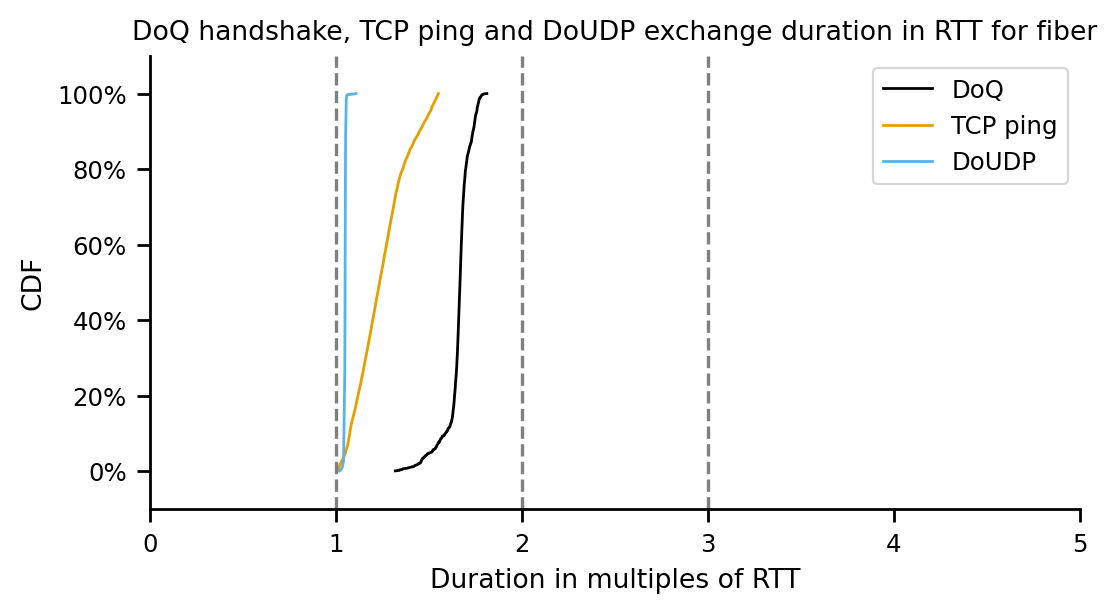

DoQ
count    1771.000000
mean        1.427445
std         0.030979
min         1.218622
10%         1.402049
20%         1.413796
25%         1.416325
30%         1.418471
40%         1.421801
50%         1.424956
60%         1.428862
70%         1.434223
75%         1.438167
80%         1.444884
90%         1.471039
100%        1.508806
max         1.508806
Name: duration_in_rtt, dtype: float64
TCP ping
count    1020.000000
mean        1.175038
std         0.088575
min         1.008871
10%         1.044619
20%         1.084338
25%         1.104198
30%         1.120085
40%         1.154244
50%         1.183636
60%         1.211440
70%         1.235272
75%         1.247187
80%         1.259103
90%         1.294851
100%        1.326626
max         1.326626
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.030955
std         0.002402
min         1.014908
10%         1.027833
20%         1.029768
25%         1.030321
30%         1.030574
40%         1.030958
50

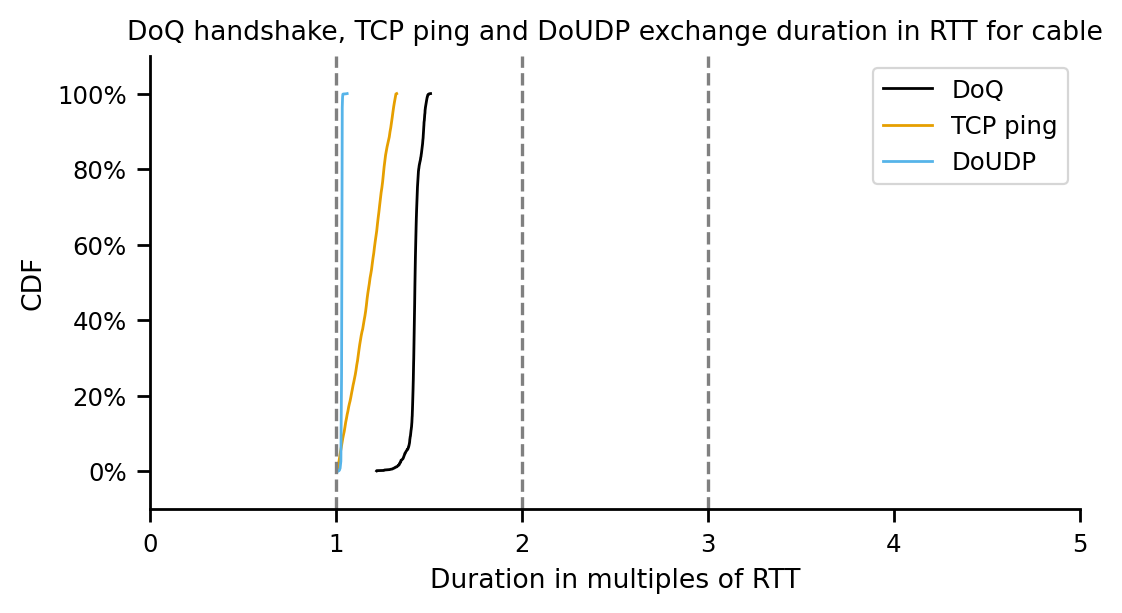

DoQ
count    1771.000000
mean        1.553260
std         0.015370
min         1.423357
10%         1.544422
20%         1.546314
25%         1.547078
30%         1.547852
40%         1.548941
50%         1.550377
60%         1.551786
70%         1.554092
75%         1.555788
80%         1.559326
90%         1.576857
100%        1.598408
max         1.598408
Name: duration_in_rtt, dtype: float64
TCP ping
count    1020.000000
mean        1.114209
std         0.055611
min         1.017474
10%         1.033999
20%         1.055246
25%         1.064689
30%         1.076493
40%         1.097739
50%         1.118986
60%         1.135511
70%         1.152744
75%         1.161479
80%         1.170922
90%         1.189808
100%        1.206333
max         1.206333
Name: duration_in_rtt, dtype: float64
DoUDP
count    1771.000000
mean        1.041520
std         0.001507
min         1.031577
10%         1.039561
20%         1.040664
25%         1.041073
30%         1.041251
40%         1.041510
50

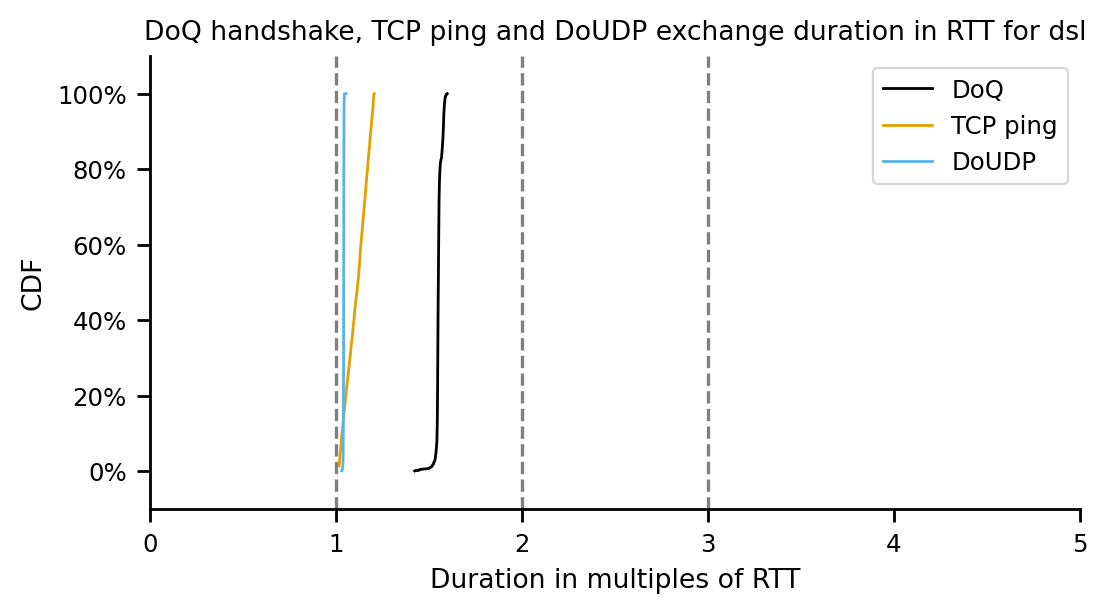

DoQ
count    1769.000000
mean        1.115977
std         0.007417
min         1.053693
10%         1.111020
20%         1.112135
25%         1.112618
30%         1.112988
40%         1.113685
50%         1.114520
60%         1.115485
70%         1.116769
75%         1.117966
80%         1.120295
90%         1.127091
100%        1.135726
max         1.135726
Name: duration_in_rtt, dtype: float64
TCP ping
count    1020.000000
mean        1.047755
std         0.025450
min         1.002697
10%         1.011406
20%         1.021205
25%         1.025559
30%         1.031003
40%         1.040366
50%         1.048422
60%         1.058221
70%         1.065841
75%         1.070196
80%         1.074551
90%         1.081083
100%        1.088704
max         1.088704
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008324
std         0.000621
min         1.003528
10%         1.007526
20%         1.008046
25%         1.008134
30%         1.008207
40%         1.008318
50

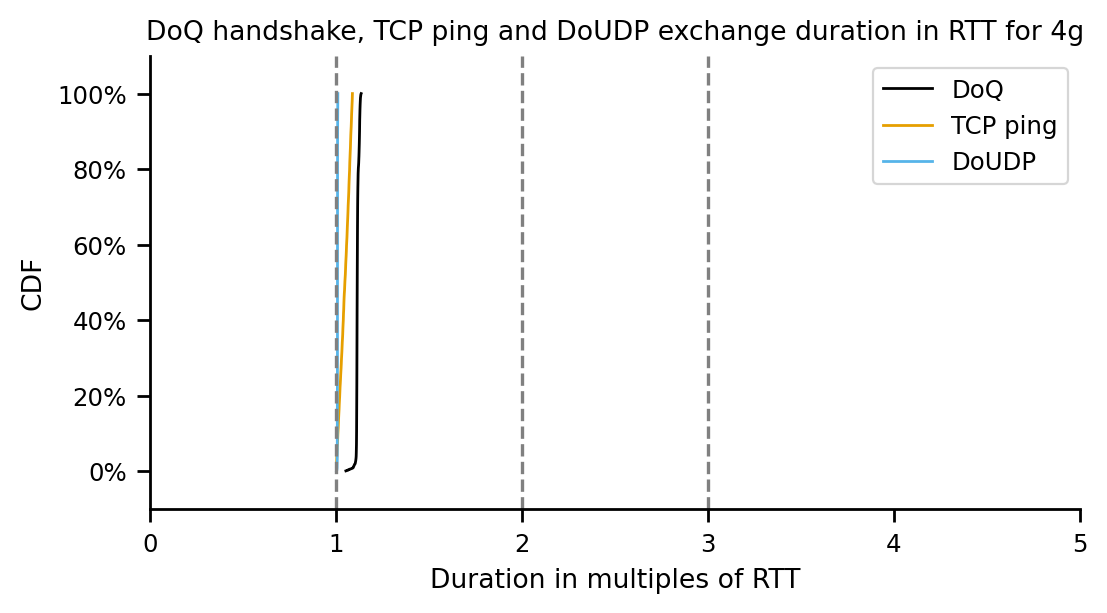

DoQ
count    1769.000000
mean        1.122273
std         0.006594
min         1.075342
10%         1.117966
20%         1.119014
25%         1.119417
30%         1.119784
40%         1.120357
50%         1.121101
60%         1.121898
70%         1.123026
75%         1.123816
80%         1.125822
90%         1.131986
100%        1.142767
max         1.142767
Name: duration_in_rtt, dtype: float64
TCP ping
count    1020.000000
mean        1.044111
std         0.020558
min         1.002831
10%         1.013357
20%         1.023883
25%         1.028667
30%         1.032495
40%         1.039193
50%         1.045892
60%         1.052590
70%         1.058331
75%         1.061202
80%         1.064073
90%         1.070771
100%        1.079383
max         1.079383
Name: duration_in_rtt, dtype: float64
DoUDP
count    1769.000000
mean        1.008975
std         0.000608
min         1.005154
10%         1.008236
20%         1.008718
25%         1.008785
30%         1.008846
40%         1.008959
50

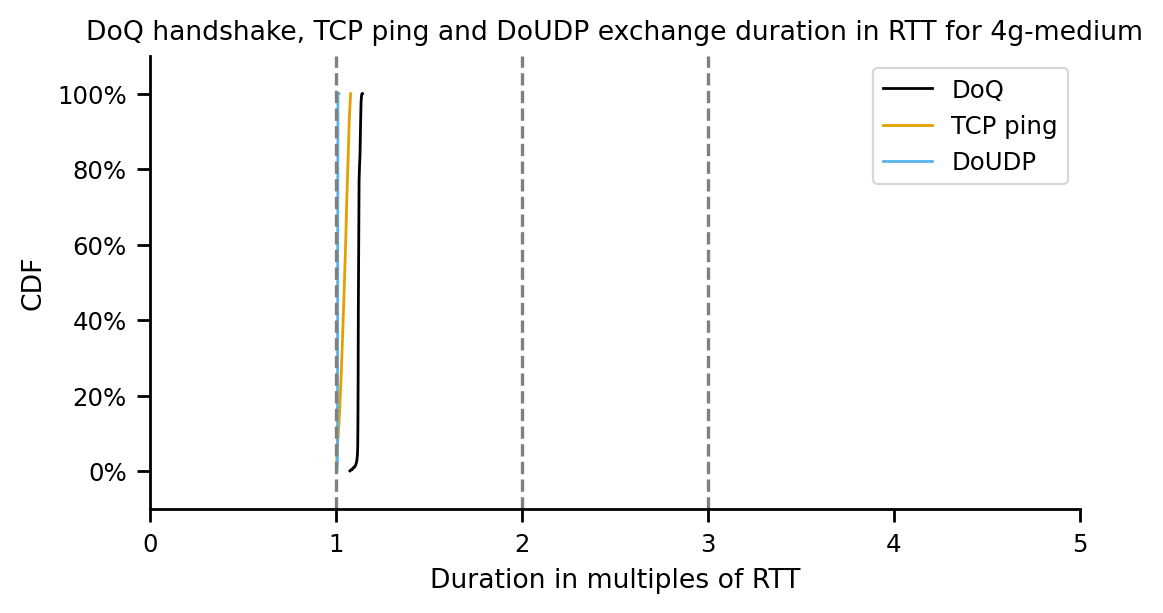

In [531]:
access_techs = ['fiber', 'cable', 'dsl', '4g', '4g-medium']
for tech in access_techs:
    fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
    line_order = ['DoQ', 'TCP ping', 'DoUDP']
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    sample_size = dict()
    lnwidth = 1
    mrksize = 0
    log=False
    for proto in line_order:
        if proto == "DoQ":
            df_tmp = df_handshake_durations[df_handshake_durations.experiment_type == tech]
        if proto == "DoUDP":
            df_tmp = df_exchange_durations[df_exchange_durations.experiment_type == tech]
        if proto == "TCP ping":
            df_tmp = df_tcp_pings[df_tcp_pings.experiment_type == tech]
        #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
        print(proto)
        print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
        #ax.plot(cdf.xs, cdf.ps, label=col_val_,
        #            linestyle='-', linewidth=lnwidth, 
        #            markersize=mrksize, fillstyle='none', 
        #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
        #            color=colors[col_val_], marker=markers[col_val_]
        #        )
        dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
        dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

    plt.axvline(x=1, color='gray', linestyle='--')
    plt.axvline(x=2, color='gray', linestyle='--')
    plt.axvline(x=3, color='gray', linestyle='--')

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('DoQ handshake, TCP ping and DoUDP exchange duration in RTT for '+tech)

    ax.set_xlabel('Duration in multiples of RTT')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0, 5)
    ax.legend()


    if log:
        fig.savefig('figures/doq-handshake-tcp-ping-doudp-exchange-duration-in-rtt-'+tech+'-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('figures/doq-handshake-tcp-ping-doudp-exchange-duration-in-rtt-'+tech+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()

DoQ
count    8851.000000
mean        1.375855
std         0.224736
min         1.053693
10%         1.114190
20%         1.119166
25%         1.120692
30%         1.122768
40%         1.257661
50%         1.424583
60%         1.479667
70%         1.549313
75%         1.553387
80%         1.577409
90%         1.667227
100%        1.811258
max         1.811258
Name: duration_in_rtt, dtype: float64
TCP ping
count    5100.000000
mean        1.126009
std         0.109981
min         1.002697
10%         1.022540
20%         1.038236
25%         1.045156
30%         1.052590
40%         1.065841
50%         1.080366
60%         1.120085
70%         1.163840
75%         1.185069
80%         1.207468
90%         1.286640
100%        1.550740
max         1.550740
Name: duration_in_rtt, dtype: float64
DoUDP
count    8851.000000
mean        1.027718
std         0.016749
min         1.003528
10%         1.008306
20%         1.008726
25%         1.008913
30%         1.009099
40%         1.017382
50

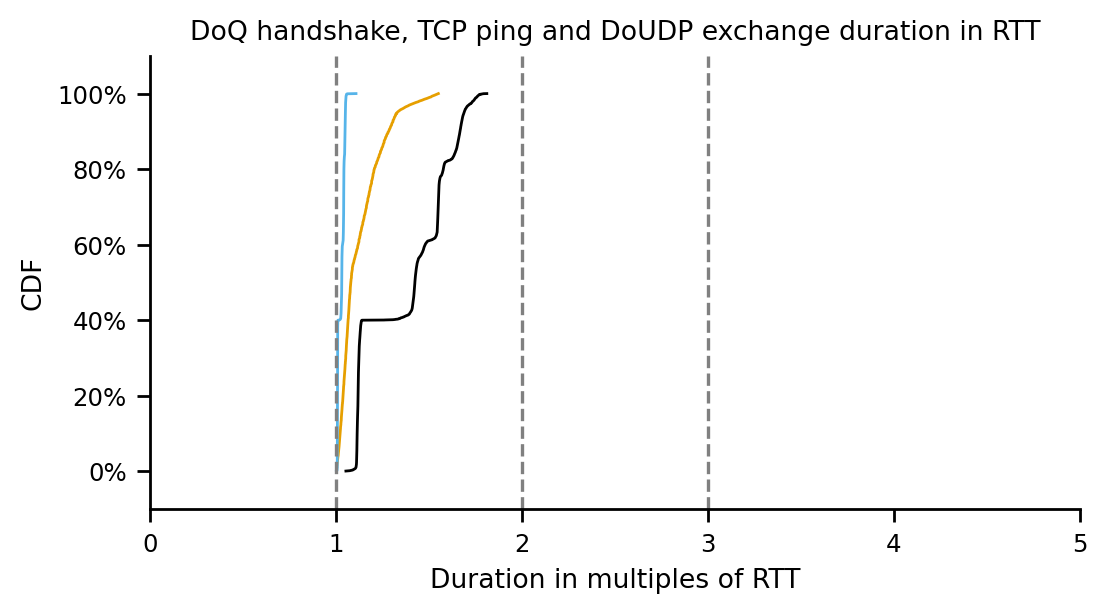

In [532]:
#df_tmp = df_handshake_durations
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'TCP ping', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
lnwidth = 1
mrksize = 0
log=False
for proto in line_order:
    #cdf = Cdf.MakeCdfFromList(df_tmp[col_val_])
    if proto == "DoQ":
        df_tmp = df_handshake_durations
    if proto == "DoUDP":
        df_tmp = df_exchange_durations
    if proto == "TCP ping":
        df_tmp = df_tcp_pings
    print(proto)
    print(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    #ax.plot(cdf.xs, cdf.ps, label=col_val_,
    #            linestyle='-', linewidth=lnwidth, 
    #            markersize=mrksize, fillstyle='none', 
    #            markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
    #            color=colors[col_val_], marker=markers[col_val_]
    #        )
    dfplt = make_cdf(df_tmp[df_tmp.transport_protocol == proto]['duration_in_rtt'])
    dfplt.plot(ax=ax, label=proto, marker=markers[proto], markersize=mrksize, drawstyle="default", color=colors[proto], linestyle='-', linewidth=lnwidth, logx=log)

plt.axvline(x=1, color='gray', linestyle='--')
plt.axvline(x=2, color='gray', linestyle='--')
plt.axvline(x=3, color='gray', linestyle='--')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('DoQ handshake, TCP ping and DoUDP exchange duration in RTT')

ax.set_xlabel('Duration in multiples of RTT')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0, 5)


if log:
    fig.savefig('figures/doq-handshake-tcp-ping-doudp-exchange-duration-in-rtt-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/doq-handshake-tcp-ping-doudp-exchange-duration-in-rtt.pdf', format='pdf', bbox_inches='tight')
plt.show()